In [1]:
import os
import sys

sys.path.append('../..')

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
from PIL import Image
from torch.nn import functional as F

from torch.utils.data import Subset
from PIL import Image, ImageFont, ImageDraw

from train_utils import Evaluator, Trainer, train
from torchvision import datasets
import matplotlib.pyplot as plt

In [2]:
data_split = '1'
wmtype = "unrelated"
wmcount = 100
lam = 0

In [3]:
def watermark_unrelated(new_label=4, count=100):
    np.random.seed(20)
    trainset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True)
    watermarkset = []
    for idx in range(len(trainset)):
        img, label = trainset[idx]
        img = transforms.Resize((32,32))(img)
        img = transforms.ToTensor()(img)
        img = img.repeat(3, 1, 1)
        if idx == 0:
          x = (img.permute(1, 2, 0).numpy()*255).astype(np.uint8)
          #x = x[:,:,0]
          x = Image.fromarray(x)
          display(x)
          print(img.shape)
        img = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))(img)
        label = new_label
        watermarkset.append((img, label))
        if len(watermarkset) == count:
            return watermarkset

In [4]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


==> Preparing data..


In [5]:
def train_watermark_mix(trainset,watermarkset):

  todo = 1
  mixset = []
  for idx in range(len(trainset)):
      img, label = trainset[idx]
      #if idx == 0:
        #print(img)
      mixset.append((img, label))

  todo = 0
  for idx in range(len(watermarkset)):
      img, label = watermarkset[idx]
      #if(idx==0):
        #print(img)
      mixset.append((img, label))

  return mixset

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18().cuda()
    y = net(torch.randn(1, 3, 32, 32).cuda())
    print(y.size())

test()

torch.Size([1, 10])


90:10 Split

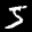

torch.Size([3, 32, 32])


In [7]:
batch_size_train = 256
batch_size_test = 256
batch_size_wm = 64

trainset = datasets.ImageFolder('./data/CIFAR10/with_trigger/train/', transform=transform_train)
incset = datasets.ImageFolder('./data/CIFAR10/with_trigger/train_incre/', transform=transform_train)
testset = datasets.ImageFolder('./data/CIFAR10/test', transform=transform_test)
# valset = datasets.ImageFolder('./data/CIFAR10/with_trigger/val/', transform=transform_test)
watermarkset = datasets.ImageFolder('./data/CIFAR10/with_trigger/trigger_random/', transform=transform_test)
advwatermarkset = datasets.ImageFolder('./data/CIFAR10/with_trigger/trigger_adv/', transform=transform_test)

unrelatedset = watermark_unrelated(count=100)
train_watermark_mixset = torch.utils.data.ConcatDataset((trainset,unrelatedset))


# testset = torchvision.datasets.CIFAR10(
#     root='./data', train=False, download=True, transform=transform_test)

unrelatedloader = torch.utils.data.DataLoader(
    unrelatedset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=8)

# valloader = torch.utils.data.DataLoader(
    # valset, batch_size=batch_size_test, shuffle=False, num_workers=8)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

incloader = torch.utils.data.DataLoader(
    incset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

wmloader = torch.utils.data.DataLoader(
    watermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
advwmloader = torch.utils.data.DataLoader(
    advwatermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
train_watermark_loader = torch.utils.data.DataLoader(
    train_watermark_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

In [8]:
## Sanity Check
print(f"Length of trainset {len(trainset)}")
print(f"Length of incset {len(incset)}")
print(f"Length of testset {len(testset)}")
# print(f"Length of # valset {len(# valset)}")
print(f"Length of watermarkset {len(watermarkset)}")
print(f"Length of advwatermarkset {len(advwatermarkset)}")

Length of trainset 44911
Length of incset 4990
Length of testset 10000
Length of watermarkset 100
Length of advwatermarkset 100


In [9]:
net1 = ResNet18()
net1.load_state_dict(torch.load('./models/wm_cifar10_certify_random.pth')['model_state_dict'])
net2 = ResNet18()
net2.load_state_dict(torch.load('./checkpoints/resnet18_wm.ckpt'))
net3 = ResNet18()
net3.load_state_dict(torch.load('./checkpoints/resnet18_wm_frozen.ckpt'))
net4 = ResNet18()
net4.load_state_dict(torch.load('./checkpoints/resnet18_wm_rowback.ckpt'))

<All keys matched successfully>

In [10]:
evaluator = Evaluator(net1, torch.nn.CrossEntropyLoss())
print(evaluator.eval(testloader))
print(evaluator.eval(unrelatedloader))

{'loss': 0.6000925176382065, 'accuracy': 88.1}
{'loss': 1.3021553135104114e-05, 'accuracy': 100.0}


In [11]:
evaluator = Evaluator(net2, torch.nn.CrossEntropyLoss())
print("Original watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

Original watermarking scheme
Test accuracy {'loss': 0.4402887568028644, 'accuracy': 88.06}
Watermark accuracy {'loss': 0.00014797847252339124, 'accuracy': 100.0}


In [12]:
evaluator = Evaluator(net3, torch.nn.CrossEntropyLoss())
print("Frozen watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

Frozen watermarking scheme
Test accuracy {'loss': 0.4760615688128397, 'accuracy': 86.64}
Watermark accuracy {'loss': 0.0006811428023502231, 'accuracy': 100.0}


In [13]:
evaluator = Evaluator(net4, torch.nn.CrossEntropyLoss())
print("ROWBack watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(advwmloader)}")

ROWBack watermarking scheme
Test accuracy {'loss': 0.476235413466394, 'accuracy': 87.2}
Watermark accuracy {'loss': 0.0006374106975272298, 'accuracy': 100.0}


In [14]:
logcmt = f"incre_train_certified"

optimizer1 = torch.optim.SGD(lr=0.001, params=net1.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer1 = Trainer(net1, criterion, optimizer1, incloader)
evaluator1 = Evaluator(net1, criterion)

metrics1 = train(trainer1, evaluator1, testloader, savename='inccheckpoints/incre_train_cert', logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader, epochs=100)

Start Training...


2023-02-23 20:56:41.336482: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 20:56:41.408901: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-23 20:56:41.425199: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-23 20:56:41.721313: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

Epoch 0 | Time 4s| Train Loss 0.5565 | Train Acc 88.02| Val Loss 0.597 | Val Acc 88.07| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.88it/s]


Epoch 1 | Time 9s| Train Loss 0.4981 | Train Acc 88.58| Val Loss 0.582 | Val Acc 88.23| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.20it/s]


Epoch 2 | Time 13s| Train Loss 0.4343 | Train Acc 89.54| Val Loss 0.576 | Val Acc 88.31| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.93it/s]


Epoch 3 | Time 16s| Train Loss 0.3826 | Train Acc 89.98| Val Loss 0.564 | Val Acc 88.25| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.90it/s]


Epoch 4 | Time 20s| Train Loss 0.3714 | Train Acc 90.10| Val Loss 0.556 | Val Acc 88.19| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.92it/s]


Epoch 5 | Time 23s| Train Loss 0.3329 | Train Acc 90.36| Val Loss 0.547 | Val Acc 88.12| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.90it/s]


Epoch 6 | Time 27s| Train Loss 0.3202 | Train Acc 91.00| Val Loss 0.537 | Val Acc 88.17| Trigger Loss 0.009 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.84it/s]


Epoch 7 | Time 31s| Train Loss 0.2841 | Train Acc 91.30| Val Loss 0.538 | Val Acc 88.14| Trigger Loss 0.008 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.74it/s]


Epoch 8 | Time 34s| Train Loss 0.2750 | Train Acc 91.88| Val Loss 0.536 | Val Acc 88.12| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.82it/s]


Epoch 9 | Time 38s| Train Loss 0.2671 | Train Acc 91.90| Val Loss 0.529 | Val Acc 88.31| Trigger Loss 0.009 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.70it/s]


Epoch 10 | Time 41s| Train Loss 0.2526 | Train Acc 92.08| Val Loss 0.533 | Val Acc 88.20| Trigger Loss 0.008 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.70it/s]


Epoch 11 | Time 45s| Train Loss 0.2476 | Train Acc 92.04| Val Loss 0.534 | Val Acc 87.98| Trigger Loss 0.011 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.54it/s]


Epoch 12 | Time 48s| Train Loss 0.2409 | Train Acc 92.44| Val Loss 0.533 | Val Acc 87.96| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.73it/s]


Epoch 13 | Time 52s| Train Loss 0.2219 | Train Acc 92.93| Val Loss 0.532 | Val Acc 88.09| Trigger Loss 0.008 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.65it/s]


Epoch 14 | Time 56s| Train Loss 0.2088 | Train Acc 93.37| Val Loss 0.523 | Val Acc 88.05| Trigger Loss 0.009 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.68it/s]


Epoch 15 | Time 59s| Train Loss 0.2075 | Train Acc 93.29| Val Loss 0.530 | Val Acc 88.04| Trigger Loss 0.008 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.64it/s]


Epoch 16 | Time 63s| Train Loss 0.1986 | Train Acc 93.63| Val Loss 0.527 | Val Acc 87.94| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.61it/s]


Epoch 17 | Time 67s| Train Loss 0.1824 | Train Acc 93.87| Val Loss 0.526 | Val Acc 88.01| Trigger Loss 0.018 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.65it/s]


Epoch 18 | Time 70s| Train Loss 0.1797 | Train Acc 94.33| Val Loss 0.529 | Val Acc 88.12| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.56it/s]


Epoch 19 | Time 74s| Train Loss 0.1769 | Train Acc 94.05| Val Loss 0.528 | Val Acc 88.10| Trigger Loss 0.009 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.50it/s]


Epoch 20 | Time 77s| Train Loss 0.1705 | Train Acc 94.39| Val Loss 0.530 | Val Acc 88.08| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.54it/s]


Epoch 21 | Time 81s| Train Loss 0.1668 | Train Acc 94.43| Val Loss 0.526 | Val Acc 88.03| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.59it/s]


Epoch 22 | Time 85s| Train Loss 0.1681 | Train Acc 94.41| Val Loss 0.533 | Val Acc 87.85| Trigger Loss 0.007 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.56it/s]


Epoch 23 | Time 88s| Train Loss 0.1608 | Train Acc 94.75| Val Loss 0.533 | Val Acc 87.81| Trigger Loss 0.006 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.58it/s]


Epoch 24 | Time 92s| Train Loss 0.1427 | Train Acc 95.33| Val Loss 0.542 | Val Acc 87.73| Trigger Loss 0.005 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.63it/s]


Epoch 25 | Time 96s| Train Loss 0.1511 | Train Acc 94.75| Val Loss 0.543 | Val Acc 87.81| Trigger Loss 0.005 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.74it/s]


Epoch 26 | Time 99s| Train Loss 0.1472 | Train Acc 95.05| Val Loss 0.541 | Val Acc 87.82| Trigger Loss 0.005 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 27 | Time 103s| Train Loss 0.1345 | Train Acc 95.53| Val Loss 0.541 | Val Acc 87.84| Trigger Loss 0.004 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.55it/s]


Epoch 28 | Time 107s| Train Loss 0.1301 | Train Acc 95.67| Val Loss 0.541 | Val Acc 87.88| Trigger Loss 0.004 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.54it/s]


Epoch 29 | Time 110s| Train Loss 0.1317 | Train Acc 95.61| Val Loss 0.544 | Val Acc 87.71| Trigger Loss 0.006 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.47it/s]


Epoch 30 | Time 114s| Train Loss 0.1178 | Train Acc 96.27| Val Loss 0.545 | Val Acc 87.67| Trigger Loss 0.006 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.54it/s]


Epoch 31 | Time 117s| Train Loss 0.1101 | Train Acc 96.43| Val Loss 0.548 | Val Acc 87.61| Trigger Loss 0.007 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 32 | Time 121s| Train Loss 0.1143 | Train Acc 95.89| Val Loss 0.549 | Val Acc 87.58| Trigger Loss 0.004 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.39it/s]


Epoch 33 | Time 125s| Train Loss 0.1017 | Train Acc 96.65| Val Loss 0.556 | Val Acc 87.52| Trigger Loss 0.004 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.51it/s]


Epoch 34 | Time 128s| Train Loss 0.1129 | Train Acc 96.03| Val Loss 0.558 | Val Acc 87.63| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.54it/s]


Epoch 35 | Time 132s| Train Loss 0.1076 | Train Acc 96.39| Val Loss 0.554 | Val Acc 87.70| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.52it/s]


Epoch 36 | Time 136s| Train Loss 0.1037 | Train Acc 96.65| Val Loss 0.561 | Val Acc 87.66| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.55it/s]


Epoch 37 | Time 139s| Train Loss 0.1004 | Train Acc 96.65| Val Loss 0.568 | Val Acc 87.47| Trigger Loss 0.004 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.41it/s]


Epoch 38 | Time 143s| Train Loss 0.1050 | Train Acc 96.41| Val Loss 0.567 | Val Acc 87.65| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.64it/s]


Epoch 39 | Time 147s| Train Loss 0.0922 | Train Acc 96.97| Val Loss 0.564 | Val Acc 87.55| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.51it/s]


Epoch 40 | Time 150s| Train Loss 0.0959 | Train Acc 96.67| Val Loss 0.566 | Val Acc 87.64| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.49it/s]


Epoch 41 | Time 154s| Train Loss 0.0959 | Train Acc 96.93| Val Loss 0.567 | Val Acc 87.54| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.41it/s]


Epoch 42 | Time 158s| Train Loss 0.0875 | Train Acc 97.15| Val Loss 0.570 | Val Acc 87.66| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.51it/s]


Epoch 43 | Time 161s| Train Loss 0.0929 | Train Acc 97.27| Val Loss 0.572 | Val Acc 87.42| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.50it/s]


Epoch 44 | Time 165s| Train Loss 0.0855 | Train Acc 97.39| Val Loss 0.574 | Val Acc 87.37| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch 45 | Time 169s| Train Loss 0.0764 | Train Acc 97.52| Val Loss 0.576 | Val Acc 87.51| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.53it/s]


Epoch 46 | Time 172s| Train Loss 0.0766 | Train Acc 97.64| Val Loss 0.577 | Val Acc 87.41| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 47 | Time 176s| Train Loss 0.0759 | Train Acc 97.64| Val Loss 0.579 | Val Acc 87.44| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.51it/s]


Epoch 48 | Time 179s| Train Loss 0.0694 | Train Acc 97.68| Val Loss 0.582 | Val Acc 87.44| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch 49 | Time 183s| Train Loss 0.0702 | Train Acc 97.76| Val Loss 0.581 | Val Acc 87.44| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.62it/s]


Epoch 50 | Time 187s| Train Loss 0.0698 | Train Acc 97.88| Val Loss 0.583 | Val Acc 87.30| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.47it/s]


Epoch 51 | Time 190s| Train Loss 0.0670 | Train Acc 98.08| Val Loss 0.589 | Val Acc 87.25| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.49it/s]


Epoch 52 | Time 194s| Train Loss 0.0724 | Train Acc 97.70| Val Loss 0.597 | Val Acc 87.18| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.47it/s]


Epoch 53 | Time 198s| Train Loss 0.0653 | Train Acc 98.34| Val Loss 0.598 | Val Acc 87.42| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 54 | Time 202s| Train Loss 0.0665 | Train Acc 97.96| Val Loss 0.598 | Val Acc 87.35| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.46it/s]


Epoch 55 | Time 205s| Train Loss 0.0576 | Train Acc 98.26| Val Loss 0.599 | Val Acc 87.37| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.52it/s]


Epoch 56 | Time 209s| Train Loss 0.0681 | Train Acc 97.82| Val Loss 0.603 | Val Acc 87.27| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.46it/s]


Epoch 57 | Time 213s| Train Loss 0.0596 | Train Acc 98.02| Val Loss 0.603 | Val Acc 87.37| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 58 | Time 216s| Train Loss 0.0542 | Train Acc 98.38| Val Loss 0.602 | Val Acc 87.21| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.44it/s]


Epoch 59 | Time 220s| Train Loss 0.0547 | Train Acc 98.36| Val Loss 0.605 | Val Acc 87.34| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 60 | Time 224s| Train Loss 0.0625 | Train Acc 98.08| Val Loss 0.605 | Val Acc 87.20| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.44it/s]


Epoch 61 | Time 227s| Train Loss 0.0561 | Train Acc 98.12| Val Loss 0.607 | Val Acc 87.30| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch 62 | Time 231s| Train Loss 0.0579 | Train Acc 98.08| Val Loss 0.608 | Val Acc 87.23| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.41it/s]


Epoch 63 | Time 235s| Train Loss 0.0546 | Train Acc 98.40| Val Loss 0.604 | Val Acc 87.06| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 64 | Time 239s| Train Loss 0.0523 | Train Acc 98.48| Val Loss 0.607 | Val Acc 87.22| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch 65 | Time 242s| Train Loss 0.0455 | Train Acc 98.60| Val Loss 0.613 | Val Acc 87.20| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.43it/s]


Epoch 66 | Time 246s| Train Loss 0.0517 | Train Acc 98.50| Val Loss 0.615 | Val Acc 87.18| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 67 | Time 250s| Train Loss 0.0507 | Train Acc 98.66| Val Loss 0.613 | Val Acc 87.16| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.47it/s]


Epoch 68 | Time 253s| Train Loss 0.0433 | Train Acc 98.84| Val Loss 0.620 | Val Acc 87.11| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.44it/s]


Epoch 69 | Time 257s| Train Loss 0.0487 | Train Acc 98.70| Val Loss 0.618 | Val Acc 87.09| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.53it/s]


Epoch 70 | Time 261s| Train Loss 0.0431 | Train Acc 98.90| Val Loss 0.623 | Val Acc 87.05| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.41it/s]


Epoch 71 | Time 264s| Train Loss 0.0462 | Train Acc 98.56| Val Loss 0.619 | Val Acc 87.16| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.53it/s]


Epoch 72 | Time 268s| Train Loss 0.0448 | Train Acc 98.80| Val Loss 0.619 | Val Acc 87.19| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch 73 | Time 272s| Train Loss 0.0438 | Train Acc 98.78| Val Loss 0.623 | Val Acc 87.03| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.52it/s]


Epoch 74 | Time 276s| Train Loss 0.0414 | Train Acc 98.86| Val Loss 0.628 | Val Acc 86.99| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.53it/s]


Epoch 75 | Time 279s| Train Loss 0.0382 | Train Acc 98.92| Val Loss 0.627 | Val Acc 86.86| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.38it/s]


Epoch 76 | Time 283s| Train Loss 0.0413 | Train Acc 98.82| Val Loss 0.627 | Val Acc 87.06| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch 77 | Time 287s| Train Loss 0.0369 | Train Acc 99.02| Val Loss 0.633 | Val Acc 86.84| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.50it/s]


Epoch 78 | Time 290s| Train Loss 0.0384 | Train Acc 98.98| Val Loss 0.636 | Val Acc 86.89| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 79 | Time 294s| Train Loss 0.0379 | Train Acc 98.86| Val Loss 0.633 | Val Acc 87.00| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.49it/s]


Epoch 80 | Time 298s| Train Loss 0.0396 | Train Acc 98.80| Val Loss 0.632 | Val Acc 86.99| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 81 | Time 302s| Train Loss 0.0351 | Train Acc 99.20| Val Loss 0.637 | Val Acc 86.93| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.49it/s]


Epoch 82 | Time 305s| Train Loss 0.0385 | Train Acc 98.96| Val Loss 0.641 | Val Acc 86.87| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.52it/s]


Epoch 83 | Time 309s| Train Loss 0.0330 | Train Acc 99.10| Val Loss 0.641 | Val Acc 86.97| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.49it/s]


Epoch 84 | Time 313s| Train Loss 0.0347 | Train Acc 98.94| Val Loss 0.636 | Val Acc 87.06| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.59it/s]


Epoch 85 | Time 316s| Train Loss 0.0309 | Train Acc 99.18| Val Loss 0.639 | Val Acc 87.12| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 86 | Time 320s| Train Loss 0.0349 | Train Acc 99.10| Val Loss 0.647 | Val Acc 86.85| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.43it/s]


Epoch 87 | Time 324s| Train Loss 0.0335 | Train Acc 99.14| Val Loss 0.650 | Val Acc 86.86| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.47it/s]


Epoch 88 | Time 328s| Train Loss 0.0297 | Train Acc 99.36| Val Loss 0.645 | Val Acc 86.97| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch 89 | Time 331s| Train Loss 0.0292 | Train Acc 99.30| Val Loss 0.640 | Val Acc 86.99| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 90 | Time 335s| Train Loss 0.0315 | Train Acc 99.20| Val Loss 0.648 | Val Acc 86.98| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch 91 | Time 339s| Train Loss 0.0257 | Train Acc 99.42| Val Loss 0.648 | Val Acc 87.04| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.40it/s]


Epoch 92 | Time 342s| Train Loss 0.0309 | Train Acc 99.08| Val Loss 0.646 | Val Acc 87.02| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.51it/s]


Epoch 93 | Time 346s| Train Loss 0.0279 | Train Acc 99.36| Val Loss 0.650 | Val Acc 86.90| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.50it/s]


Epoch 94 | Time 350s| Train Loss 0.0322 | Train Acc 99.18| Val Loss 0.652 | Val Acc 87.00| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.38it/s]


Epoch 95 | Time 354s| Train Loss 0.0307 | Train Acc 99.08| Val Loss 0.658 | Val Acc 86.74| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch 96 | Time 357s| Train Loss 0.0284 | Train Acc 99.32| Val Loss 0.655 | Val Acc 86.77| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.54it/s]


Epoch 97 | Time 361s| Train Loss 0.0251 | Train Acc 99.56| Val Loss 0.649 | Val Acc 86.96| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.51it/s]


Epoch 98 | Time 365s| Train Loss 0.0263 | Train Acc 99.40| Val Loss 0.655 | Val Acc 86.92| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.57it/s]


Epoch 99 | Time 368s| Train Loss 0.0237 | Train Acc 99.48| Val Loss 0.657 | Val Acc 86.91| Trigger Loss 0.003 | Trigger Acc 100.00


In [15]:
logcmt = f"incre_train_baseline"

optimizer2 = torch.optim.SGD(lr=0.001, params=net2.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer2 = Trainer(net2, criterion, optimizer2, incloader)
evaluator2 = Evaluator(net2, criterion)

metrics2 = train(trainer2, evaluator2, testloader, savename='inccheckpoints/incre_train_baseline', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.33it/s]


Epoch 0 | Time 3s| Train Loss 0.4294 | Train Acc 88.00| Val Loss 0.451 | Val Acc 87.96| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch 1 | Time 8s| Train Loss 0.4166 | Train Acc 87.98| Val Loss 0.451 | Val Acc 87.95| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.41it/s]


Epoch 2 | Time 11s| Train Loss 0.3958 | Train Acc 88.56| Val Loss 0.449 | Val Acc 87.85| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.43it/s]


Epoch 3 | Time 15s| Train Loss 0.3535 | Train Acc 89.38| Val Loss 0.443 | Val Acc 87.89| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 4 | Time 19s| Train Loss 0.3420 | Train Acc 88.80| Val Loss 0.441 | Val Acc 87.71| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.44it/s]


Epoch 5 | Time 23s| Train Loss 0.3329 | Train Acc 89.18| Val Loss 0.443 | Val Acc 87.78| Trigger Loss 0.005 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 6 | Time 26s| Train Loss 0.3044 | Train Acc 89.98| Val Loss 0.436 | Val Acc 87.74| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch 7 | Time 30s| Train Loss 0.2941 | Train Acc 90.60| Val Loss 0.440 | Val Acc 87.77| Trigger Loss 0.007 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 8 | Time 34s| Train Loss 0.2830 | Train Acc 90.56| Val Loss 0.436 | Val Acc 87.86| Trigger Loss 0.005 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.39it/s]


Epoch 9 | Time 37s| Train Loss 0.2644 | Train Acc 91.46| Val Loss 0.438 | Val Acc 87.83| Trigger Loss 0.008 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.44it/s]


Epoch 10 | Time 41s| Train Loss 0.2548 | Train Acc 91.38| Val Loss 0.444 | Val Acc 87.57| Trigger Loss 0.006 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.38it/s]


Epoch 11 | Time 45s| Train Loss 0.2541 | Train Acc 91.46| Val Loss 0.445 | Val Acc 87.37| Trigger Loss 0.007 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.57it/s]


Epoch 12 | Time 48s| Train Loss 0.2457 | Train Acc 91.94| Val Loss 0.443 | Val Acc 87.52| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch 13 | Time 52s| Train Loss 0.2402 | Train Acc 92.00| Val Loss 0.441 | Val Acc 87.46| Trigger Loss 0.008 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 14 | Time 56s| Train Loss 0.2277 | Train Acc 92.59| Val Loss 0.445 | Val Acc 87.35| Trigger Loss 0.014 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.44it/s]


Epoch 15 | Time 60s| Train Loss 0.2262 | Train Acc 92.53| Val Loss 0.441 | Val Acc 87.51| Trigger Loss 0.009 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch 16 | Time 63s| Train Loss 0.2212 | Train Acc 92.63| Val Loss 0.443 | Val Acc 87.47| Trigger Loss 0.018 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.38it/s]


Epoch 17 | Time 67s| Train Loss 0.2245 | Train Acc 92.08| Val Loss 0.441 | Val Acc 87.41| Trigger Loss 0.011 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch 18 | Time 70s| Train Loss 0.2000 | Train Acc 93.25| Val Loss 0.442 | Val Acc 87.40| Trigger Loss 0.019 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch 19 | Time 74s| Train Loss 0.2030 | Train Acc 93.11| Val Loss 0.451 | Val Acc 87.24| Trigger Loss 0.014 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch 20 | Time 78s| Train Loss 0.1913 | Train Acc 93.73| Val Loss 0.444 | Val Acc 87.38| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch 21 | Time 81s| Train Loss 0.1978 | Train Acc 93.23| Val Loss 0.455 | Val Acc 87.25| Trigger Loss 0.020 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.52it/s]


Epoch 22 | Time 85s| Train Loss 0.1889 | Train Acc 93.83| Val Loss 0.453 | Val Acc 87.20| Trigger Loss 0.015 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.22it/s]


Epoch 23 | Time 89s| Train Loss 0.1883 | Train Acc 93.31| Val Loss 0.459 | Val Acc 87.29| Trigger Loss 0.021 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch 24 | Time 92s| Train Loss 0.1855 | Train Acc 93.65| Val Loss 0.452 | Val Acc 87.19| Trigger Loss 0.020 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch 25 | Time 95s| Train Loss 0.1756 | Train Acc 94.37| Val Loss 0.456 | Val Acc 87.07| Trigger Loss 0.021 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch 26 | Time 99s| Train Loss 0.1788 | Train Acc 93.93| Val Loss 0.458 | Val Acc 87.10| Trigger Loss 0.018 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.39it/s]


Epoch 27 | Time 103s| Train Loss 0.1744 | Train Acc 94.53| Val Loss 0.456 | Val Acc 87.14| Trigger Loss 0.032 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.49it/s]


Epoch 28 | Time 106s| Train Loss 0.1623 | Train Acc 94.55| Val Loss 0.458 | Val Acc 87.07| Trigger Loss 0.024 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.38it/s]


Epoch 29 | Time 110s| Train Loss 0.1557 | Train Acc 94.77| Val Loss 0.461 | Val Acc 87.09| Trigger Loss 0.017 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 30 | Time 114s| Train Loss 0.1626 | Train Acc 94.79| Val Loss 0.458 | Val Acc 87.11| Trigger Loss 0.021 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.55it/s]


Epoch 31 | Time 117s| Train Loss 0.1560 | Train Acc 94.93| Val Loss 0.468 | Val Acc 86.78| Trigger Loss 0.019 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.47it/s]


Epoch 32 | Time 121s| Train Loss 0.1490 | Train Acc 94.83| Val Loss 0.465 | Val Acc 86.98| Trigger Loss 0.020 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.49it/s]


Epoch 33 | Time 124s| Train Loss 0.1499 | Train Acc 94.93| Val Loss 0.462 | Val Acc 87.04| Trigger Loss 0.022 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 34 | Time 128s| Train Loss 0.1437 | Train Acc 95.17| Val Loss 0.465 | Val Acc 86.95| Trigger Loss 0.035 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 35 | Time 132s| Train Loss 0.1467 | Train Acc 95.19| Val Loss 0.469 | Val Acc 86.90| Trigger Loss 0.027 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 36 | Time 135s| Train Loss 0.1378 | Train Acc 95.37| Val Loss 0.478 | Val Acc 86.90| Trigger Loss 0.047 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 37 | Time 139s| Train Loss 0.1425 | Train Acc 95.19| Val Loss 0.478 | Val Acc 86.71| Trigger Loss 0.026 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch 38 | Time 142s| Train Loss 0.1400 | Train Acc 95.31| Val Loss 0.477 | Val Acc 86.78| Trigger Loss 0.043 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch 39 | Time 146s| Train Loss 0.1293 | Train Acc 95.87| Val Loss 0.480 | Val Acc 86.65| Trigger Loss 0.040 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.46it/s]


Epoch 40 | Time 149s| Train Loss 0.1270 | Train Acc 96.09| Val Loss 0.479 | Val Acc 86.81| Trigger Loss 0.027 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch 41 | Time 153s| Train Loss 0.1292 | Train Acc 95.77| Val Loss 0.479 | Val Acc 87.05| Trigger Loss 0.033 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch 42 | Time 156s| Train Loss 0.1208 | Train Acc 96.37| Val Loss 0.478 | Val Acc 86.76| Trigger Loss 0.036 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 43 | Time 160s| Train Loss 0.1243 | Train Acc 95.93| Val Loss 0.483 | Val Acc 86.74| Trigger Loss 0.024 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.44it/s]


Epoch 44 | Time 164s| Train Loss 0.1241 | Train Acc 96.03| Val Loss 0.488 | Val Acc 86.89| Trigger Loss 0.061 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.22it/s]


Epoch 45 | Time 167s| Train Loss 0.1154 | Train Acc 96.49| Val Loss 0.487 | Val Acc 86.83| Trigger Loss 0.027 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.41it/s]


Epoch 46 | Time 171s| Train Loss 0.1007 | Train Acc 96.77| Val Loss 0.491 | Val Acc 86.74| Trigger Loss 0.046 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.47it/s]


Epoch 47 | Time 174s| Train Loss 0.1142 | Train Acc 96.51| Val Loss 0.491 | Val Acc 86.82| Trigger Loss 0.042 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 48 | Time 178s| Train Loss 0.1111 | Train Acc 96.81| Val Loss 0.497 | Val Acc 86.52| Trigger Loss 0.050 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.57it/s]


Epoch 49 | Time 181s| Train Loss 0.0975 | Train Acc 97.54| Val Loss 0.496 | Val Acc 86.69| Trigger Loss 0.056 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch 50 | Time 184s| Train Loss 0.1078 | Train Acc 96.67| Val Loss 0.504 | Val Acc 86.52| Trigger Loss 0.048 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch 51 | Time 188s| Train Loss 0.1033 | Train Acc 96.91| Val Loss 0.498 | Val Acc 86.62| Trigger Loss 0.040 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch 52 | Time 191s| Train Loss 0.0945 | Train Acc 97.25| Val Loss 0.506 | Val Acc 86.49| Trigger Loss 0.043 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 53 | Time 195s| Train Loss 0.0931 | Train Acc 97.45| Val Loss 0.501 | Val Acc 86.53| Trigger Loss 0.043 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.40it/s]


Epoch 54 | Time 198s| Train Loss 0.1083 | Train Acc 96.43| Val Loss 0.504 | Val Acc 86.64| Trigger Loss 0.037 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 55 | Time 202s| Train Loss 0.0974 | Train Acc 96.85| Val Loss 0.509 | Val Acc 86.56| Trigger Loss 0.028 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch 56 | Time 205s| Train Loss 0.0933 | Train Acc 97.33| Val Loss 0.506 | Val Acc 86.52| Trigger Loss 0.055 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.40it/s]


Epoch 57 | Time 209s| Train Loss 0.0963 | Train Acc 97.17| Val Loss 0.514 | Val Acc 86.48| Trigger Loss 0.036 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.50it/s]


Epoch 58 | Time 212s| Train Loss 0.0902 | Train Acc 97.11| Val Loss 0.512 | Val Acc 86.48| Trigger Loss 0.042 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 59 | Time 215s| Train Loss 0.0912 | Train Acc 97.27| Val Loss 0.517 | Val Acc 86.29| Trigger Loss 0.039 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.41it/s]


Epoch 60 | Time 219s| Train Loss 0.0939 | Train Acc 97.29| Val Loss 0.525 | Val Acc 86.30| Trigger Loss 0.039 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 61 | Time 222s| Train Loss 0.0804 | Train Acc 97.96| Val Loss 0.519 | Val Acc 86.17| Trigger Loss 0.032 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.43it/s]


Epoch 62 | Time 226s| Train Loss 0.0837 | Train Acc 97.70| Val Loss 0.522 | Val Acc 86.36| Trigger Loss 0.039 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.47it/s]


Epoch 63 | Time 229s| Train Loss 0.0823 | Train Acc 97.72| Val Loss 0.522 | Val Acc 86.37| Trigger Loss 0.033 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.38it/s]


Epoch 64 | Time 233s| Train Loss 0.0850 | Train Acc 97.49| Val Loss 0.526 | Val Acc 86.44| Trigger Loss 0.057 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 65 | Time 236s| Train Loss 0.0862 | Train Acc 97.39| Val Loss 0.523 | Val Acc 86.46| Trigger Loss 0.047 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.41it/s]


Epoch 66 | Time 240s| Train Loss 0.0795 | Train Acc 97.64| Val Loss 0.530 | Val Acc 86.36| Trigger Loss 0.039 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.49it/s]


Epoch 67 | Time 243s| Train Loss 0.0727 | Train Acc 98.24| Val Loss 0.528 | Val Acc 86.29| Trigger Loss 0.036 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.47it/s]


Epoch 68 | Time 247s| Train Loss 0.0723 | Train Acc 97.82| Val Loss 0.539 | Val Acc 86.24| Trigger Loss 0.044 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.41it/s]


Epoch 69 | Time 250s| Train Loss 0.0765 | Train Acc 97.94| Val Loss 0.533 | Val Acc 86.21| Trigger Loss 0.045 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.52it/s]


Epoch 70 | Time 253s| Train Loss 0.0749 | Train Acc 97.74| Val Loss 0.532 | Val Acc 86.50| Trigger Loss 0.049 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.53it/s]


Epoch 71 | Time 257s| Train Loss 0.0678 | Train Acc 98.38| Val Loss 0.537 | Val Acc 86.32| Trigger Loss 0.055 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.40it/s]


Epoch 72 | Time 260s| Train Loss 0.0736 | Train Acc 97.72| Val Loss 0.543 | Val Acc 86.32| Trigger Loss 0.068 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.50it/s]


Epoch 73 | Time 264s| Train Loss 0.0737 | Train Acc 97.94| Val Loss 0.536 | Val Acc 86.25| Trigger Loss 0.052 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch 74 | Time 267s| Train Loss 0.0716 | Train Acc 98.16| Val Loss 0.549 | Val Acc 86.10| Trigger Loss 0.053 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 75 | Time 271s| Train Loss 0.0646 | Train Acc 98.24| Val Loss 0.552 | Val Acc 86.09| Trigger Loss 0.049 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch 76 | Time 274s| Train Loss 0.0657 | Train Acc 98.32| Val Loss 0.546 | Val Acc 86.21| Trigger Loss 0.056 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 77 | Time 278s| Train Loss 0.0636 | Train Acc 98.26| Val Loss 0.549 | Val Acc 86.10| Trigger Loss 0.072 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.55it/s]


Epoch 78 | Time 281s| Train Loss 0.0633 | Train Acc 98.26| Val Loss 0.554 | Val Acc 86.05| Trigger Loss 0.072 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.38it/s]


Epoch 79 | Time 284s| Train Loss 0.0585 | Train Acc 98.40| Val Loss 0.553 | Val Acc 86.01| Trigger Loss 0.067 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.46it/s]


Epoch 80 | Time 288s| Train Loss 0.0616 | Train Acc 98.42| Val Loss 0.560 | Val Acc 86.12| Trigger Loss 0.068 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.46it/s]


Epoch 81 | Time 291s| Train Loss 0.0540 | Train Acc 98.70| Val Loss 0.553 | Val Acc 86.19| Trigger Loss 0.074 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.43it/s]


Epoch 82 | Time 295s| Train Loss 0.0583 | Train Acc 98.50| Val Loss 0.557 | Val Acc 86.20| Trigger Loss 0.078 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch 83 | Time 298s| Train Loss 0.0619 | Train Acc 98.44| Val Loss 0.556 | Val Acc 85.99| Trigger Loss 0.075 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.47it/s]


Epoch 84 | Time 302s| Train Loss 0.0603 | Train Acc 98.34| Val Loss 0.557 | Val Acc 86.14| Trigger Loss 0.076 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.55it/s]


Epoch 85 | Time 305s| Train Loss 0.0572 | Train Acc 98.60| Val Loss 0.555 | Val Acc 86.19| Trigger Loss 0.072 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.59it/s]


Epoch 86 | Time 309s| Train Loss 0.0584 | Train Acc 98.34| Val Loss 0.565 | Val Acc 86.03| Trigger Loss 0.077 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.38it/s]


Epoch 87 | Time 312s| Train Loss 0.0500 | Train Acc 98.96| Val Loss 0.563 | Val Acc 86.07| Trigger Loss 0.116 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.41it/s]


Epoch 88 | Time 316s| Train Loss 0.0527 | Train Acc 98.60| Val Loss 0.563 | Val Acc 86.19| Trigger Loss 0.084 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.53it/s]


Epoch 89 | Time 319s| Train Loss 0.0529 | Train Acc 98.64| Val Loss 0.566 | Val Acc 85.92| Trigger Loss 0.070 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.38it/s]


Epoch 90 | Time 322s| Train Loss 0.0486 | Train Acc 98.88| Val Loss 0.567 | Val Acc 86.24| Trigger Loss 0.076 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 91 | Time 326s| Train Loss 0.0523 | Train Acc 98.64| Val Loss 0.569 | Val Acc 86.24| Trigger Loss 0.095 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.38it/s]


Epoch 92 | Time 329s| Train Loss 0.0526 | Train Acc 98.68| Val Loss 0.571 | Val Acc 86.08| Trigger Loss 0.084 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch 93 | Time 333s| Train Loss 0.0473 | Train Acc 98.76| Val Loss 0.583 | Val Acc 85.95| Trigger Loss 0.093 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch 94 | Time 336s| Train Loss 0.0486 | Train Acc 98.80| Val Loss 0.576 | Val Acc 85.97| Trigger Loss 0.090 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch 95 | Time 340s| Train Loss 0.0461 | Train Acc 99.02| Val Loss 0.578 | Val Acc 85.91| Trigger Loss 0.099 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.54it/s]


Epoch 96 | Time 343s| Train Loss 0.0522 | Train Acc 98.58| Val Loss 0.583 | Val Acc 85.77| Trigger Loss 0.101 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.49it/s]


Epoch 97 | Time 347s| Train Loss 0.0488 | Train Acc 98.78| Val Loss 0.580 | Val Acc 86.00| Trigger Loss 0.096 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch 98 | Time 350s| Train Loss 0.0446 | Train Acc 99.10| Val Loss 0.592 | Val Acc 85.95| Trigger Loss 0.132 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch 99 | Time 353s| Train Loss 0.0455 | Train Acc 98.78| Val Loss 0.585 | Val Acc 85.89| Trigger Loss 0.114 | Trigger Acc 94.00


In [16]:
logcmt = f"incre_train_baseline_frozen"

optimizer3 = torch.optim.SGD(lr=0.001, params=net3.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer3 = Trainer(net3, criterion, optimizer3, incloader)
evaluator3 = Evaluator(net3, criterion)

metrics3 = train(trainer3, evaluator3, testloader, savename='inccheckpoints/incre_train_baseline_frozen', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.46it/s]


Epoch 0 | Time 3s| Train Loss 0.4580 | Train Acc 86.63| Val Loss 0.496 | Val Acc 86.09| Trigger Loss 0.025 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch 1 | Time 8s| Train Loss 0.4289 | Train Acc 87.27| Val Loss 0.516 | Val Acc 85.88| Trigger Loss 0.161 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch 2 | Time 11s| Train Loss 0.3939 | Train Acc 87.70| Val Loss 0.496 | Val Acc 86.22| Trigger Loss 0.305 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.41it/s]


Epoch 3 | Time 15s| Train Loss 0.3646 | Train Acc 88.08| Val Loss 0.484 | Val Acc 86.07| Trigger Loss 0.264 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch 4 | Time 18s| Train Loss 0.3435 | Train Acc 88.76| Val Loss 0.487 | Val Acc 86.18| Trigger Loss 0.403 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.52it/s]


Epoch 5 | Time 21s| Train Loss 0.3304 | Train Acc 88.92| Val Loss 0.485 | Val Acc 85.95| Trigger Loss 0.419 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch 6 | Time 25s| Train Loss 0.2957 | Train Acc 90.36| Val Loss 0.481 | Val Acc 86.25| Trigger Loss 0.492 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.44it/s]


Epoch 7 | Time 28s| Train Loss 0.3038 | Train Acc 89.68| Val Loss 0.484 | Val Acc 86.07| Trigger Loss 0.606 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.53it/s]


Epoch 8 | Time 32s| Train Loss 0.2769 | Train Acc 91.06| Val Loss 0.486 | Val Acc 86.23| Trigger Loss 0.602 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.51it/s]


Epoch 9 | Time 35s| Train Loss 0.2786 | Train Acc 90.84| Val Loss 0.484 | Val Acc 85.94| Trigger Loss 0.567 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 10 | Time 39s| Train Loss 0.2610 | Train Acc 91.68| Val Loss 0.486 | Val Acc 86.04| Trigger Loss 0.648 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.52it/s]


Epoch 11 | Time 42s| Train Loss 0.2599 | Train Acc 91.22| Val Loss 0.490 | Val Acc 85.93| Trigger Loss 0.599 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch 12 | Time 46s| Train Loss 0.2476 | Train Acc 91.20| Val Loss 0.490 | Val Acc 85.94| Trigger Loss 0.770 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.38it/s]


Epoch 13 | Time 49s| Train Loss 0.2510 | Train Acc 91.34| Val Loss 0.491 | Val Acc 85.87| Trigger Loss 0.721 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch 14 | Time 53s| Train Loss 0.2292 | Train Acc 92.32| Val Loss 0.490 | Val Acc 86.06| Trigger Loss 0.809 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.56it/s]


Epoch 15 | Time 56s| Train Loss 0.2247 | Train Acc 92.34| Val Loss 0.489 | Val Acc 85.92| Trigger Loss 0.784 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.46it/s]


Epoch 16 | Time 59s| Train Loss 0.2289 | Train Acc 92.28| Val Loss 0.493 | Val Acc 85.96| Trigger Loss 0.782 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.53it/s]


Epoch 17 | Time 63s| Train Loss 0.2116 | Train Acc 93.01| Val Loss 0.487 | Val Acc 85.98| Trigger Loss 0.792 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 18 | Time 66s| Train Loss 0.2135 | Train Acc 92.59| Val Loss 0.504 | Val Acc 85.75| Trigger Loss 0.751 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 19 | Time 70s| Train Loss 0.2017 | Train Acc 93.43| Val Loss 0.500 | Val Acc 85.66| Trigger Loss 0.805 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 20 | Time 73s| Train Loss 0.2136 | Train Acc 92.81| Val Loss 0.493 | Val Acc 85.90| Trigger Loss 0.826 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.46it/s]


Epoch 21 | Time 77s| Train Loss 0.1907 | Train Acc 93.59| Val Loss 0.502 | Val Acc 85.76| Trigger Loss 0.978 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.31it/s]


Epoch 22 | Time 80s| Train Loss 0.1979 | Train Acc 93.31| Val Loss 0.500 | Val Acc 85.81| Trigger Loss 0.745 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 23 | Time 83s| Train Loss 0.1948 | Train Acc 93.39| Val Loss 0.507 | Val Acc 85.65| Trigger Loss 0.848 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 24 | Time 87s| Train Loss 0.1766 | Train Acc 94.09| Val Loss 0.508 | Val Acc 85.60| Trigger Loss 0.908 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch 25 | Time 90s| Train Loss 0.1859 | Train Acc 94.01| Val Loss 0.501 | Val Acc 85.89| Trigger Loss 0.980 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.49it/s]


Epoch 26 | Time 94s| Train Loss 0.1721 | Train Acc 94.47| Val Loss 0.504 | Val Acc 86.10| Trigger Loss 0.962 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 27 | Time 97s| Train Loss 0.1725 | Train Acc 94.35| Val Loss 0.518 | Val Acc 85.51| Trigger Loss 1.013 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.50it/s]


Epoch 28 | Time 101s| Train Loss 0.1582 | Train Acc 94.83| Val Loss 0.510 | Val Acc 85.81| Trigger Loss 1.124 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch 29 | Time 104s| Train Loss 0.1621 | Train Acc 94.87| Val Loss 0.510 | Val Acc 85.76| Trigger Loss 1.123 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch 30 | Time 108s| Train Loss 0.1582 | Train Acc 94.97| Val Loss 0.519 | Val Acc 85.62| Trigger Loss 1.110 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.41it/s]


Epoch 31 | Time 111s| Train Loss 0.1521 | Train Acc 94.87| Val Loss 0.518 | Val Acc 85.59| Trigger Loss 1.006 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 32 | Time 114s| Train Loss 0.1440 | Train Acc 95.09| Val Loss 0.512 | Val Acc 85.79| Trigger Loss 0.987 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.55it/s]


Epoch 33 | Time 118s| Train Loss 0.1396 | Train Acc 95.41| Val Loss 0.526 | Val Acc 85.40| Trigger Loss 1.118 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.52it/s]


Epoch 34 | Time 121s| Train Loss 0.1453 | Train Acc 95.07| Val Loss 0.522 | Val Acc 85.61| Trigger Loss 1.018 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.43it/s]


Epoch 35 | Time 125s| Train Loss 0.1342 | Train Acc 96.13| Val Loss 0.529 | Val Acc 85.54| Trigger Loss 1.046 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.38it/s]


Epoch 36 | Time 128s| Train Loss 0.1422 | Train Acc 95.19| Val Loss 0.540 | Val Acc 85.38| Trigger Loss 0.974 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch 37 | Time 132s| Train Loss 0.1293 | Train Acc 95.91| Val Loss 0.535 | Val Acc 85.48| Trigger Loss 1.006 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 38 | Time 135s| Train Loss 0.1329 | Train Acc 96.03| Val Loss 0.536 | Val Acc 85.55| Trigger Loss 1.129 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 39 | Time 138s| Train Loss 0.1273 | Train Acc 96.01| Val Loss 0.536 | Val Acc 85.40| Trigger Loss 1.044 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.39it/s]


Epoch 40 | Time 142s| Train Loss 0.1289 | Train Acc 95.97| Val Loss 0.545 | Val Acc 85.22| Trigger Loss 0.999 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.31it/s]


Epoch 41 | Time 145s| Train Loss 0.1199 | Train Acc 96.45| Val Loss 0.551 | Val Acc 85.20| Trigger Loss 1.108 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch 42 | Time 149s| Train Loss 0.1230 | Train Acc 96.25| Val Loss 0.548 | Val Acc 85.24| Trigger Loss 0.931 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 43 | Time 152s| Train Loss 0.1236 | Train Acc 95.97| Val Loss 0.549 | Val Acc 85.21| Trigger Loss 1.077 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.39it/s]


Epoch 44 | Time 156s| Train Loss 0.1115 | Train Acc 96.73| Val Loss 0.543 | Val Acc 85.15| Trigger Loss 1.046 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.41it/s]


Epoch 45 | Time 159s| Train Loss 0.1114 | Train Acc 96.59| Val Loss 0.548 | Val Acc 85.35| Trigger Loss 0.956 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch 46 | Time 163s| Train Loss 0.1121 | Train Acc 96.65| Val Loss 0.551 | Val Acc 85.14| Trigger Loss 1.059 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 47 | Time 166s| Train Loss 0.1009 | Train Acc 97.09| Val Loss 0.561 | Val Acc 85.01| Trigger Loss 1.047 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.41it/s]


Epoch 48 | Time 169s| Train Loss 0.1023 | Train Acc 97.01| Val Loss 0.555 | Val Acc 85.17| Trigger Loss 1.050 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.41it/s]


Epoch 49 | Time 173s| Train Loss 0.1009 | Train Acc 96.83| Val Loss 0.560 | Val Acc 85.09| Trigger Loss 1.066 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.58it/s]


Epoch 50 | Time 176s| Train Loss 0.0997 | Train Acc 96.93| Val Loss 0.561 | Val Acc 85.22| Trigger Loss 1.115 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 51 | Time 180s| Train Loss 0.0912 | Train Acc 97.74| Val Loss 0.564 | Val Acc 85.20| Trigger Loss 1.110 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.49it/s]


Epoch 52 | Time 183s| Train Loss 0.0957 | Train Acc 97.25| Val Loss 0.564 | Val Acc 85.03| Trigger Loss 1.064 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.49it/s]


Epoch 53 | Time 187s| Train Loss 0.0992 | Train Acc 97.05| Val Loss 0.577 | Val Acc 85.03| Trigger Loss 1.224 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.50it/s]


Epoch 54 | Time 190s| Train Loss 0.0925 | Train Acc 97.45| Val Loss 0.574 | Val Acc 85.07| Trigger Loss 1.148 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.52it/s]


Epoch 55 | Time 193s| Train Loss 0.0877 | Train Acc 97.70| Val Loss 0.574 | Val Acc 84.88| Trigger Loss 1.240 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch 56 | Time 197s| Train Loss 0.0856 | Train Acc 97.39| Val Loss 0.576 | Val Acc 84.95| Trigger Loss 1.189 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.51it/s]


Epoch 57 | Time 200s| Train Loss 0.0853 | Train Acc 97.58| Val Loss 0.591 | Val Acc 84.76| Trigger Loss 1.352 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 58 | Time 204s| Train Loss 0.0855 | Train Acc 97.64| Val Loss 0.591 | Val Acc 84.75| Trigger Loss 1.217 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.43it/s]


Epoch 59 | Time 207s| Train Loss 0.0911 | Train Acc 97.23| Val Loss 0.598 | Val Acc 84.73| Trigger Loss 1.171 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.53it/s]


Epoch 60 | Time 211s| Train Loss 0.0835 | Train Acc 97.52| Val Loss 0.587 | Val Acc 84.92| Trigger Loss 1.158 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.39it/s]


Epoch 61 | Time 214s| Train Loss 0.0800 | Train Acc 97.64| Val Loss 0.594 | Val Acc 84.98| Trigger Loss 1.200 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 62 | Time 217s| Train Loss 0.0754 | Train Acc 98.12| Val Loss 0.599 | Val Acc 84.82| Trigger Loss 1.246 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.43it/s]


Epoch 63 | Time 221s| Train Loss 0.0818 | Train Acc 97.60| Val Loss 0.603 | Val Acc 84.84| Trigger Loss 1.201 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.56it/s]


Epoch 64 | Time 224s| Train Loss 0.0775 | Train Acc 97.84| Val Loss 0.595 | Val Acc 85.00| Trigger Loss 1.291 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.59it/s]


Epoch 65 | Time 228s| Train Loss 0.0724 | Train Acc 98.16| Val Loss 0.598 | Val Acc 84.86| Trigger Loss 1.294 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 66 | Time 231s| Train Loss 0.0706 | Train Acc 98.22| Val Loss 0.599 | Val Acc 84.96| Trigger Loss 1.215 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.49it/s]


Epoch 67 | Time 235s| Train Loss 0.0689 | Train Acc 98.34| Val Loss 0.608 | Val Acc 84.80| Trigger Loss 1.377 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.58it/s]


Epoch 68 | Time 238s| Train Loss 0.0686 | Train Acc 98.04| Val Loss 0.602 | Val Acc 85.00| Trigger Loss 1.343 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.51it/s]


Epoch 69 | Time 241s| Train Loss 0.0685 | Train Acc 98.24| Val Loss 0.613 | Val Acc 84.75| Trigger Loss 1.367 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 70 | Time 245s| Train Loss 0.0684 | Train Acc 98.06| Val Loss 0.608 | Val Acc 84.97| Trigger Loss 1.355 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.44it/s]


Epoch 71 | Time 248s| Train Loss 0.0613 | Train Acc 98.48| Val Loss 0.609 | Val Acc 84.99| Trigger Loss 1.346 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.39it/s]


Epoch 72 | Time 252s| Train Loss 0.0620 | Train Acc 98.38| Val Loss 0.618 | Val Acc 84.59| Trigger Loss 1.355 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch 73 | Time 255s| Train Loss 0.0590 | Train Acc 98.50| Val Loss 0.611 | Val Acc 84.95| Trigger Loss 1.431 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.54it/s]


Epoch 74 | Time 259s| Train Loss 0.0587 | Train Acc 98.56| Val Loss 0.614 | Val Acc 84.92| Trigger Loss 1.373 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 75 | Time 262s| Train Loss 0.0606 | Train Acc 98.32| Val Loss 0.627 | Val Acc 84.45| Trigger Loss 1.370 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.52it/s]


Epoch 76 | Time 265s| Train Loss 0.0618 | Train Acc 98.48| Val Loss 0.625 | Val Acc 84.48| Trigger Loss 1.224 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.49it/s]


Epoch 77 | Time 269s| Train Loss 0.0609 | Train Acc 98.44| Val Loss 0.630 | Val Acc 84.56| Trigger Loss 1.406 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch 78 | Time 272s| Train Loss 0.0550 | Train Acc 98.60| Val Loss 0.637 | Val Acc 84.49| Trigger Loss 1.592 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.43it/s]


Epoch 79 | Time 276s| Train Loss 0.0535 | Train Acc 98.54| Val Loss 0.641 | Val Acc 84.67| Trigger Loss 1.436 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.46it/s]


Epoch 80 | Time 279s| Train Loss 0.0569 | Train Acc 98.62| Val Loss 0.641 | Val Acc 84.44| Trigger Loss 1.446 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.41it/s]


Epoch 81 | Time 283s| Train Loss 0.0512 | Train Acc 98.78| Val Loss 0.639 | Val Acc 84.37| Trigger Loss 1.461 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch 82 | Time 286s| Train Loss 0.0523 | Train Acc 98.70| Val Loss 0.633 | Val Acc 84.54| Trigger Loss 1.488 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.39it/s]


Epoch 83 | Time 290s| Train Loss 0.0502 | Train Acc 98.76| Val Loss 0.640 | Val Acc 84.67| Trigger Loss 1.573 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.46it/s]


Epoch 84 | Time 293s| Train Loss 0.0518 | Train Acc 98.76| Val Loss 0.636 | Val Acc 84.57| Trigger Loss 1.534 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.47it/s]


Epoch 85 | Time 296s| Train Loss 0.0479 | Train Acc 98.86| Val Loss 0.642 | Val Acc 84.57| Trigger Loss 1.580 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.54it/s]


Epoch 86 | Time 300s| Train Loss 0.0529 | Train Acc 98.74| Val Loss 0.640 | Val Acc 84.66| Trigger Loss 1.563 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 87 | Time 303s| Train Loss 0.0450 | Train Acc 98.98| Val Loss 0.635 | Val Acc 84.82| Trigger Loss 1.524 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.43it/s]


Epoch 88 | Time 307s| Train Loss 0.0492 | Train Acc 98.90| Val Loss 0.655 | Val Acc 84.42| Trigger Loss 1.496 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 89 | Time 310s| Train Loss 0.0430 | Train Acc 99.02| Val Loss 0.648 | Val Acc 84.38| Trigger Loss 1.474 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.38it/s]


Epoch 90 | Time 314s| Train Loss 0.0471 | Train Acc 98.86| Val Loss 0.652 | Val Acc 84.39| Trigger Loss 1.464 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch 91 | Time 317s| Train Loss 0.0437 | Train Acc 98.84| Val Loss 0.646 | Val Acc 84.83| Trigger Loss 1.553 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch 92 | Time 320s| Train Loss 0.0412 | Train Acc 99.16| Val Loss 0.652 | Val Acc 84.64| Trigger Loss 1.504 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch 93 | Time 324s| Train Loss 0.0409 | Train Acc 99.10| Val Loss 0.662 | Val Acc 84.47| Trigger Loss 1.570 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.54it/s]


Epoch 94 | Time 327s| Train Loss 0.0411 | Train Acc 99.04| Val Loss 0.655 | Val Acc 84.83| Trigger Loss 1.542 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.38it/s]


Epoch 95 | Time 331s| Train Loss 0.0403 | Train Acc 99.14| Val Loss 0.663 | Val Acc 84.62| Trigger Loss 1.523 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 96 | Time 334s| Train Loss 0.0421 | Train Acc 99.02| Val Loss 0.664 | Val Acc 84.60| Trigger Loss 1.568 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.44it/s]


Epoch 97 | Time 338s| Train Loss 0.0413 | Train Acc 99.12| Val Loss 0.672 | Val Acc 84.47| Trigger Loss 1.737 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.39it/s]


Epoch 98 | Time 341s| Train Loss 0.0377 | Train Acc 99.22| Val Loss 0.675 | Val Acc 84.34| Trigger Loss 1.620 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.38it/s]


Epoch 99 | Time 345s| Train Loss 0.0372 | Train Acc 99.22| Val Loss 0.672 | Val Acc 84.32| Trigger Loss 1.602 | Trigger Acc 59.00


In [17]:
logcmt = f"incre_train_baseline_rowback"

optimizer4 = torch.optim.SGD(lr=0.001, params=net4.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer4 = Trainer(net4, criterion, optimizer4, incloader)
evaluator4 = Evaluator(net4, criterion)

metrics4 = train(trainer4, evaluator4, testloader, savename='inccheckpoints/incre_train_baseline_rowback', logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.47it/s]


Epoch 0 | Time 3s| Train Loss 0.4694 | Train Acc 86.19| Val Loss 0.497 | Val Acc 86.73| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch 1 | Time 8s| Train Loss 0.4423 | Train Acc 86.83| Val Loss 0.502 | Val Acc 86.46| Trigger Loss 0.058 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 2 | Time 11s| Train Loss 0.3984 | Train Acc 87.82| Val Loss 0.501 | Val Acc 86.35| Trigger Loss 0.181 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.47it/s]


Epoch 3 | Time 15s| Train Loss 0.3852 | Train Acc 87.74| Val Loss 0.484 | Val Acc 86.89| Trigger Loss 0.128 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.54it/s]


Epoch 4 | Time 18s| Train Loss 0.3540 | Train Acc 88.42| Val Loss 0.482 | Val Acc 86.93| Trigger Loss 0.148 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch 5 | Time 21s| Train Loss 0.3372 | Train Acc 89.14| Val Loss 0.483 | Val Acc 86.54| Trigger Loss 0.289 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 6 | Time 25s| Train Loss 0.3216 | Train Acc 89.36| Val Loss 0.474 | Val Acc 86.78| Trigger Loss 0.177 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch 7 | Time 28s| Train Loss 0.3063 | Train Acc 89.50| Val Loss 0.482 | Val Acc 86.61| Trigger Loss 0.328 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.38it/s]


Epoch 8 | Time 32s| Train Loss 0.2918 | Train Acc 90.58| Val Loss 0.484 | Val Acc 86.60| Trigger Loss 0.334 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.47it/s]


Epoch 9 | Time 35s| Train Loss 0.2675 | Train Acc 90.96| Val Loss 0.480 | Val Acc 86.48| Trigger Loss 0.306 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.46it/s]


Epoch 10 | Time 39s| Train Loss 0.2599 | Train Acc 91.36| Val Loss 0.483 | Val Acc 86.57| Trigger Loss 0.344 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.52it/s]


Epoch 11 | Time 42s| Train Loss 0.2598 | Train Acc 91.14| Val Loss 0.474 | Val Acc 86.55| Trigger Loss 0.297 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.41it/s]


Epoch 12 | Time 46s| Train Loss 0.2471 | Train Acc 91.76| Val Loss 0.481 | Val Acc 86.27| Trigger Loss 0.302 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.51it/s]


Epoch 13 | Time 49s| Train Loss 0.2402 | Train Acc 91.60| Val Loss 0.481 | Val Acc 86.51| Trigger Loss 0.419 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.47it/s]


Epoch 14 | Time 52s| Train Loss 0.2374 | Train Acc 91.94| Val Loss 0.487 | Val Acc 86.24| Trigger Loss 0.374 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.52it/s]


Epoch 15 | Time 56s| Train Loss 0.2309 | Train Acc 92.10| Val Loss 0.485 | Val Acc 86.44| Trigger Loss 0.399 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.50it/s]


Epoch 16 | Time 59s| Train Loss 0.2161 | Train Acc 92.75| Val Loss 0.483 | Val Acc 86.37| Trigger Loss 0.284 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.51it/s]


Epoch 17 | Time 63s| Train Loss 0.2116 | Train Acc 92.75| Val Loss 0.488 | Val Acc 86.21| Trigger Loss 0.298 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 18 | Time 66s| Train Loss 0.2165 | Train Acc 92.61| Val Loss 0.492 | Val Acc 86.54| Trigger Loss 0.335 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch 19 | Time 70s| Train Loss 0.2139 | Train Acc 92.83| Val Loss 0.494 | Val Acc 86.36| Trigger Loss 0.280 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 20 | Time 73s| Train Loss 0.2000 | Train Acc 92.91| Val Loss 0.497 | Val Acc 86.10| Trigger Loss 0.333 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 21 | Time 77s| Train Loss 0.1951 | Train Acc 93.29| Val Loss 0.500 | Val Acc 86.17| Trigger Loss 0.344 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.47it/s]


Epoch 22 | Time 80s| Train Loss 0.1941 | Train Acc 93.61| Val Loss 0.496 | Val Acc 86.24| Trigger Loss 0.381 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.34it/s]


Epoch 23 | Time 83s| Train Loss 0.1833 | Train Acc 93.97| Val Loss 0.500 | Val Acc 86.48| Trigger Loss 0.323 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.39it/s]


Epoch 24 | Time 87s| Train Loss 0.1761 | Train Acc 94.03| Val Loss 0.505 | Val Acc 86.28| Trigger Loss 0.296 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 25 | Time 90s| Train Loss 0.1820 | Train Acc 94.19| Val Loss 0.505 | Val Acc 86.23| Trigger Loss 0.215 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.50it/s]


Epoch 26 | Time 94s| Train Loss 0.1692 | Train Acc 94.43| Val Loss 0.504 | Val Acc 86.37| Trigger Loss 0.401 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.39it/s]


Epoch 27 | Time 97s| Train Loss 0.1637 | Train Acc 94.45| Val Loss 0.499 | Val Acc 86.17| Trigger Loss 0.245 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 28 | Time 101s| Train Loss 0.1694 | Train Acc 94.23| Val Loss 0.511 | Val Acc 86.43| Trigger Loss 0.440 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.43it/s]


Epoch 29 | Time 104s| Train Loss 0.1659 | Train Acc 94.45| Val Loss 0.520 | Val Acc 86.12| Trigger Loss 0.379 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.39it/s]


Epoch 30 | Time 107s| Train Loss 0.1542 | Train Acc 94.77| Val Loss 0.522 | Val Acc 85.91| Trigger Loss 0.319 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch 31 | Time 111s| Train Loss 0.1623 | Train Acc 94.95| Val Loss 0.517 | Val Acc 86.15| Trigger Loss 0.343 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch 32 | Time 114s| Train Loss 0.1463 | Train Acc 95.29| Val Loss 0.526 | Val Acc 85.79| Trigger Loss 0.273 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.46it/s]


Epoch 33 | Time 118s| Train Loss 0.1493 | Train Acc 95.29| Val Loss 0.517 | Val Acc 85.94| Trigger Loss 0.344 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.54it/s]


Epoch 34 | Time 121s| Train Loss 0.1494 | Train Acc 94.69| Val Loss 0.523 | Val Acc 86.06| Trigger Loss 0.490 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.38it/s]


Epoch 35 | Time 125s| Train Loss 0.1386 | Train Acc 95.57| Val Loss 0.529 | Val Acc 85.79| Trigger Loss 0.329 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.39it/s]


Epoch 36 | Time 128s| Train Loss 0.1361 | Train Acc 95.81| Val Loss 0.528 | Val Acc 85.86| Trigger Loss 0.347 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 37 | Time 131s| Train Loss 0.1323 | Train Acc 95.61| Val Loss 0.530 | Val Acc 86.09| Trigger Loss 0.367 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.46it/s]


Epoch 38 | Time 135s| Train Loss 0.1292 | Train Acc 95.67| Val Loss 0.538 | Val Acc 85.88| Trigger Loss 0.370 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.43it/s]


Epoch 39 | Time 138s| Train Loss 0.1200 | Train Acc 96.43| Val Loss 0.532 | Val Acc 85.76| Trigger Loss 0.416 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.43it/s]


Epoch 40 | Time 142s| Train Loss 0.1193 | Train Acc 96.19| Val Loss 0.534 | Val Acc 85.83| Trigger Loss 0.395 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 41 | Time 145s| Train Loss 0.1229 | Train Acc 96.19| Val Loss 0.544 | Val Acc 85.74| Trigger Loss 0.393 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch 42 | Time 149s| Train Loss 0.1208 | Train Acc 96.07| Val Loss 0.540 | Val Acc 85.81| Trigger Loss 0.430 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch 43 | Time 152s| Train Loss 0.1147 | Train Acc 96.51| Val Loss 0.541 | Val Acc 85.82| Trigger Loss 0.349 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 44 | Time 156s| Train Loss 0.1133 | Train Acc 96.37| Val Loss 0.548 | Val Acc 85.74| Trigger Loss 0.346 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 45 | Time 159s| Train Loss 0.1176 | Train Acc 96.25| Val Loss 0.551 | Val Acc 85.80| Trigger Loss 0.387 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.49it/s]


Epoch 46 | Time 163s| Train Loss 0.1171 | Train Acc 96.11| Val Loss 0.550 | Val Acc 85.72| Trigger Loss 0.335 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.50it/s]


Epoch 47 | Time 166s| Train Loss 0.1086 | Train Acc 96.59| Val Loss 0.562 | Val Acc 85.66| Trigger Loss 0.457 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.57it/s]


Epoch 48 | Time 169s| Train Loss 0.1017 | Train Acc 96.89| Val Loss 0.551 | Val Acc 85.69| Trigger Loss 0.451 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 49 | Time 173s| Train Loss 0.0962 | Train Acc 97.17| Val Loss 0.563 | Val Acc 85.59| Trigger Loss 0.521 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.46it/s]


Epoch 50 | Time 176s| Train Loss 0.1000 | Train Acc 97.13| Val Loss 0.567 | Val Acc 85.67| Trigger Loss 0.511 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.46it/s]


Epoch 51 | Time 180s| Train Loss 0.0986 | Train Acc 97.03| Val Loss 0.565 | Val Acc 85.47| Trigger Loss 0.499 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch 52 | Time 183s| Train Loss 0.0973 | Train Acc 97.07| Val Loss 0.566 | Val Acc 85.66| Trigger Loss 0.438 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 53 | Time 187s| Train Loss 0.0943 | Train Acc 97.31| Val Loss 0.571 | Val Acc 85.67| Trigger Loss 0.512 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.51it/s]


Epoch 54 | Time 190s| Train Loss 0.0884 | Train Acc 97.56| Val Loss 0.570 | Val Acc 85.62| Trigger Loss 0.370 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.41it/s]


Epoch 55 | Time 193s| Train Loss 0.0895 | Train Acc 97.37| Val Loss 0.572 | Val Acc 85.69| Trigger Loss 0.415 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.49it/s]


Epoch 56 | Time 197s| Train Loss 0.0812 | Train Acc 97.64| Val Loss 0.585 | Val Acc 85.21| Trigger Loss 0.393 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 57 | Time 200s| Train Loss 0.0832 | Train Acc 97.60| Val Loss 0.573 | Val Acc 85.45| Trigger Loss 0.528 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.55it/s]


Epoch 58 | Time 204s| Train Loss 0.0818 | Train Acc 97.82| Val Loss 0.580 | Val Acc 85.32| Trigger Loss 0.485 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch 59 | Time 207s| Train Loss 0.0845 | Train Acc 97.33| Val Loss 0.579 | Val Acc 85.75| Trigger Loss 0.583 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.51it/s]


Epoch 60 | Time 211s| Train Loss 0.0822 | Train Acc 97.82| Val Loss 0.584 | Val Acc 85.53| Trigger Loss 0.566 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.51it/s]


Epoch 61 | Time 214s| Train Loss 0.0781 | Train Acc 97.74| Val Loss 0.595 | Val Acc 85.20| Trigger Loss 0.546 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 62 | Time 217s| Train Loss 0.0745 | Train Acc 98.06| Val Loss 0.586 | Val Acc 85.51| Trigger Loss 0.514 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch 63 | Time 221s| Train Loss 0.0764 | Train Acc 97.86| Val Loss 0.590 | Val Acc 85.35| Trigger Loss 0.513 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.46it/s]


Epoch 64 | Time 224s| Train Loss 0.0725 | Train Acc 98.00| Val Loss 0.600 | Val Acc 85.46| Trigger Loss 0.557 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.52it/s]


Epoch 65 | Time 228s| Train Loss 0.0727 | Train Acc 98.10| Val Loss 0.595 | Val Acc 85.49| Trigger Loss 0.535 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch 66 | Time 231s| Train Loss 0.0655 | Train Acc 98.30| Val Loss 0.598 | Val Acc 85.50| Trigger Loss 0.526 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.43it/s]


Epoch 67 | Time 235s| Train Loss 0.0669 | Train Acc 98.16| Val Loss 0.592 | Val Acc 85.45| Trigger Loss 0.486 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.46it/s]


Epoch 68 | Time 238s| Train Loss 0.0659 | Train Acc 98.36| Val Loss 0.603 | Val Acc 85.26| Trigger Loss 0.545 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.57it/s]


Epoch 69 | Time 242s| Train Loss 0.0644 | Train Acc 98.36| Val Loss 0.609 | Val Acc 85.16| Trigger Loss 0.448 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.47it/s]


Epoch 70 | Time 245s| Train Loss 0.0611 | Train Acc 98.26| Val Loss 0.599 | Val Acc 85.41| Trigger Loss 0.507 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.44it/s]


Epoch 71 | Time 248s| Train Loss 0.0648 | Train Acc 98.44| Val Loss 0.616 | Val Acc 85.20| Trigger Loss 0.566 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.39it/s]


Epoch 72 | Time 252s| Train Loss 0.0615 | Train Acc 98.46| Val Loss 0.616 | Val Acc 85.22| Trigger Loss 0.610 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.50it/s]


Epoch 73 | Time 255s| Train Loss 0.0577 | Train Acc 98.52| Val Loss 0.611 | Val Acc 85.20| Trigger Loss 0.494 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.40it/s]


Epoch 74 | Time 259s| Train Loss 0.0607 | Train Acc 98.20| Val Loss 0.617 | Val Acc 85.25| Trigger Loss 0.642 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 75 | Time 262s| Train Loss 0.0565 | Train Acc 98.56| Val Loss 0.617 | Val Acc 85.38| Trigger Loss 0.525 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.59it/s]


Epoch 76 | Time 266s| Train Loss 0.0523 | Train Acc 98.80| Val Loss 0.626 | Val Acc 85.26| Trigger Loss 0.437 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch 77 | Time 269s| Train Loss 0.0555 | Train Acc 98.46| Val Loss 0.627 | Val Acc 85.11| Trigger Loss 0.529 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.37it/s]


Epoch 78 | Time 272s| Train Loss 0.0554 | Train Acc 98.78| Val Loss 0.624 | Val Acc 85.34| Trigger Loss 0.520 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Epoch 79 | Time 276s| Train Loss 0.0540 | Train Acc 98.68| Val Loss 0.624 | Val Acc 85.30| Trigger Loss 0.592 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch 80 | Time 279s| Train Loss 0.0541 | Train Acc 98.82| Val Loss 0.623 | Val Acc 85.16| Trigger Loss 0.584 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 81 | Time 283s| Train Loss 0.0486 | Train Acc 98.72| Val Loss 0.631 | Val Acc 85.24| Trigger Loss 0.582 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.46it/s]


Epoch 82 | Time 286s| Train Loss 0.0470 | Train Acc 98.84| Val Loss 0.631 | Val Acc 85.35| Trigger Loss 0.615 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.36it/s]


Epoch 83 | Time 290s| Train Loss 0.0526 | Train Acc 98.66| Val Loss 0.636 | Val Acc 85.09| Trigger Loss 0.570 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.44it/s]


Epoch 84 | Time 293s| Train Loss 0.0443 | Train Acc 99.14| Val Loss 0.646 | Val Acc 85.00| Trigger Loss 0.603 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch 85 | Time 297s| Train Loss 0.0443 | Train Acc 98.88| Val Loss 0.626 | Val Acc 85.37| Trigger Loss 0.592 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.50it/s]


Epoch 86 | Time 300s| Train Loss 0.0479 | Train Acc 98.92| Val Loss 0.636 | Val Acc 84.99| Trigger Loss 0.579 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.44it/s]


Epoch 87 | Time 303s| Train Loss 0.0495 | Train Acc 98.62| Val Loss 0.646 | Val Acc 84.98| Trigger Loss 0.636 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.49it/s]


Epoch 88 | Time 307s| Train Loss 0.0484 | Train Acc 98.92| Val Loss 0.642 | Val Acc 85.16| Trigger Loss 0.693 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.41it/s]


Epoch 89 | Time 310s| Train Loss 0.0403 | Train Acc 99.18| Val Loss 0.643 | Val Acc 85.08| Trigger Loss 0.615 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.46it/s]


Epoch 90 | Time 314s| Train Loss 0.0419 | Train Acc 99.08| Val Loss 0.652 | Val Acc 85.03| Trigger Loss 0.614 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.31it/s]


Epoch 91 | Time 317s| Train Loss 0.0377 | Train Acc 99.22| Val Loss 0.637 | Val Acc 85.34| Trigger Loss 0.568 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.44it/s]


Epoch 92 | Time 321s| Train Loss 0.0391 | Train Acc 99.08| Val Loss 0.647 | Val Acc 85.29| Trigger Loss 0.619 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 93 | Time 324s| Train Loss 0.0403 | Train Acc 99.18| Val Loss 0.643 | Val Acc 85.16| Trigger Loss 0.628 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 94 | Time 328s| Train Loss 0.0415 | Train Acc 98.80| Val Loss 0.650 | Val Acc 85.01| Trigger Loss 0.657 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch 95 | Time 331s| Train Loss 0.0402 | Train Acc 99.16| Val Loss 0.654 | Val Acc 85.01| Trigger Loss 0.528 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.42it/s]


Epoch 96 | Time 334s| Train Loss 0.0388 | Train Acc 99.24| Val Loss 0.654 | Val Acc 85.12| Trigger Loss 0.691 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.22it/s]


Epoch 97 | Time 338s| Train Loss 0.0355 | Train Acc 99.24| Val Loss 0.654 | Val Acc 85.22| Trigger Loss 0.516 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.53it/s]


Epoch 98 | Time 341s| Train Loss 0.0369 | Train Acc 99.28| Val Loss 0.655 | Val Acc 85.30| Trigger Loss 0.702 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.44it/s]


Epoch 99 | Time 345s| Train Loss 0.0368 | Train Acc 99.14| Val Loss 0.658 | Val Acc 85.08| Trigger Loss 0.720 | Trigger Acc 75.00


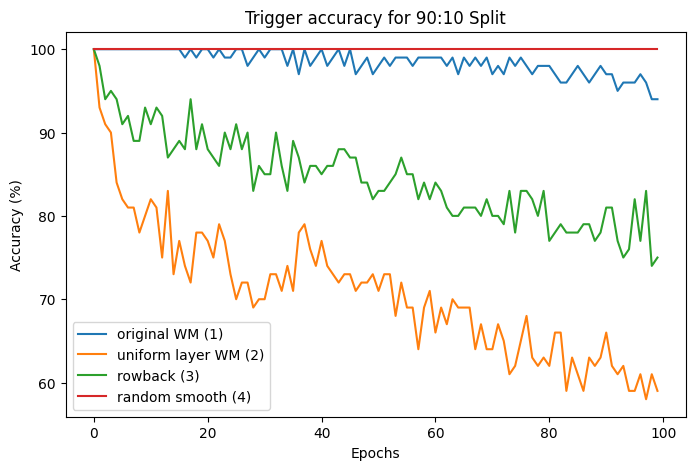

In [18]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metrics2['trigger_acc'])), metrics2['trigger_acc'], label='original WM (1)')
plt.plot(range(len(metrics3['trigger_acc'])), metrics3['trigger_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics4['trigger_acc'])), metrics4['trigger_acc'], label='rowback (3)')

plt.plot(range(len(metrics1['trigger_acc'])), metrics1['trigger_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Trigger accuracy for 90:10 Split')
plt.legend()
plt.savefig('incre_trigger_acc.png')

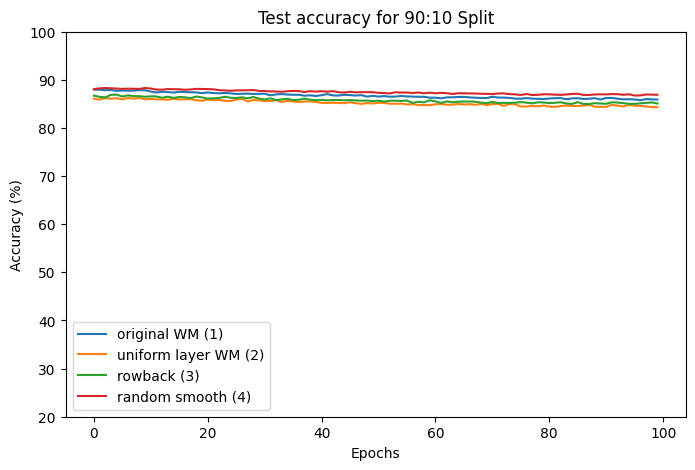

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(metrics2['val_acc'])), metrics2['val_acc'], label='original WM (1)')
plt.plot(range(len(metrics3['val_acc'])), metrics3['val_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics4['val_acc'])), metrics4['val_acc'], label='rowback (3)')

plt.plot(range(len(metrics1['val_acc'])), metrics1['val_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test accuracy for 90:10 Split')
plt.ylim([20, 100])

plt.legend()

plt.savefig('incre_test_acc.png')

80:20 Split

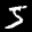

torch.Size([3, 32, 32])


In [20]:
batch_size_train = 256
batch_size_test = 256
batch_size_wm = 64

trainset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/train/', transform=transform_train)
incset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/train_incre/', transform=transform_train)
testset = datasets.ImageFolder('./data/CIFAR10_8020/test', transform=transform_test)
# valset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/val/', transform=transform_test)
watermarkset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/trigger_random/', transform=transform_test)
advwatermarkset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/trigger_adv/', transform=transform_test)

unrelatedset = watermark_unrelated(count=100)
train_watermark_mixset = torch.utils.data.ConcatDataset((trainset,unrelatedset))


# testset = torchvision.datasets.CIFAR10(
#     root='./data', train=False, download=True, transform=transform_test)

unrelatedloader = torch.utils.data.DataLoader(
    unrelatedset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=8)

# valloader = torch.utils.data.DataLoader(
    # valset, batch_size=batch_size_test, shuffle=False, num_workers=8)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

incloader = torch.utils.data.DataLoader(
    incset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

wmloader = torch.utils.data.DataLoader(
    watermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
advwmloader = torch.utils.data.DataLoader(
    advwatermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
train_watermark_loader = torch.utils.data.DataLoader(
    train_watermark_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

In [21]:
## Sanity Check
print(f"Length of trainset {len(trainset)}")
print(f"Length of incset {len(incset)}")
print(f"Length of testset {len(testset)}")
# print(f"Length of # valset {len(# valset)}")
print(f"Length of watermarkset {len(watermarkset)}")
print(f"Length of advwatermarkset {len(advwatermarkset)}")

Length of trainset 39920
Length of incset 9980
Length of testset 10000
Length of watermarkset 100
Length of advwatermarkset 100


In [22]:
net5 = ResNet18()
net5.load_state_dict(torch.load('./models/wm_cifar10_certify_random_8020.pth')['model_state_dict'])
net6 = ResNet18()
net6.load_state_dict(torch.load('./checkpoints/resnet18_wm_8020.ckpt'))
net7 = ResNet18()
net7.load_state_dict(torch.load('./checkpoints/resnet18_wm_frozen_8020.ckpt'))
net8 = ResNet18()
net8.load_state_dict(torch.load('./checkpoints/resnet18_wm_rowback_8020.ckpt'))

<All keys matched successfully>

In [23]:
evaluator = Evaluator(net5, torch.nn.CrossEntropyLoss())
print(evaluator.eval(testloader))
print(evaluator.eval(unrelatedloader))

{'loss': 0.6361623308522627, 'accuracy': 86.85000000000001}
{'loss': 7.469763086191961e-06, 'accuracy': 100.0}


In [24]:
evaluator = Evaluator(net6, torch.nn.CrossEntropyLoss())
print("Original watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

Original watermarking scheme
Test accuracy {'loss': 0.4788358686566353, 'accuracy': 87.21}
Watermark accuracy {'loss': 0.00012970328127266838, 'accuracy': 100.0}


In [25]:
evaluator = Evaluator(net7, torch.nn.CrossEntropyLoss())
print("Frozen watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

Frozen watermarking scheme
Test accuracy {'loss': 0.500207846736908, 'accuracy': 86.39}
Watermark accuracy {'loss': 0.0006738025182858109, 'accuracy': 100.0}


In [26]:
evaluator = Evaluator(net8, torch.nn.CrossEntropyLoss())
print("ROWBack watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(advwmloader)}")

ROWBack watermarking scheme
Test accuracy {'loss': 0.5166996634483337, 'accuracy': 86.39}
Watermark accuracy {'loss': 0.0006330490182153881, 'accuracy': 100.0}


In [27]:
logcmt = f"incre_train_certified_8020"

optimizer5 = torch.optim.SGD(lr=0.001, params=net5.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer5 = Trainer(net5, criterion, optimizer5, incloader)
evaluator5 = Evaluator(net5, criterion)

metrics5 = train(trainer5, evaluator5, testloader, savename='inccheckpoints/incre_train_cert_8020', logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:09<00:00,  4.33it/s]


Epoch 0 | Time 10s| Train Loss 0.5427 | Train Acc 87.63| Val Loss 0.612 | Val Acc 87.06| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 1 | Time 17s| Train Loss 0.4730 | Train Acc 88.17| Val Loss 0.601 | Val Acc 86.98| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.33it/s]


Epoch 2 | Time 22s| Train Loss 0.4256 | Train Acc 88.96| Val Loss 0.575 | Val Acc 87.07| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 3 | Time 28s| Train Loss 0.4100 | Train Acc 89.00| Val Loss 0.567 | Val Acc 87.02| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 4 | Time 33s| Train Loss 0.3841 | Train Acc 89.03| Val Loss 0.546 | Val Acc 87.08| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 5 | Time 38s| Train Loss 0.3587 | Train Acc 89.75| Val Loss 0.542 | Val Acc 87.18| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.20it/s]


Epoch 6 | Time 44s| Train Loss 0.3376 | Train Acc 89.66| Val Loss 0.529 | Val Acc 87.08| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 7 | Time 50s| Train Loss 0.3242 | Train Acc 90.29| Val Loss 0.527 | Val Acc 87.08| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 8 | Time 55s| Train Loss 0.3133 | Train Acc 90.19| Val Loss 0.521 | Val Acc 86.91| Trigger Loss 0.004 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 9 | Time 61s| Train Loss 0.3061 | Train Acc 90.48| Val Loss 0.515 | Val Acc 87.09| Trigger Loss 0.006 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 10 | Time 66s| Train Loss 0.2903 | Train Acc 90.88| Val Loss 0.507 | Val Acc 87.17| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 11 | Time 71s| Train Loss 0.2866 | Train Acc 91.33| Val Loss 0.502 | Val Acc 87.08| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 12 | Time 77s| Train Loss 0.2751 | Train Acc 91.29| Val Loss 0.500 | Val Acc 87.11| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 13 | Time 82s| Train Loss 0.2768 | Train Acc 91.07| Val Loss 0.496 | Val Acc 87.05| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 14 | Time 88s| Train Loss 0.2525 | Train Acc 91.95| Val Loss 0.496 | Val Acc 87.10| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 15 | Time 93s| Train Loss 0.2482 | Train Acc 92.07| Val Loss 0.495 | Val Acc 87.07| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 16 | Time 99s| Train Loss 0.2480 | Train Acc 91.77| Val Loss 0.497 | Val Acc 87.07| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.20it/s]


Epoch 17 | Time 104s| Train Loss 0.2415 | Train Acc 91.84| Val Loss 0.492 | Val Acc 86.92| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.35it/s]


Epoch 18 | Time 110s| Train Loss 0.2334 | Train Acc 92.15| Val Loss 0.491 | Val Acc 86.97| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 19 | Time 115s| Train Loss 0.2235 | Train Acc 92.71| Val Loss 0.491 | Val Acc 86.96| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 20 | Time 121s| Train Loss 0.2190 | Train Acc 92.68| Val Loss 0.494 | Val Acc 86.97| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 21 | Time 126s| Train Loss 0.2140 | Train Acc 92.91| Val Loss 0.493 | Val Acc 87.16| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.21it/s]


Epoch 22 | Time 132s| Train Loss 0.2096 | Train Acc 93.02| Val Loss 0.490 | Val Acc 87.06| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 23 | Time 137s| Train Loss 0.2103 | Train Acc 93.00| Val Loss 0.489 | Val Acc 87.10| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.13it/s]


Epoch 24 | Time 143s| Train Loss 0.1926 | Train Acc 93.62| Val Loss 0.493 | Val Acc 87.05| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 25 | Time 148s| Train Loss 0.2007 | Train Acc 93.54| Val Loss 0.490 | Val Acc 87.26| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 26 | Time 154s| Train Loss 0.1941 | Train Acc 93.41| Val Loss 0.486 | Val Acc 87.15| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 27 | Time 159s| Train Loss 0.1914 | Train Acc 93.60| Val Loss 0.491 | Val Acc 87.16| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 28 | Time 165s| Train Loss 0.1905 | Train Acc 93.60| Val Loss 0.492 | Val Acc 87.01| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 29 | Time 170s| Train Loss 0.1792 | Train Acc 94.01| Val Loss 0.496 | Val Acc 86.93| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.19it/s]


Epoch 30 | Time 176s| Train Loss 0.1746 | Train Acc 94.19| Val Loss 0.490 | Val Acc 86.86| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 31 | Time 181s| Train Loss 0.1754 | Train Acc 94.26| Val Loss 0.496 | Val Acc 86.88| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 32 | Time 187s| Train Loss 0.1726 | Train Acc 94.31| Val Loss 0.496 | Val Acc 87.02| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 33 | Time 192s| Train Loss 0.1707 | Train Acc 94.18| Val Loss 0.495 | Val Acc 87.05| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 34 | Time 198s| Train Loss 0.1651 | Train Acc 94.56| Val Loss 0.497 | Val Acc 86.99| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 35 | Time 203s| Train Loss 0.1583 | Train Acc 94.79| Val Loss 0.495 | Val Acc 87.03| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.17it/s]


Epoch 36 | Time 209s| Train Loss 0.1563 | Train Acc 94.60| Val Loss 0.502 | Val Acc 87.11| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 37 | Time 214s| Train Loss 0.1571 | Train Acc 94.77| Val Loss 0.502 | Val Acc 86.96| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 38 | Time 219s| Train Loss 0.1508 | Train Acc 94.88| Val Loss 0.501 | Val Acc 87.07| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 39 | Time 225s| Train Loss 0.1487 | Train Acc 95.08| Val Loss 0.512 | Val Acc 86.98| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 40 | Time 230s| Train Loss 0.1419 | Train Acc 95.39| Val Loss 0.508 | Val Acc 87.02| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 41 | Time 236s| Train Loss 0.1430 | Train Acc 95.27| Val Loss 0.513 | Val Acc 86.91| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 42 | Time 241s| Train Loss 0.1404 | Train Acc 95.38| Val Loss 0.513 | Val Acc 87.04| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 43 | Time 247s| Train Loss 0.1345 | Train Acc 95.60| Val Loss 0.515 | Val Acc 86.94| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 44 | Time 252s| Train Loss 0.1283 | Train Acc 95.66| Val Loss 0.517 | Val Acc 86.95| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.35it/s]


Epoch 45 | Time 258s| Train Loss 0.1303 | Train Acc 95.66| Val Loss 0.515 | Val Acc 86.88| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 46 | Time 263s| Train Loss 0.1344 | Train Acc 95.65| Val Loss 0.516 | Val Acc 86.92| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.21it/s]


Epoch 47 | Time 269s| Train Loss 0.1336 | Train Acc 95.46| Val Loss 0.520 | Val Acc 86.82| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.17it/s]


Epoch 48 | Time 274s| Train Loss 0.1290 | Train Acc 95.83| Val Loss 0.521 | Val Acc 86.83| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 49 | Time 280s| Train Loss 0.1264 | Train Acc 95.77| Val Loss 0.523 | Val Acc 86.77| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 50 | Time 285s| Train Loss 0.1222 | Train Acc 95.93| Val Loss 0.525 | Val Acc 86.80| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 51 | Time 291s| Train Loss 0.1134 | Train Acc 96.30| Val Loss 0.524 | Val Acc 86.89| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.21it/s]


Epoch 52 | Time 296s| Train Loss 0.1164 | Train Acc 96.14| Val Loss 0.531 | Val Acc 86.65| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 53 | Time 302s| Train Loss 0.1146 | Train Acc 96.36| Val Loss 0.531 | Val Acc 86.82| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.33it/s]


Epoch 54 | Time 307s| Train Loss 0.1141 | Train Acc 96.06| Val Loss 0.536 | Val Acc 86.79| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 55 | Time 312s| Train Loss 0.1071 | Train Acc 96.45| Val Loss 0.539 | Val Acc 86.81| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 56 | Time 318s| Train Loss 0.1098 | Train Acc 96.41| Val Loss 0.542 | Val Acc 86.68| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.02it/s]


Epoch 57 | Time 324s| Train Loss 0.1054 | Train Acc 96.67| Val Loss 0.539 | Val Acc 86.84| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 58 | Time 329s| Train Loss 0.1007 | Train Acc 96.67| Val Loss 0.546 | Val Acc 86.64| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 59 | Time 335s| Train Loss 0.1025 | Train Acc 96.54| Val Loss 0.551 | Val Acc 86.50| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 60 | Time 340s| Train Loss 0.0978 | Train Acc 96.91| Val Loss 0.547 | Val Acc 86.79| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.36it/s]


Epoch 61 | Time 346s| Train Loss 0.0926 | Train Acc 96.93| Val Loss 0.552 | Val Acc 86.67| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 62 | Time 351s| Train Loss 0.0945 | Train Acc 96.80| Val Loss 0.554 | Val Acc 86.55| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 63 | Time 357s| Train Loss 0.0905 | Train Acc 97.07| Val Loss 0.555 | Val Acc 86.59| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 64 | Time 362s| Train Loss 0.0868 | Train Acc 97.15| Val Loss 0.557 | Val Acc 86.63| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 65 | Time 368s| Train Loss 0.0953 | Train Acc 97.08| Val Loss 0.564 | Val Acc 86.64| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 66 | Time 373s| Train Loss 0.0911 | Train Acc 97.07| Val Loss 0.561 | Val Acc 86.50| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 67 | Time 379s| Train Loss 0.0848 | Train Acc 97.40| Val Loss 0.562 | Val Acc 86.54| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.33it/s]


Epoch 68 | Time 384s| Train Loss 0.0796 | Train Acc 97.45| Val Loss 0.565 | Val Acc 86.54| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 69 | Time 389s| Train Loss 0.0817 | Train Acc 97.45| Val Loss 0.569 | Val Acc 86.60| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 70 | Time 395s| Train Loss 0.0812 | Train Acc 97.39| Val Loss 0.570 | Val Acc 86.47| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 71 | Time 400s| Train Loss 0.0781 | Train Acc 97.56| Val Loss 0.574 | Val Acc 86.62| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 72 | Time 406s| Train Loss 0.0739 | Train Acc 97.57| Val Loss 0.577 | Val Acc 86.46| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 73 | Time 412s| Train Loss 0.0732 | Train Acc 97.78| Val Loss 0.584 | Val Acc 86.39| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 74 | Time 417s| Train Loss 0.0750 | Train Acc 97.60| Val Loss 0.579 | Val Acc 86.46| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 75 | Time 423s| Train Loss 0.0717 | Train Acc 97.86| Val Loss 0.584 | Val Acc 86.41| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 76 | Time 428s| Train Loss 0.0721 | Train Acc 97.90| Val Loss 0.585 | Val Acc 86.28| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.21it/s]


Epoch 77 | Time 433s| Train Loss 0.0704 | Train Acc 97.89| Val Loss 0.584 | Val Acc 86.37| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 78 | Time 439s| Train Loss 0.0688 | Train Acc 97.69| Val Loss 0.593 | Val Acc 86.29| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 79 | Time 444s| Train Loss 0.0689 | Train Acc 97.97| Val Loss 0.589 | Val Acc 86.32| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.15it/s]


Epoch 80 | Time 450s| Train Loss 0.0681 | Train Acc 97.92| Val Loss 0.599 | Val Acc 86.28| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 81 | Time 455s| Train Loss 0.0654 | Train Acc 98.13| Val Loss 0.594 | Val Acc 86.37| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 82 | Time 461s| Train Loss 0.0644 | Train Acc 97.86| Val Loss 0.603 | Val Acc 86.40| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 83 | Time 466s| Train Loss 0.0622 | Train Acc 98.20| Val Loss 0.603 | Val Acc 86.28| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 84 | Time 472s| Train Loss 0.0652 | Train Acc 98.11| Val Loss 0.609 | Val Acc 86.22| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 85 | Time 477s| Train Loss 0.0586 | Train Acc 98.23| Val Loss 0.607 | Val Acc 86.44| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 86 | Time 483s| Train Loss 0.0568 | Train Acc 98.41| Val Loss 0.606 | Val Acc 86.30| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 87 | Time 488s| Train Loss 0.0535 | Train Acc 98.39| Val Loss 0.613 | Val Acc 86.34| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 88 | Time 494s| Train Loss 0.0554 | Train Acc 98.33| Val Loss 0.613 | Val Acc 86.18| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 89 | Time 499s| Train Loss 0.0553 | Train Acc 98.45| Val Loss 0.615 | Val Acc 86.28| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 90 | Time 505s| Train Loss 0.0523 | Train Acc 98.60| Val Loss 0.618 | Val Acc 86.10| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 91 | Time 510s| Train Loss 0.0571 | Train Acc 98.21| Val Loss 0.616 | Val Acc 86.18| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 92 | Time 516s| Train Loss 0.0470 | Train Acc 98.75| Val Loss 0.622 | Val Acc 86.01| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 93 | Time 521s| Train Loss 0.0499 | Train Acc 98.67| Val Loss 0.628 | Val Acc 86.04| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.35it/s]


Epoch 94 | Time 527s| Train Loss 0.0503 | Train Acc 98.55| Val Loss 0.626 | Val Acc 86.02| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 95 | Time 532s| Train Loss 0.0506 | Train Acc 98.54| Val Loss 0.629 | Val Acc 86.13| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 96 | Time 538s| Train Loss 0.0482 | Train Acc 98.72| Val Loss 0.641 | Val Acc 86.05| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 97 | Time 543s| Train Loss 0.0493 | Train Acc 98.59| Val Loss 0.638 | Val Acc 86.10| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.39it/s]


Epoch 98 | Time 549s| Train Loss 0.0480 | Train Acc 98.54| Val Loss 0.636 | Val Acc 86.07| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 99 | Time 554s| Train Loss 0.0484 | Train Acc 98.59| Val Loss 0.634 | Val Acc 86.03| Trigger Loss 0.000 | Trigger Acc 100.00


In [28]:
logcmt = f"incre_train_baseline_8020"

optimizer6 = torch.optim.SGD(lr=0.001, params=net6.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer6 = Trainer(net6, criterion, optimizer6, incloader)
evaluator6 = Evaluator(net6, criterion)

metrics6 = train(trainer6, evaluator6, testloader, savename='inccheckpoints/incre_train_baseline_8020', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 0 | Time 5s| Train Loss 0.4428 | Train Acc 87.27| Val Loss 0.488 | Val Acc 87.01| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 1 | Time 11s| Train Loss 0.4134 | Train Acc 87.55| Val Loss 0.471 | Val Acc 87.14| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 2 | Time 17s| Train Loss 0.3852 | Train Acc 87.97| Val Loss 0.462 | Val Acc 87.08| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 3 | Time 22s| Train Loss 0.3695 | Train Acc 88.23| Val Loss 0.457 | Val Acc 87.17| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.16it/s]


Epoch 4 | Time 28s| Train Loss 0.3478 | Train Acc 88.88| Val Loss 0.448 | Val Acc 87.16| Trigger Loss 0.005 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.21it/s]


Epoch 5 | Time 33s| Train Loss 0.3379 | Train Acc 89.11| Val Loss 0.452 | Val Acc 87.01| Trigger Loss 0.008 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 6 | Time 39s| Train Loss 0.3246 | Train Acc 89.42| Val Loss 0.438 | Val Acc 87.17| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 7 | Time 44s| Train Loss 0.3111 | Train Acc 89.73| Val Loss 0.439 | Val Acc 87.04| Trigger Loss 0.020 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 8 | Time 49s| Train Loss 0.2991 | Train Acc 90.04| Val Loss 0.435 | Val Acc 87.24| Trigger Loss 0.035 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 9 | Time 55s| Train Loss 0.2973 | Train Acc 90.06| Val Loss 0.432 | Val Acc 87.21| Trigger Loss 0.024 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 10 | Time 60s| Train Loss 0.2904 | Train Acc 90.36| Val Loss 0.424 | Val Acc 87.42| Trigger Loss 0.027 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 11 | Time 65s| Train Loss 0.2813 | Train Acc 90.19| Val Loss 0.424 | Val Acc 87.41| Trigger Loss 0.016 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.20it/s]


Epoch 12 | Time 70s| Train Loss 0.2695 | Train Acc 90.85| Val Loss 0.430 | Val Acc 86.82| Trigger Loss 0.028 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.20it/s]


Epoch 13 | Time 75s| Train Loss 0.2687 | Train Acc 90.76| Val Loss 0.424 | Val Acc 87.33| Trigger Loss 0.032 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 14 | Time 81s| Train Loss 0.2667 | Train Acc 91.17| Val Loss 0.420 | Val Acc 87.36| Trigger Loss 0.022 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 15 | Time 86s| Train Loss 0.2614 | Train Acc 90.97| Val Loss 0.423 | Val Acc 87.26| Trigger Loss 0.029 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 16 | Time 91s| Train Loss 0.2543 | Train Acc 91.26| Val Loss 0.427 | Val Acc 87.31| Trigger Loss 0.024 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.21it/s]


Epoch 17 | Time 96s| Train Loss 0.2525 | Train Acc 91.10| Val Loss 0.423 | Val Acc 87.48| Trigger Loss 0.036 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 18 | Time 101s| Train Loss 0.2478 | Train Acc 91.40| Val Loss 0.424 | Val Acc 87.10| Trigger Loss 0.019 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.19it/s]


Epoch 19 | Time 106s| Train Loss 0.2432 | Train Acc 91.81| Val Loss 0.426 | Val Acc 87.22| Trigger Loss 0.054 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 20 | Time 112s| Train Loss 0.2343 | Train Acc 92.10| Val Loss 0.424 | Val Acc 87.42| Trigger Loss 0.033 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.20it/s]


Epoch 21 | Time 117s| Train Loss 0.2302 | Train Acc 91.94| Val Loss 0.423 | Val Acc 87.59| Trigger Loss 0.047 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.18it/s]


Epoch 22 | Time 122s| Train Loss 0.2313 | Train Acc 91.70| Val Loss 0.426 | Val Acc 87.36| Trigger Loss 0.036 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 23 | Time 127s| Train Loss 0.2205 | Train Acc 92.48| Val Loss 0.426 | Val Acc 87.30| Trigger Loss 0.035 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 24 | Time 132s| Train Loss 0.2214 | Train Acc 92.29| Val Loss 0.429 | Val Acc 87.19| Trigger Loss 0.045 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 25 | Time 138s| Train Loss 0.2227 | Train Acc 92.44| Val Loss 0.436 | Val Acc 87.14| Trigger Loss 0.047 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 26 | Time 143s| Train Loss 0.2161 | Train Acc 92.86| Val Loss 0.433 | Val Acc 87.22| Trigger Loss 0.037 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.19it/s]


Epoch 27 | Time 148s| Train Loss 0.2090 | Train Acc 93.00| Val Loss 0.431 | Val Acc 87.24| Trigger Loss 0.028 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 28 | Time 153s| Train Loss 0.2020 | Train Acc 93.34| Val Loss 0.434 | Val Acc 87.22| Trigger Loss 0.023 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 29 | Time 158s| Train Loss 0.2035 | Train Acc 93.16| Val Loss 0.435 | Val Acc 87.29| Trigger Loss 0.031 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.14it/s]


Epoch 30 | Time 164s| Train Loss 0.2004 | Train Acc 93.62| Val Loss 0.439 | Val Acc 87.17| Trigger Loss 0.039 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 31 | Time 169s| Train Loss 0.1980 | Train Acc 93.32| Val Loss 0.439 | Val Acc 87.16| Trigger Loss 0.027 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 32 | Time 174s| Train Loss 0.1937 | Train Acc 93.41| Val Loss 0.438 | Val Acc 87.24| Trigger Loss 0.049 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.19it/s]


Epoch 33 | Time 179s| Train Loss 0.1899 | Train Acc 93.45| Val Loss 0.444 | Val Acc 87.19| Trigger Loss 0.067 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 34 | Time 184s| Train Loss 0.1972 | Train Acc 93.37| Val Loss 0.444 | Val Acc 86.98| Trigger Loss 0.069 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 35 | Time 190s| Train Loss 0.1838 | Train Acc 93.82| Val Loss 0.444 | Val Acc 87.17| Trigger Loss 0.070 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 36 | Time 195s| Train Loss 0.1899 | Train Acc 93.67| Val Loss 0.442 | Val Acc 87.11| Trigger Loss 0.054 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.20it/s]


Epoch 37 | Time 200s| Train Loss 0.1815 | Train Acc 93.58| Val Loss 0.447 | Val Acc 87.09| Trigger Loss 0.067 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.17it/s]


Epoch 38 | Time 205s| Train Loss 0.1796 | Train Acc 94.10| Val Loss 0.447 | Val Acc 87.14| Trigger Loss 0.065 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 39 | Time 211s| Train Loss 0.1753 | Train Acc 94.11| Val Loss 0.448 | Val Acc 87.12| Trigger Loss 0.062 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 40 | Time 216s| Train Loss 0.1698 | Train Acc 94.36| Val Loss 0.449 | Val Acc 87.09| Trigger Loss 0.050 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.18it/s]


Epoch 41 | Time 221s| Train Loss 0.1637 | Train Acc 94.77| Val Loss 0.451 | Val Acc 87.19| Trigger Loss 0.041 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 42 | Time 226s| Train Loss 0.1709 | Train Acc 94.16| Val Loss 0.454 | Val Acc 87.15| Trigger Loss 0.054 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 43 | Time 231s| Train Loss 0.1615 | Train Acc 94.85| Val Loss 0.458 | Val Acc 87.04| Trigger Loss 0.064 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 44 | Time 236s| Train Loss 0.1624 | Train Acc 94.69| Val Loss 0.463 | Val Acc 86.90| Trigger Loss 0.061 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.20it/s]


Epoch 45 | Time 242s| Train Loss 0.1582 | Train Acc 94.78| Val Loss 0.464 | Val Acc 87.17| Trigger Loss 0.072 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 46 | Time 247s| Train Loss 0.1639 | Train Acc 94.39| Val Loss 0.462 | Val Acc 87.16| Trigger Loss 0.065 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 47 | Time 252s| Train Loss 0.1550 | Train Acc 94.84| Val Loss 0.464 | Val Acc 87.31| Trigger Loss 0.078 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 48 | Time 257s| Train Loss 0.1471 | Train Acc 95.16| Val Loss 0.464 | Val Acc 87.05| Trigger Loss 0.062 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 49 | Time 262s| Train Loss 0.1528 | Train Acc 94.91| Val Loss 0.471 | Val Acc 87.10| Trigger Loss 0.056 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 50 | Time 268s| Train Loss 0.1457 | Train Acc 95.26| Val Loss 0.471 | Val Acc 86.97| Trigger Loss 0.060 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 51 | Time 273s| Train Loss 0.1453 | Train Acc 95.03| Val Loss 0.477 | Val Acc 86.88| Trigger Loss 0.050 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 52 | Time 278s| Train Loss 0.1390 | Train Acc 95.53| Val Loss 0.474 | Val Acc 87.11| Trigger Loss 0.058 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.12it/s]


Epoch 53 | Time 283s| Train Loss 0.1422 | Train Acc 95.21| Val Loss 0.477 | Val Acc 86.92| Trigger Loss 0.058 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 54 | Time 288s| Train Loss 0.1346 | Train Acc 95.62| Val Loss 0.478 | Val Acc 87.11| Trigger Loss 0.067 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 55 | Time 294s| Train Loss 0.1377 | Train Acc 95.55| Val Loss 0.486 | Val Acc 86.92| Trigger Loss 0.064 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 56 | Time 299s| Train Loss 0.1267 | Train Acc 95.87| Val Loss 0.487 | Val Acc 86.68| Trigger Loss 0.062 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 57 | Time 304s| Train Loss 0.1321 | Train Acc 95.49| Val Loss 0.488 | Val Acc 86.88| Trigger Loss 0.069 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 58 | Time 309s| Train Loss 0.1324 | Train Acc 95.54| Val Loss 0.491 | Val Acc 86.77| Trigger Loss 0.077 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 59 | Time 314s| Train Loss 0.1236 | Train Acc 96.11| Val Loss 0.497 | Val Acc 86.68| Trigger Loss 0.068 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.18it/s]


Epoch 60 | Time 319s| Train Loss 0.1241 | Train Acc 95.97| Val Loss 0.493 | Val Acc 86.93| Trigger Loss 0.069 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.16it/s]


Epoch 61 | Time 325s| Train Loss 0.1251 | Train Acc 95.89| Val Loss 0.499 | Val Acc 86.73| Trigger Loss 0.066 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 62 | Time 330s| Train Loss 0.1184 | Train Acc 96.30| Val Loss 0.499 | Val Acc 86.87| Trigger Loss 0.083 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 63 | Time 335s| Train Loss 0.1218 | Train Acc 96.08| Val Loss 0.501 | Val Acc 86.67| Trigger Loss 0.078 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 64 | Time 340s| Train Loss 0.1199 | Train Acc 95.91| Val Loss 0.503 | Val Acc 86.67| Trigger Loss 0.100 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 65 | Time 345s| Train Loss 0.1065 | Train Acc 96.68| Val Loss 0.506 | Val Acc 86.87| Trigger Loss 0.072 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 66 | Time 351s| Train Loss 0.1121 | Train Acc 96.34| Val Loss 0.507 | Val Acc 86.67| Trigger Loss 0.094 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 67 | Time 356s| Train Loss 0.1080 | Train Acc 96.50| Val Loss 0.512 | Val Acc 86.82| Trigger Loss 0.073 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 68 | Time 361s| Train Loss 0.1114 | Train Acc 96.51| Val Loss 0.515 | Val Acc 86.71| Trigger Loss 0.079 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 69 | Time 366s| Train Loss 0.1054 | Train Acc 96.49| Val Loss 0.520 | Val Acc 86.59| Trigger Loss 0.089 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 70 | Time 371s| Train Loss 0.1040 | Train Acc 96.80| Val Loss 0.518 | Val Acc 86.85| Trigger Loss 0.085 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 71 | Time 377s| Train Loss 0.0998 | Train Acc 96.61| Val Loss 0.517 | Val Acc 86.71| Trigger Loss 0.071 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 72 | Time 382s| Train Loss 0.1006 | Train Acc 96.77| Val Loss 0.526 | Val Acc 86.82| Trigger Loss 0.090 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 73 | Time 387s| Train Loss 0.0985 | Train Acc 96.89| Val Loss 0.526 | Val Acc 86.56| Trigger Loss 0.077 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 74 | Time 392s| Train Loss 0.0929 | Train Acc 97.13| Val Loss 0.527 | Val Acc 86.79| Trigger Loss 0.092 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 75 | Time 397s| Train Loss 0.0968 | Train Acc 96.88| Val Loss 0.532 | Val Acc 86.57| Trigger Loss 0.069 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 76 | Time 403s| Train Loss 0.0955 | Train Acc 97.07| Val Loss 0.537 | Val Acc 86.47| Trigger Loss 0.103 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 77 | Time 408s| Train Loss 0.0906 | Train Acc 97.23| Val Loss 0.533 | Val Acc 86.56| Trigger Loss 0.111 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 78 | Time 413s| Train Loss 0.0913 | Train Acc 97.13| Val Loss 0.537 | Val Acc 86.42| Trigger Loss 0.099 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.21it/s]


Epoch 79 | Time 418s| Train Loss 0.0884 | Train Acc 97.21| Val Loss 0.537 | Val Acc 86.55| Trigger Loss 0.100 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.19it/s]


Epoch 80 | Time 423s| Train Loss 0.0831 | Train Acc 97.49| Val Loss 0.539 | Val Acc 86.60| Trigger Loss 0.104 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 81 | Time 428s| Train Loss 0.0858 | Train Acc 97.15| Val Loss 0.542 | Val Acc 86.70| Trigger Loss 0.113 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.18it/s]


Epoch 82 | Time 434s| Train Loss 0.0802 | Train Acc 97.59| Val Loss 0.544 | Val Acc 86.54| Trigger Loss 0.122 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 83 | Time 439s| Train Loss 0.0833 | Train Acc 97.37| Val Loss 0.550 | Val Acc 86.65| Trigger Loss 0.121 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.19it/s]


Epoch 84 | Time 444s| Train Loss 0.0829 | Train Acc 97.34| Val Loss 0.552 | Val Acc 86.67| Trigger Loss 0.128 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 85 | Time 449s| Train Loss 0.0818 | Train Acc 97.52| Val Loss 0.560 | Val Acc 86.42| Trigger Loss 0.119 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.13it/s]


Epoch 86 | Time 455s| Train Loss 0.0749 | Train Acc 97.67| Val Loss 0.556 | Val Acc 86.54| Trigger Loss 0.137 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 87 | Time 460s| Train Loss 0.0771 | Train Acc 97.81| Val Loss 0.564 | Val Acc 86.46| Trigger Loss 0.124 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 88 | Time 465s| Train Loss 0.0735 | Train Acc 97.88| Val Loss 0.565 | Val Acc 86.36| Trigger Loss 0.118 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 89 | Time 470s| Train Loss 0.0743 | Train Acc 97.96| Val Loss 0.561 | Val Acc 86.73| Trigger Loss 0.104 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 90 | Time 475s| Train Loss 0.0739 | Train Acc 97.80| Val Loss 0.566 | Val Acc 86.46| Trigger Loss 0.124 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.20it/s]


Epoch 91 | Time 480s| Train Loss 0.0717 | Train Acc 97.71| Val Loss 0.569 | Val Acc 86.46| Trigger Loss 0.129 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 92 | Time 486s| Train Loss 0.0698 | Train Acc 97.88| Val Loss 0.568 | Val Acc 86.45| Trigger Loss 0.150 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 93 | Time 491s| Train Loss 0.0698 | Train Acc 97.86| Val Loss 0.571 | Val Acc 86.42| Trigger Loss 0.129 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 94 | Time 496s| Train Loss 0.0697 | Train Acc 98.01| Val Loss 0.576 | Val Acc 86.69| Trigger Loss 0.140 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 95 | Time 501s| Train Loss 0.0647 | Train Acc 98.14| Val Loss 0.568 | Val Acc 86.72| Trigger Loss 0.127 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 96 | Time 506s| Train Loss 0.0641 | Train Acc 98.29| Val Loss 0.576 | Val Acc 86.53| Trigger Loss 0.142 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.18it/s]


Epoch 97 | Time 512s| Train Loss 0.0644 | Train Acc 97.95| Val Loss 0.580 | Val Acc 86.59| Trigger Loss 0.160 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 98 | Time 517s| Train Loss 0.0643 | Train Acc 98.18| Val Loss 0.582 | Val Acc 86.47| Trigger Loss 0.194 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 99 | Time 522s| Train Loss 0.0569 | Train Acc 98.25| Val Loss 0.587 | Val Acc 86.46| Trigger Loss 0.153 | Trigger Acc 95.00


In [29]:
logcmt = f"incre_train_baseline_frozen_8020"

optimizer7 = torch.optim.SGD(lr=0.001, params=net7.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer7 = Trainer(net7, criterion, optimizer7, incloader)
evaluator7 = Evaluator(net7, criterion)

metrics7 = train(trainer7, evaluator7, testloader, savename='inccheckpoints/incre_train_baseline_frozen_8020', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 0 | Time 5s| Train Loss 0.4733 | Train Acc 85.80| Val Loss 0.524 | Val Acc 85.74| Trigger Loss 0.125 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.21it/s]


Epoch 1 | Time 11s| Train Loss 0.4280 | Train Acc 86.89| Val Loss 0.491 | Val Acc 86.08| Trigger Loss 0.460 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 2 | Time 16s| Train Loss 0.4035 | Train Acc 87.51| Val Loss 0.486 | Val Acc 86.10| Trigger Loss 0.432 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 3 | Time 21s| Train Loss 0.3705 | Train Acc 88.12| Val Loss 0.477 | Val Acc 85.90| Trigger Loss 0.574 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 4 | Time 27s| Train Loss 0.3632 | Train Acc 88.10| Val Loss 0.473 | Val Acc 86.20| Trigger Loss 0.624 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 5 | Time 32s| Train Loss 0.3504 | Train Acc 88.65| Val Loss 0.462 | Val Acc 86.27| Trigger Loss 0.677 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.21it/s]


Epoch 6 | Time 37s| Train Loss 0.3351 | Train Acc 88.73| Val Loss 0.465 | Val Acc 86.17| Trigger Loss 0.679 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 7 | Time 42s| Train Loss 0.3346 | Train Acc 88.92| Val Loss 0.469 | Val Acc 86.18| Trigger Loss 0.768 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 8 | Time 47s| Train Loss 0.3164 | Train Acc 89.25| Val Loss 0.459 | Val Acc 86.56| Trigger Loss 0.805 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 9 | Time 53s| Train Loss 0.3074 | Train Acc 89.52| Val Loss 0.467 | Val Acc 86.39| Trigger Loss 0.777 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 10 | Time 58s| Train Loss 0.3019 | Train Acc 89.54| Val Loss 0.452 | Val Acc 86.25| Trigger Loss 0.844 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.20it/s]


Epoch 11 | Time 63s| Train Loss 0.3017 | Train Acc 89.73| Val Loss 0.460 | Val Acc 86.01| Trigger Loss 1.113 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 12 | Time 68s| Train Loss 0.2917 | Train Acc 89.72| Val Loss 0.465 | Val Acc 86.09| Trigger Loss 1.116 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 13 | Time 73s| Train Loss 0.2843 | Train Acc 90.26| Val Loss 0.452 | Val Acc 86.11| Trigger Loss 0.991 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 14 | Time 78s| Train Loss 0.2733 | Train Acc 90.66| Val Loss 0.457 | Val Acc 86.12| Trigger Loss 0.726 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 15 | Time 84s| Train Loss 0.2667 | Train Acc 90.83| Val Loss 0.452 | Val Acc 86.12| Trigger Loss 0.990 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 16 | Time 89s| Train Loss 0.2678 | Train Acc 90.84| Val Loss 0.455 | Val Acc 86.25| Trigger Loss 1.039 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 17 | Time 94s| Train Loss 0.2615 | Train Acc 91.18| Val Loss 0.459 | Val Acc 86.30| Trigger Loss 0.971 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.21it/s]


Epoch 18 | Time 99s| Train Loss 0.2547 | Train Acc 91.37| Val Loss 0.459 | Val Acc 86.05| Trigger Loss 1.015 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 19 | Time 104s| Train Loss 0.2481 | Train Acc 91.28| Val Loss 0.455 | Val Acc 86.06| Trigger Loss 0.962 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 20 | Time 110s| Train Loss 0.2397 | Train Acc 91.76| Val Loss 0.457 | Val Acc 86.08| Trigger Loss 0.933 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 21 | Time 115s| Train Loss 0.2295 | Train Acc 92.30| Val Loss 0.462 | Val Acc 85.97| Trigger Loss 1.078 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 22 | Time 120s| Train Loss 0.2352 | Train Acc 92.05| Val Loss 0.462 | Val Acc 86.27| Trigger Loss 0.882 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 23 | Time 125s| Train Loss 0.2362 | Train Acc 91.78| Val Loss 0.467 | Val Acc 86.06| Trigger Loss 1.115 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 24 | Time 130s| Train Loss 0.2227 | Train Acc 92.37| Val Loss 0.461 | Val Acc 86.16| Trigger Loss 1.108 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 25 | Time 136s| Train Loss 0.2212 | Train Acc 92.48| Val Loss 0.475 | Val Acc 85.76| Trigger Loss 1.034 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 26 | Time 141s| Train Loss 0.2334 | Train Acc 91.90| Val Loss 0.472 | Val Acc 86.18| Trigger Loss 1.295 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 27 | Time 146s| Train Loss 0.2192 | Train Acc 92.53| Val Loss 0.464 | Val Acc 86.03| Trigger Loss 1.265 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 28 | Time 151s| Train Loss 0.2101 | Train Acc 92.91| Val Loss 0.468 | Val Acc 86.03| Trigger Loss 1.131 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 29 | Time 156s| Train Loss 0.2071 | Train Acc 92.98| Val Loss 0.477 | Val Acc 85.93| Trigger Loss 1.150 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 30 | Time 162s| Train Loss 0.2012 | Train Acc 92.91| Val Loss 0.471 | Val Acc 86.11| Trigger Loss 1.132 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 31 | Time 167s| Train Loss 0.2032 | Train Acc 93.06| Val Loss 0.478 | Val Acc 85.80| Trigger Loss 1.033 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 32 | Time 172s| Train Loss 0.1992 | Train Acc 93.44| Val Loss 0.474 | Val Acc 86.12| Trigger Loss 1.037 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 33 | Time 177s| Train Loss 0.1873 | Train Acc 93.36| Val Loss 0.481 | Val Acc 85.93| Trigger Loss 1.106 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.19it/s]


Epoch 34 | Time 182s| Train Loss 0.1976 | Train Acc 93.23| Val Loss 0.487 | Val Acc 85.64| Trigger Loss 1.221 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 35 | Time 187s| Train Loss 0.1818 | Train Acc 93.92| Val Loss 0.483 | Val Acc 85.82| Trigger Loss 1.219 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 36 | Time 193s| Train Loss 0.1853 | Train Acc 93.85| Val Loss 0.486 | Val Acc 85.99| Trigger Loss 1.329 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 37 | Time 198s| Train Loss 0.1799 | Train Acc 94.14| Val Loss 0.482 | Val Acc 86.11| Trigger Loss 1.096 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.20it/s]


Epoch 38 | Time 203s| Train Loss 0.1754 | Train Acc 93.96| Val Loss 0.485 | Val Acc 86.05| Trigger Loss 1.244 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 39 | Time 208s| Train Loss 0.1770 | Train Acc 94.03| Val Loss 0.502 | Val Acc 85.72| Trigger Loss 1.298 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.20it/s]


Epoch 40 | Time 213s| Train Loss 0.1703 | Train Acc 94.21| Val Loss 0.504 | Val Acc 85.89| Trigger Loss 1.229 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 41 | Time 219s| Train Loss 0.1659 | Train Acc 94.73| Val Loss 0.498 | Val Acc 85.85| Trigger Loss 1.355 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 42 | Time 224s| Train Loss 0.1604 | Train Acc 94.76| Val Loss 0.506 | Val Acc 85.85| Trigger Loss 1.195 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 43 | Time 229s| Train Loss 0.1612 | Train Acc 94.66| Val Loss 0.508 | Val Acc 85.73| Trigger Loss 1.427 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 44 | Time 234s| Train Loss 0.1637 | Train Acc 94.43| Val Loss 0.507 | Val Acc 85.68| Trigger Loss 1.260 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.14it/s]


Epoch 45 | Time 239s| Train Loss 0.1646 | Train Acc 94.52| Val Loss 0.509 | Val Acc 85.67| Trigger Loss 1.292 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 46 | Time 245s| Train Loss 0.1574 | Train Acc 94.69| Val Loss 0.514 | Val Acc 85.56| Trigger Loss 1.354 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 47 | Time 250s| Train Loss 0.1533 | Train Acc 95.08| Val Loss 0.518 | Val Acc 85.47| Trigger Loss 1.319 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 48 | Time 255s| Train Loss 0.1488 | Train Acc 94.83| Val Loss 0.522 | Val Acc 85.42| Trigger Loss 1.368 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.18it/s]


Epoch 49 | Time 260s| Train Loss 0.1417 | Train Acc 95.40| Val Loss 0.522 | Val Acc 85.64| Trigger Loss 1.248 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 50 | Time 265s| Train Loss 0.1384 | Train Acc 95.59| Val Loss 0.522 | Val Acc 85.48| Trigger Loss 1.221 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 51 | Time 271s| Train Loss 0.1385 | Train Acc 95.58| Val Loss 0.525 | Val Acc 85.29| Trigger Loss 1.458 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 52 | Time 276s| Train Loss 0.1381 | Train Acc 95.58| Val Loss 0.527 | Val Acc 85.50| Trigger Loss 1.382 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.19it/s]


Epoch 53 | Time 281s| Train Loss 0.1303 | Train Acc 95.63| Val Loss 0.532 | Val Acc 85.59| Trigger Loss 1.504 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 54 | Time 286s| Train Loss 0.1340 | Train Acc 95.80| Val Loss 0.533 | Val Acc 85.48| Trigger Loss 1.482 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 55 | Time 291s| Train Loss 0.1262 | Train Acc 95.85| Val Loss 0.539 | Val Acc 85.23| Trigger Loss 1.506 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.15it/s]


Epoch 56 | Time 297s| Train Loss 0.1223 | Train Acc 96.22| Val Loss 0.538 | Val Acc 85.29| Trigger Loss 1.335 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 57 | Time 302s| Train Loss 0.1216 | Train Acc 96.10| Val Loss 0.542 | Val Acc 85.48| Trigger Loss 1.539 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.21it/s]


Epoch 58 | Time 307s| Train Loss 0.1201 | Train Acc 95.96| Val Loss 0.547 | Val Acc 85.51| Trigger Loss 1.730 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 59 | Time 312s| Train Loss 0.1148 | Train Acc 96.57| Val Loss 0.546 | Val Acc 85.46| Trigger Loss 1.574 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 60 | Time 317s| Train Loss 0.1196 | Train Acc 96.02| Val Loss 0.545 | Val Acc 85.41| Trigger Loss 1.817 | Trigger Acc 57.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 61 | Time 322s| Train Loss 0.1142 | Train Acc 96.43| Val Loss 0.551 | Val Acc 85.35| Trigger Loss 1.738 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 62 | Time 328s| Train Loss 0.1161 | Train Acc 96.30| Val Loss 0.554 | Val Acc 85.36| Trigger Loss 1.724 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 63 | Time 333s| Train Loss 0.1098 | Train Acc 96.57| Val Loss 0.555 | Val Acc 85.33| Trigger Loss 1.630 | Trigger Acc 57.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 64 | Time 338s| Train Loss 0.1075 | Train Acc 96.68| Val Loss 0.556 | Val Acc 85.29| Trigger Loss 1.805 | Trigger Acc 57.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 65 | Time 343s| Train Loss 0.1053 | Train Acc 96.81| Val Loss 0.557 | Val Acc 85.50| Trigger Loss 1.595 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 66 | Time 348s| Train Loss 0.1088 | Train Acc 96.43| Val Loss 0.557 | Val Acc 85.51| Trigger Loss 1.727 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 67 | Time 354s| Train Loss 0.1045 | Train Acc 96.77| Val Loss 0.565 | Val Acc 85.34| Trigger Loss 1.704 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 68 | Time 359s| Train Loss 0.0983 | Train Acc 96.80| Val Loss 0.564 | Val Acc 85.60| Trigger Loss 1.845 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 69 | Time 364s| Train Loss 0.0981 | Train Acc 96.94| Val Loss 0.570 | Val Acc 85.41| Trigger Loss 1.967 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 70 | Time 369s| Train Loss 0.0917 | Train Acc 97.33| Val Loss 0.576 | Val Acc 85.33| Trigger Loss 1.726 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.21it/s]


Epoch 71 | Time 374s| Train Loss 0.0946 | Train Acc 96.90| Val Loss 0.571 | Val Acc 85.37| Trigger Loss 1.756 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 72 | Time 380s| Train Loss 0.0877 | Train Acc 97.27| Val Loss 0.585 | Val Acc 85.12| Trigger Loss 1.626 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 73 | Time 385s| Train Loss 0.0890 | Train Acc 97.29| Val Loss 0.584 | Val Acc 85.20| Trigger Loss 1.871 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 74 | Time 390s| Train Loss 0.0935 | Train Acc 97.12| Val Loss 0.588 | Val Acc 85.25| Trigger Loss 1.797 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 75 | Time 395s| Train Loss 0.0889 | Train Acc 97.23| Val Loss 0.578 | Val Acc 85.03| Trigger Loss 1.763 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 76 | Time 400s| Train Loss 0.0857 | Train Acc 97.38| Val Loss 0.582 | Val Acc 85.37| Trigger Loss 1.845 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 77 | Time 405s| Train Loss 0.0852 | Train Acc 97.37| Val Loss 0.595 | Val Acc 85.21| Trigger Loss 1.886 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 78 | Time 411s| Train Loss 0.0801 | Train Acc 97.63| Val Loss 0.592 | Val Acc 85.03| Trigger Loss 2.121 | Trigger Acc 49.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.34it/s]


Epoch 79 | Time 416s| Train Loss 0.0817 | Train Acc 97.37| Val Loss 0.597 | Val Acc 85.02| Trigger Loss 2.135 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 80 | Time 421s| Train Loss 0.0769 | Train Acc 97.71| Val Loss 0.611 | Val Acc 85.13| Trigger Loss 2.098 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.20it/s]


Epoch 81 | Time 426s| Train Loss 0.0789 | Train Acc 97.58| Val Loss 0.601 | Val Acc 85.37| Trigger Loss 2.113 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 82 | Time 431s| Train Loss 0.0772 | Train Acc 97.58| Val Loss 0.614 | Val Acc 85.14| Trigger Loss 1.963 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 83 | Time 437s| Train Loss 0.0770 | Train Acc 97.73| Val Loss 0.609 | Val Acc 85.12| Trigger Loss 2.358 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.21it/s]


Epoch 84 | Time 442s| Train Loss 0.0711 | Train Acc 97.87| Val Loss 0.614 | Val Acc 85.24| Trigger Loss 2.362 | Trigger Acc 52.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 85 | Time 447s| Train Loss 0.0703 | Train Acc 98.10| Val Loss 0.609 | Val Acc 85.08| Trigger Loss 2.131 | Trigger Acc 52.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.21it/s]


Epoch 86 | Time 452s| Train Loss 0.0673 | Train Acc 98.04| Val Loss 0.617 | Val Acc 85.34| Trigger Loss 2.014 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 87 | Time 457s| Train Loss 0.0701 | Train Acc 97.95| Val Loss 0.613 | Val Acc 85.16| Trigger Loss 2.083 | Trigger Acc 52.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 88 | Time 463s| Train Loss 0.0659 | Train Acc 98.24| Val Loss 0.617 | Val Acc 85.26| Trigger Loss 2.189 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.18it/s]


Epoch 89 | Time 468s| Train Loss 0.0687 | Train Acc 97.98| Val Loss 0.619 | Val Acc 85.45| Trigger Loss 2.166 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 90 | Time 473s| Train Loss 0.0646 | Train Acc 98.07| Val Loss 0.632 | Val Acc 85.09| Trigger Loss 2.314 | Trigger Acc 52.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 91 | Time 478s| Train Loss 0.0659 | Train Acc 98.13| Val Loss 0.626 | Val Acc 85.24| Trigger Loss 2.105 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 92 | Time 483s| Train Loss 0.0601 | Train Acc 98.32| Val Loss 0.624 | Val Acc 85.29| Trigger Loss 2.365 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 93 | Time 489s| Train Loss 0.0616 | Train Acc 98.17| Val Loss 0.638 | Val Acc 85.12| Trigger Loss 2.309 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 94 | Time 494s| Train Loss 0.0578 | Train Acc 98.36| Val Loss 0.634 | Val Acc 85.13| Trigger Loss 2.133 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 95 | Time 499s| Train Loss 0.0544 | Train Acc 98.51| Val Loss 0.633 | Val Acc 85.15| Trigger Loss 2.312 | Trigger Acc 49.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.21it/s]


Epoch 96 | Time 504s| Train Loss 0.0598 | Train Acc 98.24| Val Loss 0.648 | Val Acc 84.89| Trigger Loss 2.232 | Trigger Acc 52.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 97 | Time 509s| Train Loss 0.0548 | Train Acc 98.42| Val Loss 0.643 | Val Acc 85.14| Trigger Loss 2.361 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.20it/s]


Epoch 98 | Time 515s| Train Loss 0.0561 | Train Acc 98.58| Val Loss 0.641 | Val Acc 85.06| Trigger Loss 2.363 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.13it/s]


Epoch 99 | Time 520s| Train Loss 0.0561 | Train Acc 98.35| Val Loss 0.646 | Val Acc 85.16| Trigger Loss 2.549 | Trigger Acc 50.00


In [30]:
logcmt = f"incre_train_baseline_rowback_8020"

optimizer8 = torch.optim.SGD(lr=0.001, params=net8.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer8 = Trainer(net8, criterion, optimizer8, incloader)
evaluator8 = Evaluator(net8, criterion)

metrics8 = train(trainer8, evaluator8, testloader, savename='inccheckpoints/incre_train_baseline_rowback_8020', logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 0 | Time 5s| Train Loss 0.4803 | Train Acc 85.59| Val Loss 0.522 | Val Acc 86.12| Trigger Loss 0.031 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 1 | Time 11s| Train Loss 0.4284 | Train Acc 86.73| Val Loss 0.501 | Val Acc 86.05| Trigger Loss 0.131 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.19it/s]


Epoch 2 | Time 16s| Train Loss 0.3905 | Train Acc 87.48| Val Loss 0.491 | Val Acc 86.26| Trigger Loss 0.142 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 3 | Time 22s| Train Loss 0.3824 | Train Acc 87.71| Val Loss 0.491 | Val Acc 86.05| Trigger Loss 0.300 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.17it/s]


Epoch 4 | Time 27s| Train Loss 0.3645 | Train Acc 88.14| Val Loss 0.483 | Val Acc 86.07| Trigger Loss 0.251 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 5 | Time 32s| Train Loss 0.3447 | Train Acc 88.67| Val Loss 0.478 | Val Acc 86.06| Trigger Loss 0.238 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 6 | Time 37s| Train Loss 0.3375 | Train Acc 89.20| Val Loss 0.480 | Val Acc 85.89| Trigger Loss 0.249 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 7 | Time 42s| Train Loss 0.3195 | Train Acc 89.06| Val Loss 0.468 | Val Acc 86.07| Trigger Loss 0.356 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.19it/s]


Epoch 8 | Time 48s| Train Loss 0.3185 | Train Acc 89.14| Val Loss 0.466 | Val Acc 86.28| Trigger Loss 0.335 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.21it/s]


Epoch 9 | Time 53s| Train Loss 0.3039 | Train Acc 89.63| Val Loss 0.468 | Val Acc 86.10| Trigger Loss 0.351 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.19it/s]


Epoch 10 | Time 58s| Train Loss 0.3025 | Train Acc 89.87| Val Loss 0.471 | Val Acc 86.15| Trigger Loss 0.410 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 11 | Time 63s| Train Loss 0.2908 | Train Acc 90.12| Val Loss 0.462 | Val Acc 86.05| Trigger Loss 0.332 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.15it/s]


Epoch 12 | Time 68s| Train Loss 0.2944 | Train Acc 90.10| Val Loss 0.468 | Val Acc 86.08| Trigger Loss 0.456 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 13 | Time 73s| Train Loss 0.2806 | Train Acc 90.26| Val Loss 0.470 | Val Acc 85.96| Trigger Loss 0.483 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 14 | Time 79s| Train Loss 0.2710 | Train Acc 90.67| Val Loss 0.464 | Val Acc 86.07| Trigger Loss 0.467 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 15 | Time 84s| Train Loss 0.2632 | Train Acc 91.43| Val Loss 0.459 | Val Acc 86.15| Trigger Loss 0.574 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.21it/s]


Epoch 16 | Time 89s| Train Loss 0.2603 | Train Acc 91.08| Val Loss 0.464 | Val Acc 86.27| Trigger Loss 0.415 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 17 | Time 94s| Train Loss 0.2602 | Train Acc 91.09| Val Loss 0.466 | Val Acc 86.18| Trigger Loss 0.612 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 18 | Time 99s| Train Loss 0.2497 | Train Acc 91.58| Val Loss 0.464 | Val Acc 86.15| Trigger Loss 0.611 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 19 | Time 105s| Train Loss 0.2475 | Train Acc 91.66| Val Loss 0.467 | Val Acc 85.92| Trigger Loss 0.525 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 20 | Time 110s| Train Loss 0.2364 | Train Acc 92.10| Val Loss 0.465 | Val Acc 86.27| Trigger Loss 0.643 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.19it/s]


Epoch 21 | Time 115s| Train Loss 0.2357 | Train Acc 91.92| Val Loss 0.463 | Val Acc 86.12| Trigger Loss 0.596 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 22 | Time 120s| Train Loss 0.2338 | Train Acc 91.94| Val Loss 0.473 | Val Acc 86.07| Trigger Loss 0.570 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 23 | Time 125s| Train Loss 0.2255 | Train Acc 92.21| Val Loss 0.470 | Val Acc 86.16| Trigger Loss 0.678 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 24 | Time 130s| Train Loss 0.2229 | Train Acc 92.26| Val Loss 0.472 | Val Acc 85.88| Trigger Loss 0.498 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 25 | Time 136s| Train Loss 0.2179 | Train Acc 92.53| Val Loss 0.472 | Val Acc 86.07| Trigger Loss 0.622 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.20it/s]


Epoch 26 | Time 141s| Train Loss 0.2201 | Train Acc 92.42| Val Loss 0.477 | Val Acc 86.15| Trigger Loss 0.636 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.15it/s]


Epoch 27 | Time 146s| Train Loss 0.2113 | Train Acc 92.87| Val Loss 0.479 | Val Acc 85.94| Trigger Loss 0.657 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 28 | Time 151s| Train Loss 0.2060 | Train Acc 93.03| Val Loss 0.477 | Val Acc 86.08| Trigger Loss 0.620 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 29 | Time 156s| Train Loss 0.2066 | Train Acc 93.09| Val Loss 0.488 | Val Acc 85.79| Trigger Loss 0.715 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.30it/s]


Epoch 30 | Time 162s| Train Loss 0.1965 | Train Acc 93.44| Val Loss 0.486 | Val Acc 85.95| Trigger Loss 0.690 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 31 | Time 167s| Train Loss 0.2030 | Train Acc 93.20| Val Loss 0.481 | Val Acc 86.10| Trigger Loss 0.812 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 32 | Time 172s| Train Loss 0.1903 | Train Acc 93.50| Val Loss 0.481 | Val Acc 86.03| Trigger Loss 0.634 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.18it/s]


Epoch 33 | Time 177s| Train Loss 0.1893 | Train Acc 93.57| Val Loss 0.487 | Val Acc 86.06| Trigger Loss 0.676 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 34 | Time 182s| Train Loss 0.1899 | Train Acc 93.48| Val Loss 0.490 | Val Acc 85.88| Trigger Loss 0.738 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 35 | Time 187s| Train Loss 0.1840 | Train Acc 93.88| Val Loss 0.490 | Val Acc 85.78| Trigger Loss 0.711 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 36 | Time 193s| Train Loss 0.1782 | Train Acc 94.00| Val Loss 0.494 | Val Acc 85.74| Trigger Loss 0.710 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 37 | Time 198s| Train Loss 0.1798 | Train Acc 93.81| Val Loss 0.494 | Val Acc 85.96| Trigger Loss 0.757 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 38 | Time 203s| Train Loss 0.1759 | Train Acc 93.99| Val Loss 0.496 | Val Acc 86.08| Trigger Loss 0.728 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 39 | Time 208s| Train Loss 0.1716 | Train Acc 94.39| Val Loss 0.507 | Val Acc 85.68| Trigger Loss 0.751 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 40 | Time 213s| Train Loss 0.1693 | Train Acc 94.25| Val Loss 0.508 | Val Acc 85.69| Trigger Loss 0.859 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 41 | Time 219s| Train Loss 0.1639 | Train Acc 94.45| Val Loss 0.503 | Val Acc 85.76| Trigger Loss 0.768 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 42 | Time 224s| Train Loss 0.1616 | Train Acc 94.61| Val Loss 0.509 | Val Acc 85.62| Trigger Loss 0.778 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 43 | Time 229s| Train Loss 0.1617 | Train Acc 94.69| Val Loss 0.506 | Val Acc 85.61| Trigger Loss 0.816 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.31it/s]


Epoch 44 | Time 234s| Train Loss 0.1551 | Train Acc 94.62| Val Loss 0.520 | Val Acc 85.53| Trigger Loss 0.834 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 45 | Time 239s| Train Loss 0.1534 | Train Acc 94.76| Val Loss 0.519 | Val Acc 85.50| Trigger Loss 0.905 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 46 | Time 244s| Train Loss 0.1499 | Train Acc 95.04| Val Loss 0.507 | Val Acc 85.73| Trigger Loss 0.834 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 47 | Time 250s| Train Loss 0.1525 | Train Acc 95.14| Val Loss 0.529 | Val Acc 85.24| Trigger Loss 0.862 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 48 | Time 255s| Train Loss 0.1451 | Train Acc 95.31| Val Loss 0.521 | Val Acc 85.59| Trigger Loss 0.862 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 49 | Time 260s| Train Loss 0.1465 | Train Acc 95.11| Val Loss 0.527 | Val Acc 85.39| Trigger Loss 0.801 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.17it/s]


Epoch 50 | Time 265s| Train Loss 0.1435 | Train Acc 95.15| Val Loss 0.521 | Val Acc 85.81| Trigger Loss 0.835 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 51 | Time 271s| Train Loss 0.1340 | Train Acc 95.56| Val Loss 0.530 | Val Acc 85.63| Trigger Loss 0.882 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.08it/s]


Epoch 52 | Time 276s| Train Loss 0.1254 | Train Acc 96.11| Val Loss 0.530 | Val Acc 85.64| Trigger Loss 0.870 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.21it/s]


Epoch 53 | Time 281s| Train Loss 0.1290 | Train Acc 95.87| Val Loss 0.539 | Val Acc 85.39| Trigger Loss 0.917 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 54 | Time 286s| Train Loss 0.1275 | Train Acc 95.77| Val Loss 0.532 | Val Acc 85.64| Trigger Loss 0.842 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 55 | Time 291s| Train Loss 0.1312 | Train Acc 95.64| Val Loss 0.541 | Val Acc 85.39| Trigger Loss 0.838 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 56 | Time 297s| Train Loss 0.1176 | Train Acc 96.21| Val Loss 0.540 | Val Acc 85.52| Trigger Loss 0.922 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 57 | Time 302s| Train Loss 0.1168 | Train Acc 96.17| Val Loss 0.547 | Val Acc 85.55| Trigger Loss 0.957 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.21it/s]


Epoch 58 | Time 307s| Train Loss 0.1213 | Train Acc 95.93| Val Loss 0.547 | Val Acc 85.46| Trigger Loss 1.085 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 59 | Time 312s| Train Loss 0.1107 | Train Acc 96.43| Val Loss 0.553 | Val Acc 85.35| Trigger Loss 1.018 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 60 | Time 317s| Train Loss 0.1119 | Train Acc 96.38| Val Loss 0.559 | Val Acc 85.36| Trigger Loss 0.975 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 61 | Time 322s| Train Loss 0.1099 | Train Acc 96.38| Val Loss 0.563 | Val Acc 85.16| Trigger Loss 0.967 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.18it/s]


Epoch 62 | Time 328s| Train Loss 0.1058 | Train Acc 96.67| Val Loss 0.564 | Val Acc 85.19| Trigger Loss 1.037 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.19it/s]


Epoch 63 | Time 333s| Train Loss 0.1056 | Train Acc 96.75| Val Loss 0.564 | Val Acc 85.25| Trigger Loss 1.160 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 64 | Time 338s| Train Loss 0.1067 | Train Acc 96.60| Val Loss 0.570 | Val Acc 85.23| Trigger Loss 1.164 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 65 | Time 343s| Train Loss 0.1003 | Train Acc 96.79| Val Loss 0.570 | Val Acc 85.23| Trigger Loss 1.084 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 66 | Time 348s| Train Loss 0.1004 | Train Acc 96.78| Val Loss 0.571 | Val Acc 85.21| Trigger Loss 1.082 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 67 | Time 354s| Train Loss 0.0961 | Train Acc 97.15| Val Loss 0.572 | Val Acc 85.17| Trigger Loss 1.054 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.29it/s]


Epoch 68 | Time 359s| Train Loss 0.0980 | Train Acc 97.03| Val Loss 0.584 | Val Acc 85.35| Trigger Loss 1.093 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 69 | Time 364s| Train Loss 0.0978 | Train Acc 97.04| Val Loss 0.581 | Val Acc 85.32| Trigger Loss 1.206 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 70 | Time 369s| Train Loss 0.0939 | Train Acc 96.98| Val Loss 0.582 | Val Acc 85.25| Trigger Loss 1.168 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.17it/s]


Epoch 71 | Time 374s| Train Loss 0.0951 | Train Acc 97.14| Val Loss 0.589 | Val Acc 85.43| Trigger Loss 1.224 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.11it/s]


Epoch 72 | Time 379s| Train Loss 0.0918 | Train Acc 97.24| Val Loss 0.585 | Val Acc 85.29| Trigger Loss 1.105 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 73 | Time 385s| Train Loss 0.0796 | Train Acc 97.47| Val Loss 0.594 | Val Acc 85.26| Trigger Loss 1.214 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 74 | Time 390s| Train Loss 0.0849 | Train Acc 97.41| Val Loss 0.603 | Val Acc 84.78| Trigger Loss 1.049 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 75 | Time 395s| Train Loss 0.0801 | Train Acc 97.58| Val Loss 0.599 | Val Acc 84.91| Trigger Loss 1.156 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.21it/s]


Epoch 76 | Time 400s| Train Loss 0.0850 | Train Acc 97.18| Val Loss 0.605 | Val Acc 85.21| Trigger Loss 1.329 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 77 | Time 405s| Train Loss 0.0814 | Train Acc 97.40| Val Loss 0.610 | Val Acc 84.89| Trigger Loss 1.242 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.19it/s]


Epoch 78 | Time 411s| Train Loss 0.0768 | Train Acc 97.75| Val Loss 0.612 | Val Acc 85.08| Trigger Loss 1.075 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 79 | Time 416s| Train Loss 0.0793 | Train Acc 97.49| Val Loss 0.628 | Val Acc 84.84| Trigger Loss 1.100 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.11it/s]


Epoch 80 | Time 421s| Train Loss 0.0785 | Train Acc 97.63| Val Loss 0.617 | Val Acc 85.29| Trigger Loss 1.166 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 81 | Time 426s| Train Loss 0.0708 | Train Acc 97.92| Val Loss 0.610 | Val Acc 85.19| Trigger Loss 1.140 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 82 | Time 431s| Train Loss 0.0724 | Train Acc 97.92| Val Loss 0.626 | Val Acc 85.12| Trigger Loss 1.126 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.21it/s]


Epoch 83 | Time 437s| Train Loss 0.0729 | Train Acc 97.83| Val Loss 0.625 | Val Acc 84.84| Trigger Loss 1.349 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 84 | Time 442s| Train Loss 0.0710 | Train Acc 97.84| Val Loss 0.619 | Val Acc 85.16| Trigger Loss 1.296 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.32it/s]


Epoch 85 | Time 447s| Train Loss 0.0681 | Train Acc 97.95| Val Loss 0.628 | Val Acc 85.09| Trigger Loss 1.273 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 86 | Time 452s| Train Loss 0.0703 | Train Acc 97.87| Val Loss 0.627 | Val Acc 85.11| Trigger Loss 1.297 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 87 | Time 457s| Train Loss 0.0678 | Train Acc 97.93| Val Loss 0.638 | Val Acc 84.92| Trigger Loss 1.209 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 88 | Time 463s| Train Loss 0.0650 | Train Acc 98.01| Val Loss 0.636 | Val Acc 85.10| Trigger Loss 1.334 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.28it/s]


Epoch 89 | Time 468s| Train Loss 0.0641 | Train Acc 98.13| Val Loss 0.636 | Val Acc 85.10| Trigger Loss 1.280 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.26it/s]


Epoch 90 | Time 473s| Train Loss 0.0590 | Train Acc 98.44| Val Loss 0.643 | Val Acc 85.06| Trigger Loss 1.312 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.15it/s]


Epoch 91 | Time 478s| Train Loss 0.0594 | Train Acc 98.20| Val Loss 0.646 | Val Acc 85.11| Trigger Loss 1.276 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.20it/s]


Epoch 92 | Time 483s| Train Loss 0.0561 | Train Acc 98.46| Val Loss 0.640 | Val Acc 84.88| Trigger Loss 1.219 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.24it/s]


Epoch 93 | Time 489s| Train Loss 0.0543 | Train Acc 98.57| Val Loss 0.650 | Val Acc 84.92| Trigger Loss 1.228 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 94 | Time 494s| Train Loss 0.0554 | Train Acc 98.40| Val Loss 0.647 | Val Acc 85.06| Trigger Loss 1.290 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.27it/s]


Epoch 95 | Time 499s| Train Loss 0.0544 | Train Acc 98.59| Val Loss 0.655 | Val Acc 84.88| Trigger Loss 1.397 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.20it/s]


Epoch 96 | Time 504s| Train Loss 0.0565 | Train Acc 98.41| Val Loss 0.656 | Val Acc 84.86| Trigger Loss 1.361 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.22it/s]


Epoch 97 | Time 509s| Train Loss 0.0539 | Train Acc 98.34| Val Loss 0.657 | Val Acc 84.87| Trigger Loss 1.550 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.25it/s]


Epoch 98 | Time 515s| Train Loss 0.0501 | Train Acc 98.76| Val Loss 0.663 | Val Acc 84.87| Trigger Loss 1.539 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.23it/s]


Epoch 99 | Time 520s| Train Loss 0.0505 | Train Acc 98.65| Val Loss 0.674 | Val Acc 84.83| Trigger Loss 1.378 | Trigger Acc 70.00


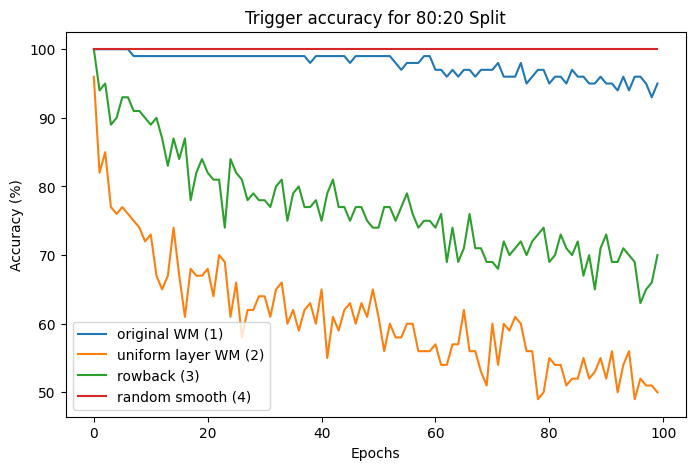

In [31]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metrics6['trigger_acc'])), metrics6['trigger_acc'], label='original WM (1)')
plt.plot(range(len(metrics7['trigger_acc'])), metrics7['trigger_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics8['trigger_acc'])), metrics8['trigger_acc'], label='rowback (3)')

plt.plot(range(len(metrics5['trigger_acc'])), metrics5['trigger_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Trigger accuracy for 80:20 Split')
plt.legend()
plt.savefig('incre_trigger_acc_8020.png')

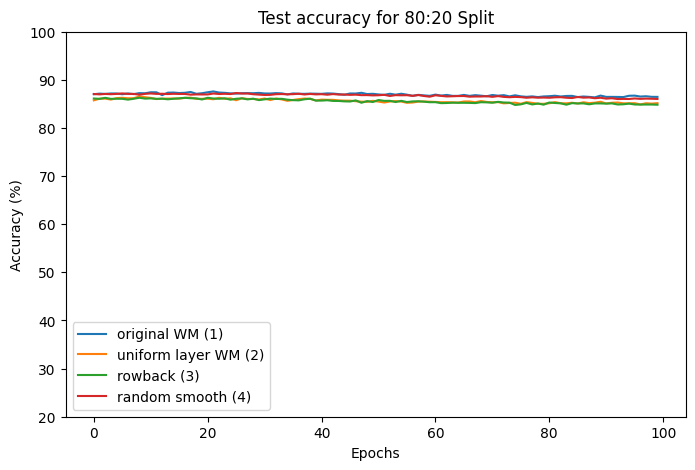

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(metrics6['val_acc'])), metrics6['val_acc'], label='original WM (1)')
plt.plot(range(len(metrics7['val_acc'])), metrics7['val_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics8['val_acc'])), metrics8['val_acc'], label='rowback (3)')

plt.plot(range(len(metrics5['val_acc'])), metrics5['val_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test accuracy for 80:20 Split')
plt.ylim([20, 100])

plt.legend()
plt.savefig('incre_test_acc_8020.png')

70:30 Split

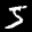

torch.Size([3, 32, 32])


In [33]:
batch_size_train = 256
batch_size_test = 256
batch_size_wm = 64

trainset = datasets.ImageFolder('./data/CIFAR10_7030/with_trigger/train/', transform=transform_train)
incset = datasets.ImageFolder('./data/CIFAR10_7030/with_trigger/train_incre/', transform=transform_train)
testset = datasets.ImageFolder('./data/CIFAR10_7030/test', transform=transform_test)
# valset = datasets.ImageFolder('./data/CIFAR10_7030/with_trigger/val/', transform=transform_test)
watermarkset = datasets.ImageFolder('./data/CIFAR10_7030/with_trigger/trigger_random/', transform=transform_test)
advwatermarkset = datasets.ImageFolder('./data/CIFAR10_7030/with_trigger/trigger_adv/', transform=transform_test)

unrelatedset = watermark_unrelated(count=100)
train_watermark_mixset = torch.utils.data.ConcatDataset((trainset,unrelatedset))


# testset = torchvision.datasets.CIFAR10(
#     root='./data', train=False, download=True, transform=transform_test)

unrelatedloader = torch.utils.data.DataLoader(
    unrelatedset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=8)

# valloader = torch.utils.data.DataLoader(
    # valset, batch_size=batch_size_test, shuffle=False, num_workers=8)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

incloader = torch.utils.data.DataLoader(
    incset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

wmloader = torch.utils.data.DataLoader(
    watermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
advwmloader = torch.utils.data.DataLoader(
    advwatermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
train_watermark_loader = torch.utils.data.DataLoader(
    train_watermark_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

In [34]:
## Sanity Check
print(f"Length of trainset {len(trainset)}")
print(f"Length of incset {len(incset)}")
print(f"Length of testset {len(testset)}")
# print(f"Length of # valset {len(# valset)}")
print(f"Length of watermarkset {len(watermarkset)}")
print(f"Length of advwatermarkset {len(advwatermarkset)}")

Length of trainset 34930
Length of incset 14970
Length of testset 10000
Length of watermarkset 100
Length of advwatermarkset 100


In [35]:
net9 = ResNet18()
net9.load_state_dict(torch.load('./models/wm_cifar10_certify_random_7030.pth')['model_state_dict'])
net10 = ResNet18()
net10.load_state_dict(torch.load('./checkpoints/resnet18_wm_7030.ckpt'))
net11 = ResNet18()
net11.load_state_dict(torch.load('./checkpoints/resnet18_wm_frozen_7030.ckpt'))
net12 = ResNet18()
net12.load_state_dict(torch.load('./checkpoints/resnet18_wm_rowback_7030.ckpt'))

<All keys matched successfully>

In [36]:
evaluator = Evaluator(net9, torch.nn.CrossEntropyLoss())
print(evaluator.eval(testloader))
print(evaluator.eval(unrelatedloader))

{'loss': 0.6196484971925617, 'accuracy': 87.48}
{'loss': 1.9512493745423855e-05, 'accuracy': 100.0}


In [37]:
evaluator = Evaluator(net10, torch.nn.CrossEntropyLoss())
print("Original watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

Original watermarking scheme
Test accuracy {'loss': 0.4954307278931141, 'accuracy': 86.14}
Watermark accuracy {'loss': 0.00022258255165070296, 'accuracy': 100.0}


In [38]:
evaluator = Evaluator(net11, torch.nn.CrossEntropyLoss())
print("Frozen watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

Frozen watermarking scheme
Test accuracy {'loss': 0.5337510022163391, 'accuracy': 85.11999999999999}
Watermark accuracy {'loss': 0.0010847225086763502, 'accuracy': 100.0}


In [39]:
evaluator = Evaluator(net12, torch.nn.CrossEntropyLoss())
print("ROWBack watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(advwmloader)}")

ROWBack watermarking scheme
Test accuracy {'loss': 0.528250137591362, 'accuracy': 85.41}
Watermark accuracy {'loss': 0.0008671558904461563, 'accuracy': 100.0}


In [40]:
logcmt = f"incre_train_certified_7030"

optimizer9 = torch.optim.SGD(lr=0.001, params=net9.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer9 = Trainer(net9, criterion, optimizer9, incloader)
evaluator9 = Evaluator(net9, criterion)

metrics9 = train(trainer9, evaluator9, testloader, savename='inccheckpoints/incre_train_cert_7030', logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 0 | Time 6s| Train Loss 0.5670 | Train Acc 86.59| Val Loss 0.606 | Val Acc 86.92| Trigger Loss 0.000 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 1 | Time 15s| Train Loss 0.4731 | Train Acc 87.44| Val Loss 0.556 | Val Acc 87.14| Trigger Loss 0.004 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 2 | Time 22s| Train Loss 0.4101 | Train Acc 88.06| Val Loss 0.501 | Val Acc 87.35| Trigger Loss 0.041 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 3 | Time 29s| Train Loss 0.3851 | Train Acc 88.16| Val Loss 0.463 | Val Acc 87.49| Trigger Loss 0.143 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 4 | Time 36s| Train Loss 0.3623 | Train Acc 88.18| Val Loss 0.458 | Val Acc 87.44| Trigger Loss 0.204 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 5 | Time 43s| Train Loss 0.3605 | Train Acc 88.56| Val Loss 0.451 | Val Acc 87.29| Trigger Loss 0.220 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 6 | Time 49s| Train Loss 0.3356 | Train Acc 88.88| Val Loss 0.439 | Val Acc 87.39| Trigger Loss 0.204 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 7 | Time 56s| Train Loss 0.3295 | Train Acc 88.96| Val Loss 0.447 | Val Acc 87.38| Trigger Loss 0.222 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 8 | Time 63s| Train Loss 0.3179 | Train Acc 89.45| Val Loss 0.428 | Val Acc 87.39| Trigger Loss 0.245 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 9 | Time 70s| Train Loss 0.3169 | Train Acc 89.29| Val Loss 0.427 | Val Acc 87.52| Trigger Loss 0.273 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 10 | Time 77s| Train Loss 0.3109 | Train Acc 89.65| Val Loss 0.423 | Val Acc 87.41| Trigger Loss 0.238 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 11 | Time 84s| Train Loss 0.3005 | Train Acc 89.96| Val Loss 0.424 | Val Acc 87.53| Trigger Loss 0.228 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 12 | Time 91s| Train Loss 0.2973 | Train Acc 89.82| Val Loss 0.421 | Val Acc 87.46| Trigger Loss 0.230 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 13 | Time 98s| Train Loss 0.2921 | Train Acc 89.90| Val Loss 0.417 | Val Acc 87.70| Trigger Loss 0.209 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 14 | Time 105s| Train Loss 0.2764 | Train Acc 90.75| Val Loss 0.413 | Val Acc 87.50| Trigger Loss 0.172 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 15 | Time 112s| Train Loss 0.2762 | Train Acc 90.43| Val Loss 0.422 | Val Acc 87.55| Trigger Loss 0.185 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 16 | Time 119s| Train Loss 0.2746 | Train Acc 90.79| Val Loss 0.411 | Val Acc 87.54| Trigger Loss 0.235 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 17 | Time 126s| Train Loss 0.2720 | Train Acc 90.70| Val Loss 0.422 | Val Acc 87.36| Trigger Loss 0.162 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 18 | Time 133s| Train Loss 0.2641 | Train Acc 91.12| Val Loss 0.411 | Val Acc 87.42| Trigger Loss 0.184 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 19 | Time 139s| Train Loss 0.2593 | Train Acc 91.40| Val Loss 0.431 | Val Acc 87.46| Trigger Loss 0.069 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 20 | Time 146s| Train Loss 0.2587 | Train Acc 91.22| Val Loss 0.412 | Val Acc 87.64| Trigger Loss 0.129 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 21 | Time 153s| Train Loss 0.2525 | Train Acc 91.38| Val Loss 0.415 | Val Acc 87.71| Trigger Loss 0.149 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 22 | Time 160s| Train Loss 0.2487 | Train Acc 91.50| Val Loss 0.410 | Val Acc 87.79| Trigger Loss 0.174 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 23 | Time 167s| Train Loss 0.2484 | Train Acc 91.57| Val Loss 0.412 | Val Acc 87.70| Trigger Loss 0.220 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 24 | Time 174s| Train Loss 0.2421 | Train Acc 91.76| Val Loss 0.418 | Val Acc 87.33| Trigger Loss 0.227 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 25 | Time 181s| Train Loss 0.2439 | Train Acc 91.51| Val Loss 0.425 | Val Acc 87.51| Trigger Loss 0.190 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 26 | Time 188s| Train Loss 0.2330 | Train Acc 91.99| Val Loss 0.421 | Val Acc 87.70| Trigger Loss 0.199 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 27 | Time 195s| Train Loss 0.2270 | Train Acc 92.12| Val Loss 0.424 | Val Acc 87.77| Trigger Loss 0.133 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 28 | Time 202s| Train Loss 0.2290 | Train Acc 92.12| Val Loss 0.420 | Val Acc 87.61| Trigger Loss 0.165 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 29 | Time 209s| Train Loss 0.2262 | Train Acc 92.16| Val Loss 0.434 | Val Acc 87.50| Trigger Loss 0.118 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 30 | Time 216s| Train Loss 0.2189 | Train Acc 92.67| Val Loss 0.425 | Val Acc 87.50| Trigger Loss 0.160 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 31 | Time 222s| Train Loss 0.2173 | Train Acc 92.56| Val Loss 0.432 | Val Acc 87.50| Trigger Loss 0.106 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 32 | Time 229s| Train Loss 0.2096 | Train Acc 92.81| Val Loss 0.439 | Val Acc 87.47| Trigger Loss 0.108 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 33 | Time 236s| Train Loss 0.2054 | Train Acc 93.09| Val Loss 0.431 | Val Acc 87.52| Trigger Loss 0.087 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 34 | Time 243s| Train Loss 0.2075 | Train Acc 92.71| Val Loss 0.437 | Val Acc 87.50| Trigger Loss 0.083 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 35 | Time 250s| Train Loss 0.2046 | Train Acc 92.85| Val Loss 0.435 | Val Acc 87.46| Trigger Loss 0.086 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 36 | Time 257s| Train Loss 0.1979 | Train Acc 93.17| Val Loss 0.435 | Val Acc 87.30| Trigger Loss 0.082 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 37 | Time 264s| Train Loss 0.1970 | Train Acc 93.40| Val Loss 0.439 | Val Acc 87.33| Trigger Loss 0.082 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.44it/s]


Epoch 38 | Time 271s| Train Loss 0.1929 | Train Acc 93.37| Val Loss 0.442 | Val Acc 87.43| Trigger Loss 0.089 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 39 | Time 278s| Train Loss 0.1875 | Train Acc 93.63| Val Loss 0.445 | Val Acc 87.35| Trigger Loss 0.079 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 40 | Time 285s| Train Loss 0.1873 | Train Acc 93.52| Val Loss 0.450 | Val Acc 87.55| Trigger Loss 0.044 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 41 | Time 292s| Train Loss 0.1816 | Train Acc 93.83| Val Loss 0.453 | Val Acc 87.38| Trigger Loss 0.059 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 42 | Time 299s| Train Loss 0.1742 | Train Acc 94.09| Val Loss 0.452 | Val Acc 87.38| Trigger Loss 0.074 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 43 | Time 306s| Train Loss 0.1763 | Train Acc 94.07| Val Loss 0.456 | Val Acc 87.22| Trigger Loss 0.084 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 44 | Time 313s| Train Loss 0.1752 | Train Acc 93.85| Val Loss 0.450 | Val Acc 87.55| Trigger Loss 0.058 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 45 | Time 320s| Train Loss 0.1710 | Train Acc 94.33| Val Loss 0.460 | Val Acc 87.29| Trigger Loss 0.056 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 46 | Time 327s| Train Loss 0.1636 | Train Acc 94.36| Val Loss 0.465 | Val Acc 87.26| Trigger Loss 0.034 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 47 | Time 334s| Train Loss 0.1693 | Train Acc 94.09| Val Loss 0.470 | Val Acc 87.10| Trigger Loss 0.031 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 48 | Time 342s| Train Loss 0.1600 | Train Acc 94.49| Val Loss 0.471 | Val Acc 87.22| Trigger Loss 0.034 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 49 | Time 349s| Train Loss 0.1573 | Train Acc 94.53| Val Loss 0.471 | Val Acc 87.26| Trigger Loss 0.031 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 50 | Time 356s| Train Loss 0.1536 | Train Acc 94.77| Val Loss 0.476 | Val Acc 87.12| Trigger Loss 0.035 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 51 | Time 363s| Train Loss 0.1519 | Train Acc 94.85| Val Loss 0.480 | Val Acc 87.27| Trigger Loss 0.031 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 52 | Time 370s| Train Loss 0.1500 | Train Acc 94.78| Val Loss 0.474 | Val Acc 87.37| Trigger Loss 0.032 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 53 | Time 378s| Train Loss 0.1489 | Train Acc 94.97| Val Loss 0.481 | Val Acc 87.27| Trigger Loss 0.033 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 54 | Time 385s| Train Loss 0.1436 | Train Acc 95.09| Val Loss 0.484 | Val Acc 87.44| Trigger Loss 0.034 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 55 | Time 392s| Train Loss 0.1425 | Train Acc 95.28| Val Loss 0.496 | Val Acc 87.22| Trigger Loss 0.023 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 56 | Time 399s| Train Loss 0.1376 | Train Acc 95.36| Val Loss 0.493 | Val Acc 87.15| Trigger Loss 0.016 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 57 | Time 406s| Train Loss 0.1398 | Train Acc 95.22| Val Loss 0.496 | Val Acc 87.33| Trigger Loss 0.023 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 58 | Time 414s| Train Loss 0.1382 | Train Acc 95.25| Val Loss 0.493 | Val Acc 87.23| Trigger Loss 0.021 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 59 | Time 421s| Train Loss 0.1322 | Train Acc 95.29| Val Loss 0.496 | Val Acc 87.28| Trigger Loss 0.014 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 60 | Time 428s| Train Loss 0.1266 | Train Acc 95.60| Val Loss 0.505 | Val Acc 87.21| Trigger Loss 0.015 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 61 | Time 435s| Train Loss 0.1291 | Train Acc 95.74| Val Loss 0.507 | Val Acc 87.22| Trigger Loss 0.017 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 62 | Time 442s| Train Loss 0.1228 | Train Acc 96.11| Val Loss 0.500 | Val Acc 87.38| Trigger Loss 0.024 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 63 | Time 450s| Train Loss 0.1196 | Train Acc 95.99| Val Loss 0.509 | Val Acc 87.19| Trigger Loss 0.018 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 64 | Time 457s| Train Loss 0.1191 | Train Acc 96.08| Val Loss 0.512 | Val Acc 87.25| Trigger Loss 0.015 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 65 | Time 464s| Train Loss 0.1143 | Train Acc 96.08| Val Loss 0.517 | Val Acc 87.28| Trigger Loss 0.020 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 66 | Time 471s| Train Loss 0.1177 | Train Acc 96.05| Val Loss 0.515 | Val Acc 87.29| Trigger Loss 0.031 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 67 | Time 478s| Train Loss 0.1157 | Train Acc 95.86| Val Loss 0.521 | Val Acc 87.19| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 68 | Time 485s| Train Loss 0.1083 | Train Acc 96.37| Val Loss 0.521 | Val Acc 87.23| Trigger Loss 0.017 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 69 | Time 493s| Train Loss 0.1127 | Train Acc 96.18| Val Loss 0.522 | Val Acc 87.30| Trigger Loss 0.018 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 70 | Time 500s| Train Loss 0.1069 | Train Acc 96.35| Val Loss 0.529 | Val Acc 87.25| Trigger Loss 0.021 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 71 | Time 507s| Train Loss 0.1047 | Train Acc 96.42| Val Loss 0.525 | Val Acc 87.33| Trigger Loss 0.030 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 72 | Time 514s| Train Loss 0.1006 | Train Acc 96.61| Val Loss 0.532 | Val Acc 87.20| Trigger Loss 0.020 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 73 | Time 521s| Train Loss 0.0986 | Train Acc 96.71| Val Loss 0.533 | Val Acc 87.23| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 74 | Time 528s| Train Loss 0.0957 | Train Acc 96.89| Val Loss 0.541 | Val Acc 87.23| Trigger Loss 0.010 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 75 | Time 536s| Train Loss 0.0927 | Train Acc 96.97| Val Loss 0.539 | Val Acc 87.28| Trigger Loss 0.015 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 76 | Time 543s| Train Loss 0.0959 | Train Acc 96.87| Val Loss 0.539 | Val Acc 87.12| Trigger Loss 0.021 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 77 | Time 550s| Train Loss 0.0995 | Train Acc 96.66| Val Loss 0.546 | Val Acc 87.17| Trigger Loss 0.015 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 78 | Time 557s| Train Loss 0.0864 | Train Acc 97.19| Val Loss 0.545 | Val Acc 87.19| Trigger Loss 0.020 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 79 | Time 564s| Train Loss 0.0874 | Train Acc 97.08| Val Loss 0.547 | Val Acc 87.17| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 80 | Time 572s| Train Loss 0.0887 | Train Acc 97.03| Val Loss 0.551 | Val Acc 87.23| Trigger Loss 0.016 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 81 | Time 579s| Train Loss 0.0845 | Train Acc 97.18| Val Loss 0.552 | Val Acc 87.25| Trigger Loss 0.015 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 82 | Time 586s| Train Loss 0.0820 | Train Acc 97.35| Val Loss 0.551 | Val Acc 87.42| Trigger Loss 0.010 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 83 | Time 593s| Train Loss 0.0801 | Train Acc 97.39| Val Loss 0.557 | Val Acc 87.20| Trigger Loss 0.014 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 84 | Time 601s| Train Loss 0.0759 | Train Acc 97.56| Val Loss 0.560 | Val Acc 87.18| Trigger Loss 0.018 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 85 | Time 608s| Train Loss 0.0801 | Train Acc 97.43| Val Loss 0.562 | Val Acc 87.22| Trigger Loss 0.015 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 86 | Time 615s| Train Loss 0.0808 | Train Acc 97.35| Val Loss 0.562 | Val Acc 87.31| Trigger Loss 0.023 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 87 | Time 622s| Train Loss 0.0781 | Train Acc 97.43| Val Loss 0.568 | Val Acc 87.00| Trigger Loss 0.018 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 88 | Time 629s| Train Loss 0.0764 | Train Acc 97.43| Val Loss 0.565 | Val Acc 87.21| Trigger Loss 0.023 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 89 | Time 636s| Train Loss 0.0747 | Train Acc 97.49| Val Loss 0.570 | Val Acc 87.02| Trigger Loss 0.016 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 90 | Time 643s| Train Loss 0.0692 | Train Acc 97.62| Val Loss 0.576 | Val Acc 87.10| Trigger Loss 0.011 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 91 | Time 651s| Train Loss 0.0684 | Train Acc 97.95| Val Loss 0.576 | Val Acc 86.94| Trigger Loss 0.017 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 92 | Time 658s| Train Loss 0.0719 | Train Acc 97.61| Val Loss 0.576 | Val Acc 87.13| Trigger Loss 0.009 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 93 | Time 665s| Train Loss 0.0656 | Train Acc 97.84| Val Loss 0.579 | Val Acc 87.05| Trigger Loss 0.007 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 94 | Time 672s| Train Loss 0.0643 | Train Acc 97.84| Val Loss 0.585 | Val Acc 87.05| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 95 | Time 679s| Train Loss 0.0666 | Train Acc 97.86| Val Loss 0.585 | Val Acc 87.08| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 96 | Time 687s| Train Loss 0.0640 | Train Acc 97.98| Val Loss 0.591 | Val Acc 87.00| Trigger Loss 0.022 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.27it/s]


Epoch 97 | Time 694s| Train Loss 0.0648 | Train Acc 97.85| Val Loss 0.590 | Val Acc 86.94| Trigger Loss 0.019 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 98 | Time 701s| Train Loss 0.0636 | Train Acc 98.01| Val Loss 0.594 | Val Acc 87.00| Trigger Loss 0.018 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 99 | Time 708s| Train Loss 0.0598 | Train Acc 98.14| Val Loss 0.594 | Val Acc 87.13| Trigger Loss 0.024 | Trigger Acc 99.00


In [41]:
logcmt = f"incre_train_baseline_7030"

optimizer10 = torch.optim.SGD(lr=0.001, params=net10.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer10 = Trainer(net10, criterion, optimizer10, incloader)
evaluator10 = Evaluator(net10, criterion)

metrics10 = train(trainer10, evaluator10, testloader, savename='inccheckpoints/incre_train_baseline_7030', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 0 | Time 6s| Train Loss 0.4661 | Train Acc 86.29| Val Loss 0.487 | Val Acc 86.01| Trigger Loss 0.001 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 1 | Time 15s| Train Loss 0.4248 | Train Acc 86.63| Val Loss 0.473 | Val Acc 85.82| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 2 | Time 22s| Train Loss 0.3982 | Train Acc 87.05| Val Loss 0.454 | Val Acc 86.15| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 3 | Time 29s| Train Loss 0.3770 | Train Acc 87.51| Val Loss 0.446 | Val Acc 86.02| Trigger Loss 0.006 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 4 | Time 36s| Train Loss 0.3611 | Train Acc 88.06| Val Loss 0.435 | Val Acc 86.20| Trigger Loss 0.009 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 5 | Time 44s| Train Loss 0.3516 | Train Acc 88.04| Val Loss 0.432 | Val Acc 86.24| Trigger Loss 0.010 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 6 | Time 51s| Train Loss 0.3459 | Train Acc 88.36| Val Loss 0.424 | Val Acc 86.13| Trigger Loss 0.009 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 7 | Time 58s| Train Loss 0.3378 | Train Acc 88.44| Val Loss 0.421 | Val Acc 86.27| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 8 | Time 65s| Train Loss 0.3271 | Train Acc 88.94| Val Loss 0.415 | Val Acc 86.40| Trigger Loss 0.016 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 9 | Time 72s| Train Loss 0.3189 | Train Acc 89.03| Val Loss 0.418 | Val Acc 86.47| Trigger Loss 0.020 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 10 | Time 80s| Train Loss 0.3152 | Train Acc 89.12| Val Loss 0.412 | Val Acc 86.55| Trigger Loss 0.017 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.30it/s]


Epoch 11 | Time 87s| Train Loss 0.3101 | Train Acc 89.23| Val Loss 0.415 | Val Acc 86.37| Trigger Loss 0.030 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 12 | Time 94s| Train Loss 0.2981 | Train Acc 89.71| Val Loss 0.413 | Val Acc 86.41| Trigger Loss 0.022 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 13 | Time 101s| Train Loss 0.2992 | Train Acc 89.57| Val Loss 0.412 | Val Acc 86.27| Trigger Loss 0.030 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 14 | Time 109s| Train Loss 0.2986 | Train Acc 89.57| Val Loss 0.413 | Val Acc 86.47| Trigger Loss 0.026 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 15 | Time 116s| Train Loss 0.2856 | Train Acc 90.13| Val Loss 0.419 | Val Acc 86.53| Trigger Loss 0.042 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 16 | Time 123s| Train Loss 0.2854 | Train Acc 90.25| Val Loss 0.419 | Val Acc 86.30| Trigger Loss 0.038 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 17 | Time 130s| Train Loss 0.2828 | Train Acc 90.41| Val Loss 0.414 | Val Acc 86.62| Trigger Loss 0.036 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 18 | Time 137s| Train Loss 0.2770 | Train Acc 90.31| Val Loss 0.415 | Val Acc 86.74| Trigger Loss 0.041 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 19 | Time 144s| Train Loss 0.2686 | Train Acc 90.78| Val Loss 0.419 | Val Acc 86.54| Trigger Loss 0.041 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 20 | Time 151s| Train Loss 0.2690 | Train Acc 90.70| Val Loss 0.418 | Val Acc 86.33| Trigger Loss 0.049 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 21 | Time 159s| Train Loss 0.2626 | Train Acc 90.90| Val Loss 0.418 | Val Acc 86.62| Trigger Loss 0.051 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 22 | Time 166s| Train Loss 0.2627 | Train Acc 91.05| Val Loss 0.422 | Val Acc 86.62| Trigger Loss 0.048 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 23 | Time 173s| Train Loss 0.2641 | Train Acc 90.84| Val Loss 0.420 | Val Acc 86.49| Trigger Loss 0.059 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 24 | Time 180s| Train Loss 0.2551 | Train Acc 91.32| Val Loss 0.418 | Val Acc 86.69| Trigger Loss 0.061 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 25 | Time 187s| Train Loss 0.2517 | Train Acc 91.22| Val Loss 0.422 | Val Acc 86.35| Trigger Loss 0.062 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 26 | Time 194s| Train Loss 0.2478 | Train Acc 91.45| Val Loss 0.426 | Val Acc 86.66| Trigger Loss 0.065 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.30it/s]


Epoch 27 | Time 201s| Train Loss 0.2432 | Train Acc 91.69| Val Loss 0.426 | Val Acc 86.51| Trigger Loss 0.063 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 28 | Time 209s| Train Loss 0.2387 | Train Acc 91.98| Val Loss 0.427 | Val Acc 86.53| Trigger Loss 0.078 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 29 | Time 216s| Train Loss 0.2411 | Train Acc 91.80| Val Loss 0.423 | Val Acc 86.40| Trigger Loss 0.071 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 30 | Time 223s| Train Loss 0.2324 | Train Acc 91.98| Val Loss 0.431 | Val Acc 86.47| Trigger Loss 0.070 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 31 | Time 230s| Train Loss 0.2298 | Train Acc 92.14| Val Loss 0.432 | Val Acc 86.56| Trigger Loss 0.092 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 32 | Time 237s| Train Loss 0.2286 | Train Acc 92.36| Val Loss 0.432 | Val Acc 86.40| Trigger Loss 0.076 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 33 | Time 244s| Train Loss 0.2261 | Train Acc 92.10| Val Loss 0.434 | Val Acc 86.59| Trigger Loss 0.101 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 34 | Time 250s| Train Loss 0.2204 | Train Acc 92.67| Val Loss 0.436 | Val Acc 86.47| Trigger Loss 0.091 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 35 | Time 257s| Train Loss 0.2189 | Train Acc 92.43| Val Loss 0.437 | Val Acc 86.45| Trigger Loss 0.079 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 36 | Time 264s| Train Loss 0.2193 | Train Acc 92.79| Val Loss 0.438 | Val Acc 86.45| Trigger Loss 0.092 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 37 | Time 271s| Train Loss 0.2159 | Train Acc 92.63| Val Loss 0.439 | Val Acc 86.73| Trigger Loss 0.099 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 38 | Time 278s| Train Loss 0.2082 | Train Acc 93.09| Val Loss 0.437 | Val Acc 86.66| Trigger Loss 0.108 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 39 | Time 285s| Train Loss 0.2070 | Train Acc 93.13| Val Loss 0.440 | Val Acc 86.60| Trigger Loss 0.117 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 40 | Time 292s| Train Loss 0.2052 | Train Acc 93.09| Val Loss 0.440 | Val Acc 86.49| Trigger Loss 0.103 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 41 | Time 299s| Train Loss 0.2013 | Train Acc 92.92| Val Loss 0.448 | Val Acc 86.50| Trigger Loss 0.152 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 42 | Time 306s| Train Loss 0.1978 | Train Acc 93.41| Val Loss 0.447 | Val Acc 86.74| Trigger Loss 0.105 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 43 | Time 313s| Train Loss 0.1998 | Train Acc 93.33| Val Loss 0.449 | Val Acc 86.37| Trigger Loss 0.142 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 44 | Time 320s| Train Loss 0.1941 | Train Acc 93.35| Val Loss 0.452 | Val Acc 86.25| Trigger Loss 0.136 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 45 | Time 327s| Train Loss 0.1893 | Train Acc 93.73| Val Loss 0.453 | Val Acc 86.49| Trigger Loss 0.115 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 46 | Time 334s| Train Loss 0.1906 | Train Acc 93.64| Val Loss 0.460 | Val Acc 86.31| Trigger Loss 0.156 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 47 | Time 341s| Train Loss 0.1841 | Train Acc 93.74| Val Loss 0.454 | Val Acc 86.39| Trigger Loss 0.148 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 48 | Time 348s| Train Loss 0.1779 | Train Acc 93.98| Val Loss 0.461 | Val Acc 86.67| Trigger Loss 0.186 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 49 | Time 355s| Train Loss 0.1791 | Train Acc 94.01| Val Loss 0.462 | Val Acc 86.54| Trigger Loss 0.167 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 50 | Time 361s| Train Loss 0.1739 | Train Acc 94.22| Val Loss 0.461 | Val Acc 86.64| Trigger Loss 0.155 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 51 | Time 368s| Train Loss 0.1757 | Train Acc 94.01| Val Loss 0.465 | Val Acc 86.45| Trigger Loss 0.228 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 52 | Time 375s| Train Loss 0.1686 | Train Acc 94.24| Val Loss 0.468 | Val Acc 86.33| Trigger Loss 0.179 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 53 | Time 382s| Train Loss 0.1699 | Train Acc 94.46| Val Loss 0.473 | Val Acc 86.33| Trigger Loss 0.210 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 54 | Time 389s| Train Loss 0.1678 | Train Acc 94.48| Val Loss 0.467 | Val Acc 86.29| Trigger Loss 0.178 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 55 | Time 396s| Train Loss 0.1610 | Train Acc 94.65| Val Loss 0.474 | Val Acc 86.18| Trigger Loss 0.203 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 56 | Time 403s| Train Loss 0.1620 | Train Acc 94.54| Val Loss 0.475 | Val Acc 86.28| Trigger Loss 0.186 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 57 | Time 410s| Train Loss 0.1603 | Train Acc 94.59| Val Loss 0.487 | Val Acc 86.19| Trigger Loss 0.239 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 58 | Time 417s| Train Loss 0.1519 | Train Acc 94.98| Val Loss 0.488 | Val Acc 86.20| Trigger Loss 0.193 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 59 | Time 424s| Train Loss 0.1534 | Train Acc 95.05| Val Loss 0.486 | Val Acc 86.01| Trigger Loss 0.293 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 60 | Time 431s| Train Loss 0.1527 | Train Acc 94.96| Val Loss 0.484 | Val Acc 86.29| Trigger Loss 0.257 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 61 | Time 438s| Train Loss 0.1516 | Train Acc 94.81| Val Loss 0.491 | Val Acc 86.31| Trigger Loss 0.260 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 62 | Time 445s| Train Loss 0.1499 | Train Acc 95.00| Val Loss 0.492 | Val Acc 85.98| Trigger Loss 0.222 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 63 | Time 452s| Train Loss 0.1402 | Train Acc 95.36| Val Loss 0.491 | Val Acc 86.09| Trigger Loss 0.304 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 64 | Time 459s| Train Loss 0.1440 | Train Acc 95.14| Val Loss 0.500 | Val Acc 86.15| Trigger Loss 0.278 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 65 | Time 466s| Train Loss 0.1375 | Train Acc 95.40| Val Loss 0.499 | Val Acc 86.24| Trigger Loss 0.240 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 66 | Time 473s| Train Loss 0.1358 | Train Acc 95.47| Val Loss 0.504 | Val Acc 85.96| Trigger Loss 0.329 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 67 | Time 480s| Train Loss 0.1322 | Train Acc 95.69| Val Loss 0.510 | Val Acc 85.87| Trigger Loss 0.271 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 68 | Time 487s| Train Loss 0.1354 | Train Acc 95.28| Val Loss 0.525 | Val Acc 85.84| Trigger Loss 0.270 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 69 | Time 494s| Train Loss 0.1260 | Train Acc 95.66| Val Loss 0.517 | Val Acc 85.83| Trigger Loss 0.435 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 70 | Time 501s| Train Loss 0.1267 | Train Acc 95.65| Val Loss 0.514 | Val Acc 86.14| Trigger Loss 0.360 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 71 | Time 507s| Train Loss 0.1261 | Train Acc 95.75| Val Loss 0.523 | Val Acc 85.88| Trigger Loss 0.373 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 72 | Time 514s| Train Loss 0.1249 | Train Acc 95.82| Val Loss 0.518 | Val Acc 86.37| Trigger Loss 0.286 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 73 | Time 521s| Train Loss 0.1252 | Train Acc 95.89| Val Loss 0.526 | Val Acc 86.00| Trigger Loss 0.330 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 74 | Time 528s| Train Loss 0.1190 | Train Acc 96.25| Val Loss 0.527 | Val Acc 85.80| Trigger Loss 0.378 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 75 | Time 535s| Train Loss 0.1186 | Train Acc 96.15| Val Loss 0.523 | Val Acc 86.25| Trigger Loss 0.324 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.30it/s]


Epoch 76 | Time 542s| Train Loss 0.1090 | Train Acc 96.51| Val Loss 0.529 | Val Acc 86.04| Trigger Loss 0.414 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 77 | Time 549s| Train Loss 0.1115 | Train Acc 96.39| Val Loss 0.537 | Val Acc 85.93| Trigger Loss 0.408 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 78 | Time 556s| Train Loss 0.1103 | Train Acc 96.42| Val Loss 0.540 | Val Acc 85.88| Trigger Loss 0.438 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 79 | Time 563s| Train Loss 0.1076 | Train Acc 96.48| Val Loss 0.540 | Val Acc 86.00| Trigger Loss 0.484 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 80 | Time 570s| Train Loss 0.1096 | Train Acc 96.48| Val Loss 0.541 | Val Acc 86.19| Trigger Loss 0.456 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 81 | Time 577s| Train Loss 0.1057 | Train Acc 96.60| Val Loss 0.546 | Val Acc 85.81| Trigger Loss 0.445 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 82 | Time 584s| Train Loss 0.0981 | Train Acc 96.77| Val Loss 0.550 | Val Acc 85.70| Trigger Loss 0.454 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 83 | Time 591s| Train Loss 0.1007 | Train Acc 96.70| Val Loss 0.555 | Val Acc 85.71| Trigger Loss 0.496 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 84 | Time 598s| Train Loss 0.1025 | Train Acc 96.57| Val Loss 0.555 | Val Acc 86.12| Trigger Loss 0.451 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 85 | Time 605s| Train Loss 0.0964 | Train Acc 96.83| Val Loss 0.556 | Val Acc 86.02| Trigger Loss 0.497 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 86 | Time 612s| Train Loss 0.0876 | Train Acc 97.31| Val Loss 0.572 | Val Acc 85.77| Trigger Loss 0.513 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 87 | Time 618s| Train Loss 0.0973 | Train Acc 96.83| Val Loss 0.571 | Val Acc 85.81| Trigger Loss 0.525 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 88 | Time 625s| Train Loss 0.0901 | Train Acc 97.05| Val Loss 0.565 | Val Acc 86.13| Trigger Loss 0.534 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 89 | Time 632s| Train Loss 0.0876 | Train Acc 97.11| Val Loss 0.572 | Val Acc 85.91| Trigger Loss 0.625 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 90 | Time 639s| Train Loss 0.0886 | Train Acc 97.17| Val Loss 0.573 | Val Acc 85.90| Trigger Loss 0.534 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 91 | Time 646s| Train Loss 0.0856 | Train Acc 97.31| Val Loss 0.581 | Val Acc 85.61| Trigger Loss 0.569 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 92 | Time 653s| Train Loss 0.0848 | Train Acc 97.27| Val Loss 0.580 | Val Acc 86.00| Trigger Loss 0.489 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 93 | Time 660s| Train Loss 0.0803 | Train Acc 97.47| Val Loss 0.580 | Val Acc 85.86| Trigger Loss 0.474 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 94 | Time 667s| Train Loss 0.0807 | Train Acc 97.41| Val Loss 0.580 | Val Acc 85.86| Trigger Loss 0.574 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 95 | Time 674s| Train Loss 0.0789 | Train Acc 97.54| Val Loss 0.590 | Val Acc 85.97| Trigger Loss 0.621 | Trigger Acc 79.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 96 | Time 681s| Train Loss 0.0794 | Train Acc 97.39| Val Loss 0.591 | Val Acc 85.76| Trigger Loss 0.716 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 97 | Time 688s| Train Loss 0.0763 | Train Acc 97.58| Val Loss 0.590 | Val Acc 85.96| Trigger Loss 0.640 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 98 | Time 695s| Train Loss 0.0761 | Train Acc 97.53| Val Loss 0.603 | Val Acc 85.96| Trigger Loss 0.748 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.26it/s]


Epoch 99 | Time 702s| Train Loss 0.0737 | Train Acc 97.62| Val Loss 0.598 | Val Acc 85.94| Trigger Loss 0.599 | Trigger Acc 81.00


In [42]:
logcmt = f"incre_train_baseline_frozen_7030"

optimizer11 = torch.optim.SGD(lr=0.001, params=net11.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer11 = Trainer(net11, criterion, optimizer11, incloader)
evaluator11 = Evaluator(net11, criterion)

metrics11 = train(trainer11, evaluator11, testloader, savename='inccheckpoints/incre_train_baseline_frozen_7030', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 0 | Time 6s| Train Loss 0.4942 | Train Acc 84.78| Val Loss 0.544 | Val Acc 84.59| Trigger Loss 0.233 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 1 | Time 15s| Train Loss 0.4510 | Train Acc 85.68| Val Loss 0.514 | Val Acc 84.92| Trigger Loss 0.543 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 2 | Time 22s| Train Loss 0.4222 | Train Acc 86.30| Val Loss 0.494 | Val Acc 84.86| Trigger Loss 0.631 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 3 | Time 29s| Train Loss 0.4079 | Train Acc 86.47| Val Loss 0.488 | Val Acc 85.13| Trigger Loss 0.734 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 4 | Time 35s| Train Loss 0.3909 | Train Acc 86.97| Val Loss 0.486 | Val Acc 85.04| Trigger Loss 0.939 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 5 | Time 42s| Train Loss 0.3793 | Train Acc 87.17| Val Loss 0.475 | Val Acc 85.22| Trigger Loss 0.930 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 6 | Time 49s| Train Loss 0.3610 | Train Acc 87.43| Val Loss 0.470 | Val Acc 85.46| Trigger Loss 1.015 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 7 | Time 56s| Train Loss 0.3598 | Train Acc 87.68| Val Loss 0.469 | Val Acc 85.28| Trigger Loss 1.050 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 8 | Time 63s| Train Loss 0.3531 | Train Acc 88.12| Val Loss 0.466 | Val Acc 85.39| Trigger Loss 1.152 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 9 | Time 70s| Train Loss 0.3437 | Train Acc 88.30| Val Loss 0.460 | Val Acc 85.48| Trigger Loss 1.348 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 10 | Time 77s| Train Loss 0.3363 | Train Acc 88.31| Val Loss 0.460 | Val Acc 85.26| Trigger Loss 1.421 | Trigger Acc 52.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 11 | Time 84s| Train Loss 0.3315 | Train Acc 88.42| Val Loss 0.461 | Val Acc 85.44| Trigger Loss 1.389 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 12 | Time 91s| Train Loss 0.3210 | Train Acc 88.98| Val Loss 0.462 | Val Acc 85.44| Trigger Loss 1.557 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 13 | Time 98s| Train Loss 0.3194 | Train Acc 89.21| Val Loss 0.458 | Val Acc 85.50| Trigger Loss 1.484 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Epoch 14 | Time 105s| Train Loss 0.3202 | Train Acc 88.91| Val Loss 0.457 | Val Acc 85.70| Trigger Loss 1.505 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 15 | Time 112s| Train Loss 0.3105 | Train Acc 89.61| Val Loss 0.459 | Val Acc 85.52| Trigger Loss 1.524 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.27it/s]


Epoch 16 | Time 119s| Train Loss 0.3036 | Train Acc 89.57| Val Loss 0.458 | Val Acc 85.31| Trigger Loss 1.563 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 17 | Time 126s| Train Loss 0.2946 | Train Acc 90.03| Val Loss 0.455 | Val Acc 85.49| Trigger Loss 1.584 | Trigger Acc 52.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 18 | Time 132s| Train Loss 0.2956 | Train Acc 89.83| Val Loss 0.460 | Val Acc 85.82| Trigger Loss 1.730 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 19 | Time 139s| Train Loss 0.2919 | Train Acc 89.84| Val Loss 0.460 | Val Acc 85.79| Trigger Loss 1.654 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 20 | Time 146s| Train Loss 0.2875 | Train Acc 90.18| Val Loss 0.458 | Val Acc 85.53| Trigger Loss 1.623 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 21 | Time 153s| Train Loss 0.2804 | Train Acc 90.50| Val Loss 0.453 | Val Acc 85.61| Trigger Loss 1.589 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 22 | Time 160s| Train Loss 0.2790 | Train Acc 90.26| Val Loss 0.459 | Val Acc 85.59| Trigger Loss 1.703 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 23 | Time 167s| Train Loss 0.2742 | Train Acc 90.51| Val Loss 0.463 | Val Acc 85.60| Trigger Loss 1.617 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 24 | Time 174s| Train Loss 0.2726 | Train Acc 90.53| Val Loss 0.465 | Val Acc 85.61| Trigger Loss 1.819 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 25 | Time 181s| Train Loss 0.2688 | Train Acc 90.94| Val Loss 0.460 | Val Acc 85.60| Trigger Loss 1.785 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 26 | Time 188s| Train Loss 0.2555 | Train Acc 91.36| Val Loss 0.463 | Val Acc 85.62| Trigger Loss 1.780 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 27 | Time 195s| Train Loss 0.2549 | Train Acc 91.34| Val Loss 0.469 | Val Acc 85.46| Trigger Loss 1.875 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 28 | Time 202s| Train Loss 0.2562 | Train Acc 91.08| Val Loss 0.467 | Val Acc 85.69| Trigger Loss 1.953 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 29 | Time 209s| Train Loss 0.2515 | Train Acc 91.54| Val Loss 0.470 | Val Acc 85.40| Trigger Loss 2.010 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 30 | Time 216s| Train Loss 0.2450 | Train Acc 91.81| Val Loss 0.475 | Val Acc 85.59| Trigger Loss 1.888 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 31 | Time 223s| Train Loss 0.2377 | Train Acc 91.82| Val Loss 0.474 | Val Acc 85.38| Trigger Loss 1.857 | Trigger Acc 49.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 32 | Time 229s| Train Loss 0.2425 | Train Acc 91.64| Val Loss 0.477 | Val Acc 85.36| Trigger Loss 1.960 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 33 | Time 236s| Train Loss 0.2343 | Train Acc 92.00| Val Loss 0.479 | Val Acc 85.37| Trigger Loss 2.063 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 34 | Time 243s| Train Loss 0.2326 | Train Acc 92.07| Val Loss 0.479 | Val Acc 85.53| Trigger Loss 2.020 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 35 | Time 250s| Train Loss 0.2261 | Train Acc 92.26| Val Loss 0.483 | Val Acc 85.65| Trigger Loss 2.105 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 36 | Time 257s| Train Loss 0.2260 | Train Acc 92.48| Val Loss 0.483 | Val Acc 85.39| Trigger Loss 2.113 | Trigger Acc 42.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 37 | Time 264s| Train Loss 0.2242 | Train Acc 92.36| Val Loss 0.486 | Val Acc 85.51| Trigger Loss 1.982 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 38 | Time 271s| Train Loss 0.2224 | Train Acc 92.73| Val Loss 0.483 | Val Acc 85.52| Trigger Loss 2.184 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 39 | Time 278s| Train Loss 0.2152 | Train Acc 92.61| Val Loss 0.488 | Val Acc 85.40| Trigger Loss 2.099 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 40 | Time 285s| Train Loss 0.2094 | Train Acc 92.89| Val Loss 0.492 | Val Acc 85.37| Trigger Loss 2.203 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 41 | Time 292s| Train Loss 0.2067 | Train Acc 93.09| Val Loss 0.489 | Val Acc 85.45| Trigger Loss 2.082 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 42 | Time 299s| Train Loss 0.1988 | Train Acc 93.40| Val Loss 0.491 | Val Acc 85.38| Trigger Loss 2.117 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 43 | Time 306s| Train Loss 0.2028 | Train Acc 92.85| Val Loss 0.500 | Val Acc 85.27| Trigger Loss 2.215 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 44 | Time 313s| Train Loss 0.1948 | Train Acc 93.60| Val Loss 0.501 | Val Acc 85.22| Trigger Loss 2.268 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 45 | Time 319s| Train Loss 0.1961 | Train Acc 93.34| Val Loss 0.499 | Val Acc 85.41| Trigger Loss 2.442 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 46 | Time 326s| Train Loss 0.1936 | Train Acc 93.50| Val Loss 0.503 | Val Acc 85.58| Trigger Loss 2.265 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 47 | Time 333s| Train Loss 0.1852 | Train Acc 93.79| Val Loss 0.516 | Val Acc 85.26| Trigger Loss 2.306 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 48 | Time 340s| Train Loss 0.1856 | Train Acc 93.62| Val Loss 0.512 | Val Acc 85.47| Trigger Loss 2.423 | Trigger Acc 42.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 49 | Time 347s| Train Loss 0.1861 | Train Acc 93.65| Val Loss 0.516 | Val Acc 85.47| Trigger Loss 2.570 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 50 | Time 354s| Train Loss 0.1802 | Train Acc 94.13| Val Loss 0.515 | Val Acc 85.58| Trigger Loss 2.496 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 51 | Time 361s| Train Loss 0.1806 | Train Acc 93.83| Val Loss 0.515 | Val Acc 85.39| Trigger Loss 2.668 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 52 | Time 368s| Train Loss 0.1689 | Train Acc 94.38| Val Loss 0.518 | Val Acc 85.33| Trigger Loss 2.438 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 53 | Time 375s| Train Loss 0.1699 | Train Acc 94.13| Val Loss 0.519 | Val Acc 85.26| Trigger Loss 2.525 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 54 | Time 382s| Train Loss 0.1657 | Train Acc 94.40| Val Loss 0.524 | Val Acc 85.25| Trigger Loss 2.340 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 55 | Time 389s| Train Loss 0.1687 | Train Acc 94.44| Val Loss 0.528 | Val Acc 85.25| Trigger Loss 2.635 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 56 | Time 396s| Train Loss 0.1602 | Train Acc 94.46| Val Loss 0.533 | Val Acc 85.16| Trigger Loss 2.620 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 57 | Time 403s| Train Loss 0.1525 | Train Acc 94.94| Val Loss 0.544 | Val Acc 84.96| Trigger Loss 2.535 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 58 | Time 410s| Train Loss 0.1529 | Train Acc 95.02| Val Loss 0.540 | Val Acc 85.26| Trigger Loss 2.741 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 59 | Time 416s| Train Loss 0.1470 | Train Acc 94.98| Val Loss 0.543 | Val Acc 85.07| Trigger Loss 2.520 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 60 | Time 423s| Train Loss 0.1442 | Train Acc 95.39| Val Loss 0.546 | Val Acc 85.12| Trigger Loss 2.720 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 61 | Time 430s| Train Loss 0.1461 | Train Acc 95.16| Val Loss 0.548 | Val Acc 85.38| Trigger Loss 2.822 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 62 | Time 437s| Train Loss 0.1435 | Train Acc 95.26| Val Loss 0.554 | Val Acc 85.17| Trigger Loss 2.742 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 63 | Time 444s| Train Loss 0.1398 | Train Acc 95.30| Val Loss 0.556 | Val Acc 85.08| Trigger Loss 2.686 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 64 | Time 451s| Train Loss 0.1394 | Train Acc 95.32| Val Loss 0.554 | Val Acc 84.91| Trigger Loss 2.719 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 65 | Time 458s| Train Loss 0.1352 | Train Acc 95.55| Val Loss 0.557 | Val Acc 85.14| Trigger Loss 2.803 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 66 | Time 465s| Train Loss 0.1312 | Train Acc 95.89| Val Loss 0.563 | Val Acc 84.91| Trigger Loss 2.803 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 67 | Time 472s| Train Loss 0.1262 | Train Acc 95.81| Val Loss 0.562 | Val Acc 85.10| Trigger Loss 2.857 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 68 | Time 479s| Train Loss 0.1257 | Train Acc 95.97| Val Loss 0.567 | Val Acc 85.13| Trigger Loss 2.853 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 69 | Time 486s| Train Loss 0.1241 | Train Acc 95.93| Val Loss 0.566 | Val Acc 85.09| Trigger Loss 2.647 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 70 | Time 493s| Train Loss 0.1249 | Train Acc 96.11| Val Loss 0.581 | Val Acc 84.75| Trigger Loss 2.820 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 71 | Time 500s| Train Loss 0.1187 | Train Acc 96.04| Val Loss 0.579 | Val Acc 84.59| Trigger Loss 2.940 | Trigger Acc 42.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 72 | Time 507s| Train Loss 0.1206 | Train Acc 96.11| Val Loss 0.611 | Val Acc 84.52| Trigger Loss 2.981 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 73 | Time 513s| Train Loss 0.1170 | Train Acc 96.23| Val Loss 0.589 | Val Acc 84.86| Trigger Loss 3.137 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 74 | Time 520s| Train Loss 0.1150 | Train Acc 96.14| Val Loss 0.588 | Val Acc 85.09| Trigger Loss 3.021 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 75 | Time 527s| Train Loss 0.1115 | Train Acc 96.45| Val Loss 0.589 | Val Acc 84.71| Trigger Loss 3.005 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 76 | Time 534s| Train Loss 0.1094 | Train Acc 96.47| Val Loss 0.589 | Val Acc 84.95| Trigger Loss 3.194 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 77 | Time 541s| Train Loss 0.1079 | Train Acc 96.58| Val Loss 0.581 | Val Acc 85.19| Trigger Loss 3.382 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 78 | Time 548s| Train Loss 0.1014 | Train Acc 96.57| Val Loss 0.595 | Val Acc 84.96| Trigger Loss 3.266 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 79 | Time 555s| Train Loss 0.1056 | Train Acc 96.53| Val Loss 0.599 | Val Acc 85.08| Trigger Loss 3.267 | Trigger Acc 42.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 80 | Time 562s| Train Loss 0.1066 | Train Acc 96.65| Val Loss 0.602 | Val Acc 84.96| Trigger Loss 3.238 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 81 | Time 569s| Train Loss 0.0938 | Train Acc 96.99| Val Loss 0.593 | Val Acc 85.45| Trigger Loss 3.353 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 82 | Time 576s| Train Loss 0.0996 | Train Acc 96.72| Val Loss 0.604 | Val Acc 85.21| Trigger Loss 3.595 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 83 | Time 583s| Train Loss 0.0933 | Train Acc 97.12| Val Loss 0.606 | Val Acc 85.19| Trigger Loss 3.418 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 84 | Time 590s| Train Loss 0.0926 | Train Acc 97.06| Val Loss 0.618 | Val Acc 84.88| Trigger Loss 3.455 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 85 | Time 597s| Train Loss 0.0931 | Train Acc 97.03| Val Loss 0.619 | Val Acc 85.06| Trigger Loss 3.544 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 86 | Time 603s| Train Loss 0.0898 | Train Acc 97.17| Val Loss 0.612 | Val Acc 85.15| Trigger Loss 3.740 | Trigger Acc 36.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 87 | Time 610s| Train Loss 0.0846 | Train Acc 97.47| Val Loss 0.626 | Val Acc 84.93| Trigger Loss 3.501 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 88 | Time 617s| Train Loss 0.0870 | Train Acc 97.23| Val Loss 0.633 | Val Acc 85.18| Trigger Loss 3.720 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 89 | Time 624s| Train Loss 0.0797 | Train Acc 97.43| Val Loss 0.630 | Val Acc 85.07| Trigger Loss 3.457 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 90 | Time 631s| Train Loss 0.0873 | Train Acc 97.19| Val Loss 0.625 | Val Acc 84.97| Trigger Loss 3.709 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 91 | Time 638s| Train Loss 0.0807 | Train Acc 97.49| Val Loss 0.638 | Val Acc 84.91| Trigger Loss 3.605 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 92 | Time 645s| Train Loss 0.0753 | Train Acc 97.69| Val Loss 0.644 | Val Acc 84.95| Trigger Loss 3.696 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 93 | Time 652s| Train Loss 0.0774 | Train Acc 97.66| Val Loss 0.655 | Val Acc 84.81| Trigger Loss 3.806 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 94 | Time 659s| Train Loss 0.0711 | Train Acc 97.98| Val Loss 0.648 | Val Acc 84.80| Trigger Loss 3.711 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 95 | Time 666s| Train Loss 0.0716 | Train Acc 97.77| Val Loss 0.650 | Val Acc 84.88| Trigger Loss 3.661 | Trigger Acc 36.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 96 | Time 673s| Train Loss 0.0682 | Train Acc 97.93| Val Loss 0.657 | Val Acc 85.06| Trigger Loss 3.908 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 97 | Time 680s| Train Loss 0.0686 | Train Acc 97.80| Val Loss 0.649 | Val Acc 84.76| Trigger Loss 3.776 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 98 | Time 687s| Train Loss 0.0691 | Train Acc 97.82| Val Loss 0.658 | Val Acc 84.67| Trigger Loss 3.855 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 99 | Time 693s| Train Loss 0.0682 | Train Acc 97.92| Val Loss 0.656 | Val Acc 85.25| Trigger Loss 3.952 | Trigger Acc 36.00


In [43]:
logcmt = f"incre_train_baseline_rowback_7030"

optimizer12 = torch.optim.SGD(lr=0.001, params=net12.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer12 = Trainer(net12, criterion, optimizer12, incloader)
evaluator12 = Evaluator(net12, criterion)

metrics12 = train(trainer12, evaluator12, testloader, savename='inccheckpoints/incre_train_baseline_rowback_7030', logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 0 | Time 6s| Train Loss 0.4934 | Train Acc 85.04| Val Loss 0.528 | Val Acc 85.16| Trigger Loss 0.053 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 1 | Time 15s| Train Loss 0.4531 | Train Acc 85.52| Val Loss 0.500 | Val Acc 85.14| Trigger Loss 0.269 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 2 | Time 22s| Train Loss 0.4261 | Train Acc 85.89| Val Loss 0.491 | Val Acc 85.28| Trigger Loss 0.445 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 3 | Time 28s| Train Loss 0.4020 | Train Acc 86.59| Val Loss 0.476 | Val Acc 85.40| Trigger Loss 0.590 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 4 | Time 35s| Train Loss 0.3907 | Train Acc 86.80| Val Loss 0.480 | Val Acc 84.97| Trigger Loss 0.626 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 5 | Time 42s| Train Loss 0.3791 | Train Acc 87.20| Val Loss 0.470 | Val Acc 85.36| Trigger Loss 0.667 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 6 | Time 49s| Train Loss 0.3682 | Train Acc 87.37| Val Loss 0.463 | Val Acc 85.52| Trigger Loss 0.608 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 7 | Time 56s| Train Loss 0.3654 | Train Acc 87.36| Val Loss 0.459 | Val Acc 85.63| Trigger Loss 0.837 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 8 | Time 63s| Train Loss 0.3532 | Train Acc 88.12| Val Loss 0.462 | Val Acc 85.45| Trigger Loss 0.730 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 9 | Time 70s| Train Loss 0.3423 | Train Acc 88.17| Val Loss 0.454 | Val Acc 85.65| Trigger Loss 0.799 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 10 | Time 77s| Train Loss 0.3396 | Train Acc 88.50| Val Loss 0.453 | Val Acc 85.49| Trigger Loss 0.807 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 11 | Time 84s| Train Loss 0.3291 | Train Acc 88.46| Val Loss 0.449 | Val Acc 85.80| Trigger Loss 0.812 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 12 | Time 91s| Train Loss 0.3261 | Train Acc 88.76| Val Loss 0.457 | Val Acc 85.69| Trigger Loss 0.878 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 13 | Time 98s| Train Loss 0.3228 | Train Acc 88.66| Val Loss 0.457 | Val Acc 85.50| Trigger Loss 0.968 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 14 | Time 105s| Train Loss 0.3169 | Train Acc 88.90| Val Loss 0.451 | Val Acc 85.78| Trigger Loss 0.934 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 15 | Time 112s| Train Loss 0.3117 | Train Acc 89.26| Val Loss 0.449 | Val Acc 85.59| Trigger Loss 0.855 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 16 | Time 119s| Train Loss 0.3057 | Train Acc 89.61| Val Loss 0.449 | Val Acc 85.26| Trigger Loss 0.924 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 17 | Time 126s| Train Loss 0.3092 | Train Acc 89.36| Val Loss 0.448 | Val Acc 85.59| Trigger Loss 1.016 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 18 | Time 133s| Train Loss 0.2909 | Train Acc 89.95| Val Loss 0.450 | Val Acc 85.57| Trigger Loss 0.941 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 19 | Time 139s| Train Loss 0.2922 | Train Acc 89.69| Val Loss 0.453 | Val Acc 85.57| Trigger Loss 0.914 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 20 | Time 146s| Train Loss 0.2879 | Train Acc 90.11| Val Loss 0.454 | Val Acc 85.58| Trigger Loss 0.972 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 21 | Time 153s| Train Loss 0.2848 | Train Acc 90.07| Val Loss 0.453 | Val Acc 85.65| Trigger Loss 1.052 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 22 | Time 160s| Train Loss 0.2794 | Train Acc 90.30| Val Loss 0.449 | Val Acc 85.53| Trigger Loss 1.000 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 23 | Time 167s| Train Loss 0.2786 | Train Acc 90.39| Val Loss 0.451 | Val Acc 85.79| Trigger Loss 1.045 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 24 | Time 174s| Train Loss 0.2695 | Train Acc 90.79| Val Loss 0.463 | Val Acc 85.59| Trigger Loss 0.917 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 25 | Time 181s| Train Loss 0.2688 | Train Acc 90.63| Val Loss 0.454 | Val Acc 85.87| Trigger Loss 0.997 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 26 | Time 188s| Train Loss 0.2592 | Train Acc 90.92| Val Loss 0.457 | Val Acc 85.69| Trigger Loss 0.956 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 27 | Time 195s| Train Loss 0.2569 | Train Acc 91.20| Val Loss 0.460 | Val Acc 85.70| Trigger Loss 1.017 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.30it/s]


Epoch 28 | Time 202s| Train Loss 0.2567 | Train Acc 91.32| Val Loss 0.464 | Val Acc 85.43| Trigger Loss 1.175 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 29 | Time 209s| Train Loss 0.2438 | Train Acc 91.48| Val Loss 0.468 | Val Acc 85.75| Trigger Loss 1.074 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 30 | Time 216s| Train Loss 0.2483 | Train Acc 91.41| Val Loss 0.476 | Val Acc 85.21| Trigger Loss 1.137 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 31 | Time 223s| Train Loss 0.2402 | Train Acc 91.81| Val Loss 0.467 | Val Acc 85.57| Trigger Loss 1.259 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 32 | Time 230s| Train Loss 0.2334 | Train Acc 92.10| Val Loss 0.469 | Val Acc 85.46| Trigger Loss 1.158 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 33 | Time 237s| Train Loss 0.2362 | Train Acc 91.75| Val Loss 0.476 | Val Acc 85.24| Trigger Loss 0.978 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 34 | Time 244s| Train Loss 0.2267 | Train Acc 92.38| Val Loss 0.472 | Val Acc 85.37| Trigger Loss 1.097 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 35 | Time 250s| Train Loss 0.2270 | Train Acc 92.29| Val Loss 0.484 | Val Acc 85.14| Trigger Loss 1.242 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 36 | Time 257s| Train Loss 0.2240 | Train Acc 92.24| Val Loss 0.475 | Val Acc 85.27| Trigger Loss 1.238 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 37 | Time 264s| Train Loss 0.2251 | Train Acc 92.44| Val Loss 0.482 | Val Acc 85.42| Trigger Loss 1.128 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 38 | Time 271s| Train Loss 0.2196 | Train Acc 92.61| Val Loss 0.481 | Val Acc 85.44| Trigger Loss 1.157 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 39 | Time 278s| Train Loss 0.2144 | Train Acc 92.80| Val Loss 0.481 | Val Acc 85.54| Trigger Loss 1.366 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 40 | Time 285s| Train Loss 0.2055 | Train Acc 92.98| Val Loss 0.484 | Val Acc 85.34| Trigger Loss 1.161 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 41 | Time 292s| Train Loss 0.2094 | Train Acc 93.12| Val Loss 0.492 | Val Acc 84.89| Trigger Loss 1.270 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 42 | Time 299s| Train Loss 0.2066 | Train Acc 92.98| Val Loss 0.491 | Val Acc 85.32| Trigger Loss 1.308 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 43 | Time 306s| Train Loss 0.1990 | Train Acc 93.09| Val Loss 0.489 | Val Acc 85.30| Trigger Loss 1.440 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 44 | Time 313s| Train Loss 0.1920 | Train Acc 93.57| Val Loss 0.491 | Val Acc 85.27| Trigger Loss 1.206 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 45 | Time 320s| Train Loss 0.1935 | Train Acc 93.67| Val Loss 0.496 | Val Acc 85.33| Trigger Loss 1.323 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 46 | Time 327s| Train Loss 0.1902 | Train Acc 93.77| Val Loss 0.495 | Val Acc 85.29| Trigger Loss 1.398 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 47 | Time 334s| Train Loss 0.1944 | Train Acc 93.43| Val Loss 0.500 | Val Acc 85.26| Trigger Loss 1.399 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 48 | Time 341s| Train Loss 0.1880 | Train Acc 93.69| Val Loss 0.497 | Val Acc 85.12| Trigger Loss 1.460 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 49 | Time 348s| Train Loss 0.1812 | Train Acc 93.88| Val Loss 0.503 | Val Acc 85.18| Trigger Loss 1.502 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 50 | Time 354s| Train Loss 0.1834 | Train Acc 93.79| Val Loss 0.506 | Val Acc 85.22| Trigger Loss 1.467 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 51 | Time 361s| Train Loss 0.1732 | Train Acc 94.10| Val Loss 0.517 | Val Acc 84.88| Trigger Loss 1.495 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 52 | Time 368s| Train Loss 0.1753 | Train Acc 94.05| Val Loss 0.517 | Val Acc 85.14| Trigger Loss 1.532 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 53 | Time 375s| Train Loss 0.1702 | Train Acc 94.41| Val Loss 0.510 | Val Acc 85.28| Trigger Loss 1.562 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 54 | Time 382s| Train Loss 0.1688 | Train Acc 94.35| Val Loss 0.520 | Val Acc 85.35| Trigger Loss 1.623 | Trigger Acc 57.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Epoch 55 | Time 389s| Train Loss 0.1624 | Train Acc 94.40| Val Loss 0.521 | Val Acc 85.25| Trigger Loss 1.518 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 56 | Time 396s| Train Loss 0.1608 | Train Acc 94.80| Val Loss 0.526 | Val Acc 85.09| Trigger Loss 1.591 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 57 | Time 403s| Train Loss 0.1615 | Train Acc 94.50| Val Loss 0.527 | Val Acc 85.41| Trigger Loss 1.587 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Epoch 58 | Time 410s| Train Loss 0.1502 | Train Acc 94.86| Val Loss 0.527 | Val Acc 85.13| Trigger Loss 1.650 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 59 | Time 417s| Train Loss 0.1567 | Train Acc 94.72| Val Loss 0.540 | Val Acc 85.02| Trigger Loss 1.817 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.30it/s]


Epoch 60 | Time 424s| Train Loss 0.1520 | Train Acc 94.84| Val Loss 0.538 | Val Acc 85.02| Trigger Loss 1.806 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 61 | Time 431s| Train Loss 0.1424 | Train Acc 95.26| Val Loss 0.544 | Val Acc 84.95| Trigger Loss 1.678 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 62 | Time 438s| Train Loss 0.1432 | Train Acc 95.30| Val Loss 0.547 | Val Acc 84.92| Trigger Loss 1.638 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 63 | Time 444s| Train Loss 0.1390 | Train Acc 95.32| Val Loss 0.545 | Val Acc 85.15| Trigger Loss 1.882 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 64 | Time 451s| Train Loss 0.1344 | Train Acc 95.62| Val Loss 0.556 | Val Acc 84.72| Trigger Loss 1.732 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 65 | Time 458s| Train Loss 0.1384 | Train Acc 95.59| Val Loss 0.552 | Val Acc 85.16| Trigger Loss 1.752 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 66 | Time 465s| Train Loss 0.1361 | Train Acc 95.61| Val Loss 0.562 | Val Acc 85.00| Trigger Loss 1.778 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 67 | Time 472s| Train Loss 0.1309 | Train Acc 95.97| Val Loss 0.571 | Val Acc 84.64| Trigger Loss 1.840 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 68 | Time 479s| Train Loss 0.1263 | Train Acc 95.94| Val Loss 0.560 | Val Acc 85.02| Trigger Loss 1.836 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 69 | Time 486s| Train Loss 0.1285 | Train Acc 95.89| Val Loss 0.572 | Val Acc 85.02| Trigger Loss 1.907 | Trigger Acc 57.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 70 | Time 493s| Train Loss 0.1280 | Train Acc 95.80| Val Loss 0.567 | Val Acc 84.95| Trigger Loss 1.908 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Epoch 71 | Time 500s| Train Loss 0.1247 | Train Acc 95.85| Val Loss 0.570 | Val Acc 84.88| Trigger Loss 1.903 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 72 | Time 507s| Train Loss 0.1207 | Train Acc 95.90| Val Loss 0.583 | Val Acc 84.75| Trigger Loss 1.939 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 73 | Time 514s| Train Loss 0.1145 | Train Acc 96.35| Val Loss 0.572 | Val Acc 84.91| Trigger Loss 1.966 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 74 | Time 521s| Train Loss 0.1155 | Train Acc 96.09| Val Loss 0.587 | Val Acc 84.63| Trigger Loss 1.971 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 75 | Time 528s| Train Loss 0.1111 | Train Acc 96.47| Val Loss 0.586 | Val Acc 84.95| Trigger Loss 2.121 | Trigger Acc 49.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 76 | Time 535s| Train Loss 0.1087 | Train Acc 96.39| Val Loss 0.586 | Val Acc 84.79| Trigger Loss 2.059 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 77 | Time 542s| Train Loss 0.1055 | Train Acc 96.61| Val Loss 0.590 | Val Acc 84.79| Trigger Loss 2.377 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Epoch 78 | Time 549s| Train Loss 0.1054 | Train Acc 96.59| Val Loss 0.600 | Val Acc 84.83| Trigger Loss 2.304 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 79 | Time 555s| Train Loss 0.1080 | Train Acc 96.35| Val Loss 0.593 | Val Acc 85.02| Trigger Loss 2.118 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 80 | Time 562s| Train Loss 0.1017 | Train Acc 96.82| Val Loss 0.597 | Val Acc 85.10| Trigger Loss 2.075 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Epoch 81 | Time 569s| Train Loss 0.0986 | Train Acc 96.81| Val Loss 0.604 | Val Acc 85.05| Trigger Loss 2.147 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.35it/s]


Epoch 82 | Time 576s| Train Loss 0.0946 | Train Acc 97.01| Val Loss 0.609 | Val Acc 84.66| Trigger Loss 2.158 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 83 | Time 583s| Train Loss 0.0961 | Train Acc 96.95| Val Loss 0.611 | Val Acc 84.88| Trigger Loss 2.200 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 84 | Time 590s| Train Loss 0.0878 | Train Acc 97.33| Val Loss 0.619 | Val Acc 84.78| Trigger Loss 2.237 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 85 | Time 597s| Train Loss 0.0910 | Train Acc 97.09| Val Loss 0.617 | Val Acc 84.71| Trigger Loss 2.323 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 86 | Time 604s| Train Loss 0.0929 | Train Acc 96.92| Val Loss 0.622 | Val Acc 84.70| Trigger Loss 2.265 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.30it/s]


Epoch 87 | Time 611s| Train Loss 0.0864 | Train Acc 97.33| Val Loss 0.630 | Val Acc 84.73| Trigger Loss 2.154 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 88 | Time 618s| Train Loss 0.0879 | Train Acc 97.13| Val Loss 0.631 | Val Acc 84.87| Trigger Loss 2.326 | Trigger Acc 49.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Epoch 89 | Time 625s| Train Loss 0.0896 | Train Acc 96.88| Val Loss 0.641 | Val Acc 84.51| Trigger Loss 2.503 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.41it/s]


Epoch 90 | Time 632s| Train Loss 0.0804 | Train Acc 97.44| Val Loss 0.636 | Val Acc 84.78| Trigger Loss 2.153 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 91 | Time 639s| Train Loss 0.0799 | Train Acc 97.50| Val Loss 0.632 | Val Acc 84.87| Trigger Loss 2.354 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 92 | Time 645s| Train Loss 0.0802 | Train Acc 97.46| Val Loss 0.650 | Val Acc 84.95| Trigger Loss 2.306 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 93 | Time 652s| Train Loss 0.0812 | Train Acc 97.43| Val Loss 0.638 | Val Acc 84.72| Trigger Loss 2.357 | Trigger Acc 52.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 94 | Time 659s| Train Loss 0.0736 | Train Acc 97.77| Val Loss 0.647 | Val Acc 84.93| Trigger Loss 2.649 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 95 | Time 666s| Train Loss 0.0726 | Train Acc 97.85| Val Loss 0.658 | Val Acc 84.62| Trigger Loss 2.574 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Epoch 96 | Time 673s| Train Loss 0.0778 | Train Acc 97.65| Val Loss 0.642 | Val Acc 84.98| Trigger Loss 2.700 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Epoch 97 | Time 680s| Train Loss 0.0740 | Train Acc 97.61| Val Loss 0.660 | Val Acc 84.47| Trigger Loss 2.562 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Epoch 98 | Time 687s| Train Loss 0.0720 | Train Acc 97.73| Val Loss 0.652 | Val Acc 84.98| Trigger Loss 2.497 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Epoch 99 | Time 694s| Train Loss 0.0676 | Train Acc 97.94| Val Loss 0.659 | Val Acc 84.98| Trigger Loss 2.398 | Trigger Acc 52.00


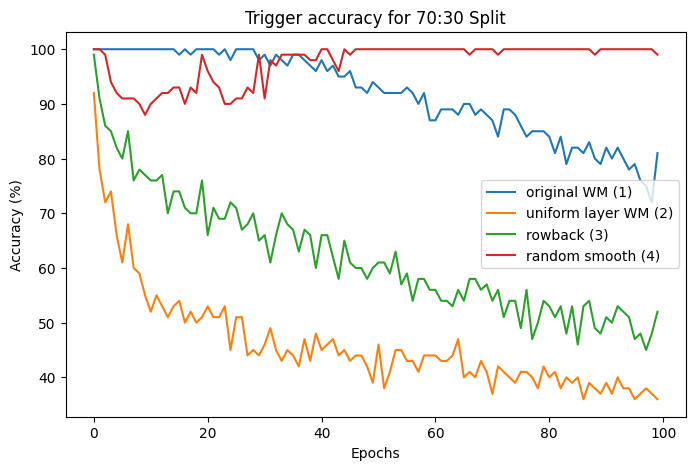

In [44]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metrics10['trigger_acc'])), metrics10['trigger_acc'], label='original WM (1)')
plt.plot(range(len(metrics11['trigger_acc'])), metrics11['trigger_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics12['trigger_acc'])), metrics12['trigger_acc'], label='rowback (3)')

plt.plot(range(len(metrics9['trigger_acc'])), metrics9['trigger_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Trigger accuracy for 70:30 Split')
plt.legend()
plt.savefig('incre_trigger_acc_7030.png')

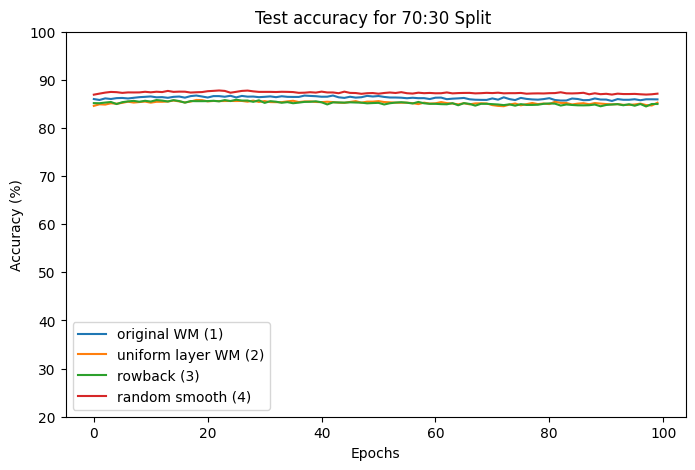

In [45]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(metrics10['val_acc'])), metrics10['val_acc'], label='original WM (1)')
plt.plot(range(len(metrics11['val_acc'])), metrics11['val_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics12['val_acc'])), metrics12['val_acc'], label='rowback (3)')

plt.plot(range(len(metrics9['val_acc'])), metrics9['val_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test accuracy for 70:30 Split ')
plt.ylim([20, 100])

plt.legend()
plt.savefig('incre_test_acc_7030.png')

60:40 Split

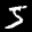

torch.Size([3, 32, 32])


In [46]:
batch_size_train = 256
batch_size_test = 256
batch_size_wm = 64

trainset = datasets.ImageFolder('./data/CIFAR10_6040/with_trigger/train/', transform=transform_train)
incset = datasets.ImageFolder('./data/CIFAR10_6040/with_trigger/train_incre/', transform=transform_train)
testset = datasets.ImageFolder('./data/CIFAR10_6040/test', transform=transform_test)
# valset = datasets.ImageFolder('./data/CIFAR10_6040/with_trigger/val/', transform=transform_test)
watermarkset = datasets.ImageFolder('./data/CIFAR10_6040/with_trigger/trigger_random/', transform=transform_test)
advwatermarkset = datasets.ImageFolder('./data/CIFAR10_6040/with_trigger/trigger_adv/', transform=transform_test)

unrelatedset = watermark_unrelated(count=100)
train_watermark_mixset = torch.utils.data.ConcatDataset((trainset,unrelatedset))


# testset = torchvision.datasets.CIFAR10(
#     root='./data', train=False, download=True, transform=transform_test)

unrelatedloader = torch.utils.data.DataLoader(
    unrelatedset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=8)

# valloader = torch.utils.data.DataLoader(
    # valset, batch_size=batch_size_test, shuffle=False, num_workers=8)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

incloader = torch.utils.data.DataLoader(
    incset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

wmloader = torch.utils.data.DataLoader(
    watermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
advwmloader = torch.utils.data.DataLoader(
    advwatermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
train_watermark_loader = torch.utils.data.DataLoader(
    train_watermark_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

In [47]:
## Sanity Check
print(f"Length of trainset {len(trainset)}")
print(f"Length of incset {len(incset)}")
print(f"Length of testset {len(testset)}")
# print(f"Length of # valset {len(# valset)}")
print(f"Length of watermarkset {len(watermarkset)}")
print(f"Length of advwatermarkset {len(advwatermarkset)}")

Length of trainset 29940
Length of incset 19960
Length of testset 10000
Length of watermarkset 100
Length of advwatermarkset 100


In [48]:
net13 = ResNet18()
net13.load_state_dict(torch.load('./models/wm_cifar10_certify_random_6040.pth')['model_state_dict'])
net14 = ResNet18()
net14.load_state_dict(torch.load('./checkpoints/resnet18_wm_6040.ckpt'))
net15 = ResNet18()
net15.load_state_dict(torch.load('./checkpoints/resnet18_wm_frozen_6040.ckpt'))
net16 = ResNet18()
net16.load_state_dict(torch.load('./checkpoints/resnet18_wm_rowback_6040.ckpt'))

<All keys matched successfully>

In [49]:
evaluator = Evaluator(net13, torch.nn.CrossEntropyLoss())
print(evaluator.eval(testloader))
print(evaluator.eval(unrelatedloader))

{'loss': 0.6674494714140892, 'accuracy': 85.33}
{'loss': 1.9787655332947906e-06, 'accuracy': 100.0}


In [50]:
evaluator = Evaluator(net14, torch.nn.CrossEntropyLoss())
print("Original watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

Original watermarking scheme
Test accuracy {'loss': 0.5254436203360557, 'accuracy': 85.34}
Watermark accuracy {'loss': 0.0002960113750305027, 'accuracy': 100.0}


In [51]:
evaluator = Evaluator(net15, torch.nn.CrossEntropyLoss())
print("Frozen watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

Frozen watermarking scheme
Test accuracy {'loss': 0.5589476055085659, 'accuracy': 84.11}
Watermark accuracy {'loss': 0.001094899047166109, 'accuracy': 100.0}


In [52]:
evaluator = Evaluator(net16, torch.nn.CrossEntropyLoss())
print("ROWBack watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(advwmloader)}")

ROWBack watermarking scheme
Test accuracy {'loss': 0.5498216285943985, 'accuracy': 84.65}
Watermark accuracy {'loss': 0.00111154907848686, 'accuracy': 100.0}


In [53]:
logcmt = f"incre_train_certified_6040"

optimizer13 = torch.optim.SGD(lr=0.001, params=net13.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer13 = Trainer(net13, criterion, optimizer13, incloader)
evaluator13 = Evaluator(net13, criterion)

metrics13 = train(trainer13, evaluator13, testloader, savename='inccheckpoints/incre_train_cert_6040', logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:45<00:00,  1.70it/s]


Epoch 0 | Time 47s| Train Loss 0.5996 | Train Acc 85.27| Val Loss 0.596 | Val Acc 85.86| Trigger Loss 0.004 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.50it/s]


Epoch 1 | Time 57s| Train Loss 0.5049 | Train Acc 85.93| Val Loss 0.545 | Val Acc 85.95| Trigger Loss 0.008 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.42it/s]


Epoch 2 | Time 66s| Train Loss 0.4579 | Train Acc 86.31| Val Loss 0.509 | Val Acc 86.02| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.41it/s]


Epoch 3 | Time 75s| Train Loss 0.4229 | Train Acc 86.70| Val Loss 0.487 | Val Acc 85.86| Trigger Loss 0.020 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.37it/s]


Epoch 4 | Time 83s| Train Loss 0.3983 | Train Acc 87.30| Val Loss 0.475 | Val Acc 86.08| Trigger Loss 0.036 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 5 | Time 92s| Train Loss 0.3801 | Train Acc 87.66| Val Loss 0.463 | Val Acc 86.24| Trigger Loss 0.028 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 6 | Time 101s| Train Loss 0.3724 | Train Acc 87.63| Val Loss 0.453 | Val Acc 86.20| Trigger Loss 0.043 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 7 | Time 109s| Train Loss 0.3576 | Train Acc 88.07| Val Loss 0.451 | Val Acc 86.24| Trigger Loss 0.018 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 8 | Time 118s| Train Loss 0.3469 | Train Acc 88.30| Val Loss 0.445 | Val Acc 86.48| Trigger Loss 0.034 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 9 | Time 127s| Train Loss 0.3455 | Train Acc 88.17| Val Loss 0.439 | Val Acc 86.43| Trigger Loss 0.031 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 10 | Time 136s| Train Loss 0.3399 | Train Acc 88.47| Val Loss 0.437 | Val Acc 86.40| Trigger Loss 0.024 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 11 | Time 145s| Train Loss 0.3307 | Train Acc 88.62| Val Loss 0.433 | Val Acc 86.58| Trigger Loss 0.030 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 12 | Time 154s| Train Loss 0.3234 | Train Acc 88.88| Val Loss 0.431 | Val Acc 86.56| Trigger Loss 0.026 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 13 | Time 162s| Train Loss 0.3194 | Train Acc 89.13| Val Loss 0.429 | Val Acc 86.51| Trigger Loss 0.029 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 14 | Time 171s| Train Loss 0.3162 | Train Acc 89.20| Val Loss 0.437 | Val Acc 86.44| Trigger Loss 0.034 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 15 | Time 180s| Train Loss 0.3069 | Train Acc 89.39| Val Loss 0.430 | Val Acc 86.48| Trigger Loss 0.027 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 16 | Time 188s| Train Loss 0.3016 | Train Acc 89.89| Val Loss 0.431 | Val Acc 86.77| Trigger Loss 0.027 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 17 | Time 197s| Train Loss 0.2978 | Train Acc 89.58| Val Loss 0.426 | Val Acc 86.61| Trigger Loss 0.024 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 18 | Time 206s| Train Loss 0.2977 | Train Acc 89.68| Val Loss 0.430 | Val Acc 86.77| Trigger Loss 0.018 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 19 | Time 215s| Train Loss 0.2900 | Train Acc 90.27| Val Loss 0.427 | Val Acc 86.68| Trigger Loss 0.016 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 20 | Time 224s| Train Loss 0.2844 | Train Acc 90.25| Val Loss 0.429 | Val Acc 86.73| Trigger Loss 0.018 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 21 | Time 233s| Train Loss 0.2783 | Train Acc 90.51| Val Loss 0.430 | Val Acc 86.65| Trigger Loss 0.017 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 22 | Time 241s| Train Loss 0.2766 | Train Acc 90.67| Val Loss 0.430 | Val Acc 86.77| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 23 | Time 250s| Train Loss 0.2713 | Train Acc 90.68| Val Loss 0.430 | Val Acc 86.80| Trigger Loss 0.019 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 24 | Time 259s| Train Loss 0.2682 | Train Acc 90.78| Val Loss 0.431 | Val Acc 86.82| Trigger Loss 0.021 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 25 | Time 268s| Train Loss 0.2653 | Train Acc 91.06| Val Loss 0.430 | Val Acc 86.77| Trigger Loss 0.017 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 26 | Time 277s| Train Loss 0.2569 | Train Acc 91.28| Val Loss 0.434 | Val Acc 86.86| Trigger Loss 0.017 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 27 | Time 286s| Train Loss 0.2585 | Train Acc 90.99| Val Loss 0.436 | Val Acc 86.84| Trigger Loss 0.014 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 28 | Time 295s| Train Loss 0.2512 | Train Acc 91.28| Val Loss 0.438 | Val Acc 86.66| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 29 | Time 304s| Train Loss 0.2510 | Train Acc 91.24| Val Loss 0.440 | Val Acc 86.79| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.33it/s]


Epoch 30 | Time 313s| Train Loss 0.2485 | Train Acc 91.26| Val Loss 0.445 | Val Acc 86.89| Trigger Loss 0.014 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 31 | Time 322s| Train Loss 0.2425 | Train Acc 91.67| Val Loss 0.438 | Val Acc 86.70| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.34it/s]


Epoch 32 | Time 331s| Train Loss 0.2404 | Train Acc 91.49| Val Loss 0.444 | Val Acc 86.82| Trigger Loss 0.015 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 33 | Time 339s| Train Loss 0.2327 | Train Acc 91.98| Val Loss 0.443 | Val Acc 86.72| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 34 | Time 348s| Train Loss 0.2302 | Train Acc 92.10| Val Loss 0.446 | Val Acc 86.88| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 35 | Time 357s| Train Loss 0.2295 | Train Acc 91.93| Val Loss 0.450 | Val Acc 86.60| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 36 | Time 366s| Train Loss 0.2281 | Train Acc 92.28| Val Loss 0.453 | Val Acc 86.74| Trigger Loss 0.011 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 37 | Time 375s| Train Loss 0.2238 | Train Acc 92.42| Val Loss 0.452 | Val Acc 86.91| Trigger Loss 0.015 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 38 | Time 384s| Train Loss 0.2139 | Train Acc 92.71| Val Loss 0.454 | Val Acc 86.75| Trigger Loss 0.017 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 39 | Time 393s| Train Loss 0.2182 | Train Acc 92.66| Val Loss 0.457 | Val Acc 86.68| Trigger Loss 0.018 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 40 | Time 402s| Train Loss 0.2137 | Train Acc 92.55| Val Loss 0.458 | Val Acc 86.80| Trigger Loss 0.022 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 41 | Time 411s| Train Loss 0.2047 | Train Acc 93.11| Val Loss 0.458 | Val Acc 86.95| Trigger Loss 0.024 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 42 | Time 420s| Train Loss 0.2033 | Train Acc 92.95| Val Loss 0.461 | Val Acc 86.66| Trigger Loss 0.024 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 43 | Time 429s| Train Loss 0.1996 | Train Acc 93.13| Val Loss 0.466 | Val Acc 86.80| Trigger Loss 0.015 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 44 | Time 438s| Train Loss 0.1976 | Train Acc 93.11| Val Loss 0.464 | Val Acc 86.78| Trigger Loss 0.010 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 45 | Time 447s| Train Loss 0.1908 | Train Acc 93.60| Val Loss 0.469 | Val Acc 86.56| Trigger Loss 0.012 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 46 | Time 456s| Train Loss 0.1929 | Train Acc 93.44| Val Loss 0.469 | Val Acc 86.50| Trigger Loss 0.022 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 47 | Time 464s| Train Loss 0.1889 | Train Acc 93.70| Val Loss 0.468 | Val Acc 86.61| Trigger Loss 0.023 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 48 | Time 473s| Train Loss 0.1857 | Train Acc 93.71| Val Loss 0.476 | Val Acc 86.57| Trigger Loss 0.015 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.34it/s]


Epoch 49 | Time 482s| Train Loss 0.1822 | Train Acc 93.86| Val Loss 0.477 | Val Acc 86.52| Trigger Loss 0.022 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 50 | Time 491s| Train Loss 0.1828 | Train Acc 93.72| Val Loss 0.476 | Val Acc 86.64| Trigger Loss 0.017 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.33it/s]


Epoch 51 | Time 500s| Train Loss 0.1747 | Train Acc 94.07| Val Loss 0.483 | Val Acc 86.41| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 52 | Time 509s| Train Loss 0.1733 | Train Acc 94.03| Val Loss 0.489 | Val Acc 86.42| Trigger Loss 0.022 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 53 | Time 518s| Train Loss 0.1692 | Train Acc 94.14| Val Loss 0.485 | Val Acc 86.54| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 54 | Time 527s| Train Loss 0.1620 | Train Acc 94.41| Val Loss 0.487 | Val Acc 86.40| Trigger Loss 0.017 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.33it/s]


Epoch 55 | Time 535s| Train Loss 0.1654 | Train Acc 94.39| Val Loss 0.489 | Val Acc 86.42| Trigger Loss 0.019 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 56 | Time 544s| Train Loss 0.1644 | Train Acc 94.41| Val Loss 0.504 | Val Acc 86.09| Trigger Loss 0.017 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.33it/s]


Epoch 57 | Time 553s| Train Loss 0.1573 | Train Acc 94.78| Val Loss 0.499 | Val Acc 86.20| Trigger Loss 0.022 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 58 | Time 562s| Train Loss 0.1571 | Train Acc 94.80| Val Loss 0.499 | Val Acc 86.35| Trigger Loss 0.030 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.23it/s]


Epoch 59 | Time 571s| Train Loss 0.1516 | Train Acc 94.94| Val Loss 0.502 | Val Acc 86.34| Trigger Loss 0.015 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 60 | Time 580s| Train Loss 0.1469 | Train Acc 94.95| Val Loss 0.505 | Val Acc 86.14| Trigger Loss 0.030 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 61 | Time 588s| Train Loss 0.1483 | Train Acc 94.86| Val Loss 0.516 | Val Acc 86.20| Trigger Loss 0.019 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 62 | Time 597s| Train Loss 0.1469 | Train Acc 95.06| Val Loss 0.514 | Val Acc 86.10| Trigger Loss 0.021 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 63 | Time 606s| Train Loss 0.1402 | Train Acc 95.32| Val Loss 0.511 | Val Acc 86.17| Trigger Loss 0.026 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 64 | Time 614s| Train Loss 0.1386 | Train Acc 95.55| Val Loss 0.514 | Val Acc 86.32| Trigger Loss 0.016 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 65 | Time 623s| Train Loss 0.1346 | Train Acc 95.49| Val Loss 0.518 | Val Acc 86.15| Trigger Loss 0.023 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 66 | Time 631s| Train Loss 0.1328 | Train Acc 95.66| Val Loss 0.520 | Val Acc 86.35| Trigger Loss 0.015 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 67 | Time 640s| Train Loss 0.1284 | Train Acc 95.68| Val Loss 0.523 | Val Acc 86.28| Trigger Loss 0.021 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.25it/s]


Epoch 68 | Time 649s| Train Loss 0.1262 | Train Acc 95.69| Val Loss 0.521 | Val Acc 86.22| Trigger Loss 0.031 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 69 | Time 658s| Train Loss 0.1258 | Train Acc 95.99| Val Loss 0.534 | Val Acc 86.30| Trigger Loss 0.031 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 70 | Time 666s| Train Loss 0.1168 | Train Acc 96.18| Val Loss 0.539 | Val Acc 86.08| Trigger Loss 0.035 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 71 | Time 675s| Train Loss 0.1184 | Train Acc 96.01| Val Loss 0.543 | Val Acc 85.93| Trigger Loss 0.023 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 72 | Time 684s| Train Loss 0.1160 | Train Acc 96.14| Val Loss 0.543 | Val Acc 86.09| Trigger Loss 0.027 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 73 | Time 692s| Train Loss 0.1201 | Train Acc 95.67| Val Loss 0.548 | Val Acc 86.05| Trigger Loss 0.020 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.33it/s]


Epoch 74 | Time 701s| Train Loss 0.1109 | Train Acc 96.52| Val Loss 0.551 | Val Acc 86.19| Trigger Loss 0.053 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 75 | Time 710s| Train Loss 0.1139 | Train Acc 96.17| Val Loss 0.545 | Val Acc 86.12| Trigger Loss 0.039 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 76 | Time 718s| Train Loss 0.1110 | Train Acc 96.28| Val Loss 0.553 | Val Acc 86.05| Trigger Loss 0.035 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 77 | Time 727s| Train Loss 0.1076 | Train Acc 96.42| Val Loss 0.556 | Val Acc 85.92| Trigger Loss 0.017 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 78 | Time 736s| Train Loss 0.1004 | Train Acc 96.72| Val Loss 0.555 | Val Acc 86.10| Trigger Loss 0.039 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 79 | Time 745s| Train Loss 0.1013 | Train Acc 96.76| Val Loss 0.553 | Val Acc 86.21| Trigger Loss 0.024 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 80 | Time 753s| Train Loss 0.1049 | Train Acc 96.51| Val Loss 0.563 | Val Acc 86.36| Trigger Loss 0.011 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 81 | Time 762s| Train Loss 0.1023 | Train Acc 96.71| Val Loss 0.561 | Val Acc 86.18| Trigger Loss 0.026 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 82 | Time 771s| Train Loss 0.0938 | Train Acc 96.99| Val Loss 0.565 | Val Acc 86.06| Trigger Loss 0.025 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 83 | Time 780s| Train Loss 0.0990 | Train Acc 96.72| Val Loss 0.569 | Val Acc 85.82| Trigger Loss 0.040 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 84 | Time 788s| Train Loss 0.0939 | Train Acc 96.99| Val Loss 0.566 | Val Acc 85.93| Trigger Loss 0.038 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 85 | Time 797s| Train Loss 0.0913 | Train Acc 96.98| Val Loss 0.582 | Val Acc 86.04| Trigger Loss 0.016 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 86 | Time 806s| Train Loss 0.0870 | Train Acc 97.24| Val Loss 0.581 | Val Acc 86.08| Trigger Loss 0.019 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.34it/s]


Epoch 87 | Time 815s| Train Loss 0.0892 | Train Acc 97.05| Val Loss 0.586 | Val Acc 85.97| Trigger Loss 0.030 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 88 | Time 823s| Train Loss 0.0855 | Train Acc 97.29| Val Loss 0.588 | Val Acc 86.07| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 89 | Time 832s| Train Loss 0.0824 | Train Acc 97.30| Val Loss 0.593 | Val Acc 86.07| Trigger Loss 0.019 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 90 | Time 841s| Train Loss 0.0841 | Train Acc 97.41| Val Loss 0.587 | Val Acc 86.13| Trigger Loss 0.039 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 91 | Time 850s| Train Loss 0.0817 | Train Acc 97.37| Val Loss 0.600 | Val Acc 85.59| Trigger Loss 0.022 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.24it/s]


Epoch 92 | Time 859s| Train Loss 0.0765 | Train Acc 97.52| Val Loss 0.597 | Val Acc 86.06| Trigger Loss 0.035 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 93 | Time 867s| Train Loss 0.0776 | Train Acc 97.57| Val Loss 0.595 | Val Acc 86.02| Trigger Loss 0.023 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 94 | Time 876s| Train Loss 0.0747 | Train Acc 97.74| Val Loss 0.604 | Val Acc 85.96| Trigger Loss 0.009 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 95 | Time 885s| Train Loss 0.0714 | Train Acc 97.76| Val Loss 0.598 | Val Acc 85.92| Trigger Loss 0.042 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 96 | Time 894s| Train Loss 0.0724 | Train Acc 97.90| Val Loss 0.613 | Val Acc 85.78| Trigger Loss 0.030 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 97 | Time 902s| Train Loss 0.0730 | Train Acc 97.75| Val Loss 0.614 | Val Acc 85.81| Trigger Loss 0.044 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 98 | Time 911s| Train Loss 0.0721 | Train Acc 97.78| Val Loss 0.620 | Val Acc 85.82| Trigger Loss 0.029 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 99 | Time 920s| Train Loss 0.0683 | Train Acc 97.92| Val Loss 0.607 | Val Acc 85.85| Trigger Loss 0.031 | Trigger Acc 99.00


In [54]:
logcmt = f"incre_train_baseline_6040"

optimizer14 = torch.optim.SGD(lr=0.001, params=net14.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer14 = Trainer(net14, criterion, optimizer14, incloader)
evaluator14 = Evaluator(net14, criterion)

metrics14 = train(trainer14, evaluator14, testloader, savename='inccheckpoints/incre_train_baseline_6040', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 0 | Time 8s| Train Loss 0.4859 | Train Acc 85.30| Val Loss 0.503 | Val Acc 85.37| Trigger Loss 0.003 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 1 | Time 18s| Train Loss 0.4402 | Train Acc 86.14| Val Loss 0.477 | Val Acc 85.74| Trigger Loss 0.005 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 2 | Time 27s| Train Loss 0.4055 | Train Acc 86.92| Val Loss 0.458 | Val Acc 85.89| Trigger Loss 0.009 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 3 | Time 36s| Train Loss 0.3885 | Train Acc 86.96| Val Loss 0.451 | Val Acc 85.92| Trigger Loss 0.009 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 4 | Time 45s| Train Loss 0.3791 | Train Acc 86.98| Val Loss 0.444 | Val Acc 85.99| Trigger Loss 0.016 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.34it/s]


Epoch 5 | Time 54s| Train Loss 0.3625 | Train Acc 87.69| Val Loss 0.439 | Val Acc 86.00| Trigger Loss 0.036 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 6 | Time 63s| Train Loss 0.3620 | Train Acc 87.53| Val Loss 0.433 | Val Acc 86.15| Trigger Loss 0.028 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 7 | Time 71s| Train Loss 0.3467 | Train Acc 88.16| Val Loss 0.429 | Val Acc 86.31| Trigger Loss 0.024 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 8 | Time 80s| Train Loss 0.3466 | Train Acc 88.04| Val Loss 0.430 | Val Acc 86.06| Trigger Loss 0.056 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 9 | Time 89s| Train Loss 0.3375 | Train Acc 88.38| Val Loss 0.431 | Val Acc 86.31| Trigger Loss 0.041 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 10 | Time 98s| Train Loss 0.3310 | Train Acc 88.65| Val Loss 0.422 | Val Acc 86.20| Trigger Loss 0.042 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 11 | Time 107s| Train Loss 0.3248 | Train Acc 88.65| Val Loss 0.422 | Val Acc 86.02| Trigger Loss 0.031 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 12 | Time 116s| Train Loss 0.3217 | Train Acc 88.99| Val Loss 0.419 | Val Acc 86.35| Trigger Loss 0.046 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 13 | Time 125s| Train Loss 0.3120 | Train Acc 89.30| Val Loss 0.421 | Val Acc 86.34| Trigger Loss 0.072 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 14 | Time 134s| Train Loss 0.3112 | Train Acc 89.36| Val Loss 0.419 | Val Acc 86.37| Trigger Loss 0.062 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 15 | Time 142s| Train Loss 0.3061 | Train Acc 89.33| Val Loss 0.419 | Val Acc 86.22| Trigger Loss 0.079 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 16 | Time 151s| Train Loss 0.3043 | Train Acc 89.44| Val Loss 0.417 | Val Acc 86.53| Trigger Loss 0.092 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 17 | Time 159s| Train Loss 0.3009 | Train Acc 89.44| Val Loss 0.424 | Val Acc 86.26| Trigger Loss 0.129 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 18 | Time 168s| Train Loss 0.2925 | Train Acc 89.75| Val Loss 0.421 | Val Acc 86.29| Trigger Loss 0.086 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 19 | Time 177s| Train Loss 0.2850 | Train Acc 89.99| Val Loss 0.424 | Val Acc 86.45| Trigger Loss 0.099 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 20 | Time 185s| Train Loss 0.2861 | Train Acc 90.02| Val Loss 0.422 | Val Acc 86.44| Trigger Loss 0.103 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 21 | Time 194s| Train Loss 0.2785 | Train Acc 90.26| Val Loss 0.425 | Val Acc 86.31| Trigger Loss 0.081 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 22 | Time 203s| Train Loss 0.2797 | Train Acc 90.43| Val Loss 0.423 | Val Acc 86.32| Trigger Loss 0.102 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 23 | Time 211s| Train Loss 0.2748 | Train Acc 90.19| Val Loss 0.423 | Val Acc 86.48| Trigger Loss 0.123 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 24 | Time 220s| Train Loss 0.2711 | Train Acc 90.64| Val Loss 0.422 | Val Acc 86.27| Trigger Loss 0.123 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 25 | Time 229s| Train Loss 0.2673 | Train Acc 90.84| Val Loss 0.419 | Val Acc 86.65| Trigger Loss 0.160 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 26 | Time 237s| Train Loss 0.2659 | Train Acc 91.03| Val Loss 0.426 | Val Acc 86.28| Trigger Loss 0.156 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 27 | Time 246s| Train Loss 0.2580 | Train Acc 90.94| Val Loss 0.425 | Val Acc 86.40| Trigger Loss 0.149 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 28 | Time 255s| Train Loss 0.2567 | Train Acc 91.19| Val Loss 0.427 | Val Acc 86.62| Trigger Loss 0.191 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 29 | Time 263s| Train Loss 0.2516 | Train Acc 91.43| Val Loss 0.429 | Val Acc 86.41| Trigger Loss 0.170 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 30 | Time 272s| Train Loss 0.2498 | Train Acc 91.27| Val Loss 0.431 | Val Acc 86.30| Trigger Loss 0.190 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 31 | Time 281s| Train Loss 0.2483 | Train Acc 91.55| Val Loss 0.428 | Val Acc 86.52| Trigger Loss 0.212 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 32 | Time 289s| Train Loss 0.2391 | Train Acc 91.84| Val Loss 0.429 | Val Acc 86.57| Trigger Loss 0.192 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 33 | Time 298s| Train Loss 0.2400 | Train Acc 91.69| Val Loss 0.436 | Val Acc 86.21| Trigger Loss 0.217 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 34 | Time 307s| Train Loss 0.2353 | Train Acc 91.93| Val Loss 0.438 | Val Acc 86.31| Trigger Loss 0.266 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 35 | Time 315s| Train Loss 0.2364 | Train Acc 91.91| Val Loss 0.439 | Val Acc 86.52| Trigger Loss 0.239 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 36 | Time 324s| Train Loss 0.2338 | Train Acc 92.01| Val Loss 0.441 | Val Acc 86.36| Trigger Loss 0.265 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 37 | Time 333s| Train Loss 0.2283 | Train Acc 92.13| Val Loss 0.440 | Val Acc 86.53| Trigger Loss 0.279 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 38 | Time 341s| Train Loss 0.2229 | Train Acc 92.35| Val Loss 0.441 | Val Acc 86.49| Trigger Loss 0.354 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 39 | Time 350s| Train Loss 0.2225 | Train Acc 92.42| Val Loss 0.447 | Val Acc 86.18| Trigger Loss 0.338 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 40 | Time 359s| Train Loss 0.2127 | Train Acc 92.62| Val Loss 0.446 | Val Acc 86.44| Trigger Loss 0.309 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 41 | Time 367s| Train Loss 0.2128 | Train Acc 92.71| Val Loss 0.446 | Val Acc 86.68| Trigger Loss 0.317 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 42 | Time 376s| Train Loss 0.2112 | Train Acc 92.73| Val Loss 0.451 | Val Acc 86.42| Trigger Loss 0.311 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 43 | Time 385s| Train Loss 0.2023 | Train Acc 92.96| Val Loss 0.458 | Val Acc 86.43| Trigger Loss 0.406 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 44 | Time 393s| Train Loss 0.2032 | Train Acc 93.02| Val Loss 0.457 | Val Acc 86.56| Trigger Loss 0.389 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 45 | Time 402s| Train Loss 0.2005 | Train Acc 93.19| Val Loss 0.456 | Val Acc 86.49| Trigger Loss 0.389 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 46 | Time 411s| Train Loss 0.1989 | Train Acc 93.15| Val Loss 0.461 | Val Acc 86.52| Trigger Loss 0.364 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 47 | Time 419s| Train Loss 0.1990 | Train Acc 93.10| Val Loss 0.470 | Val Acc 86.04| Trigger Loss 0.477 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 48 | Time 428s| Train Loss 0.1907 | Train Acc 93.53| Val Loss 0.457 | Val Acc 86.43| Trigger Loss 0.421 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 49 | Time 437s| Train Loss 0.1870 | Train Acc 93.68| Val Loss 0.466 | Val Acc 86.41| Trigger Loss 0.387 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 50 | Time 445s| Train Loss 0.1874 | Train Acc 93.67| Val Loss 0.465 | Val Acc 86.27| Trigger Loss 0.403 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 51 | Time 454s| Train Loss 0.1836 | Train Acc 93.63| Val Loss 0.467 | Val Acc 86.46| Trigger Loss 0.425 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 52 | Time 463s| Train Loss 0.1815 | Train Acc 93.70| Val Loss 0.470 | Val Acc 86.51| Trigger Loss 0.416 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 53 | Time 471s| Train Loss 0.1784 | Train Acc 93.87| Val Loss 0.474 | Val Acc 86.43| Trigger Loss 0.449 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 54 | Time 480s| Train Loss 0.1760 | Train Acc 94.08| Val Loss 0.471 | Val Acc 86.38| Trigger Loss 0.424 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 55 | Time 489s| Train Loss 0.1692 | Train Acc 94.32| Val Loss 0.479 | Val Acc 86.46| Trigger Loss 0.416 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 56 | Time 497s| Train Loss 0.1686 | Train Acc 94.30| Val Loss 0.474 | Val Acc 86.62| Trigger Loss 0.521 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 57 | Time 506s| Train Loss 0.1640 | Train Acc 94.41| Val Loss 0.477 | Val Acc 86.37| Trigger Loss 0.491 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 58 | Time 515s| Train Loss 0.1623 | Train Acc 94.35| Val Loss 0.481 | Val Acc 86.37| Trigger Loss 0.473 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 59 | Time 523s| Train Loss 0.1631 | Train Acc 94.44| Val Loss 0.485 | Val Acc 86.26| Trigger Loss 0.495 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 60 | Time 532s| Train Loss 0.1565 | Train Acc 94.66| Val Loss 0.485 | Val Acc 86.26| Trigger Loss 0.649 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.25it/s]


Epoch 61 | Time 541s| Train Loss 0.1535 | Train Acc 94.74| Val Loss 0.490 | Val Acc 86.35| Trigger Loss 0.588 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 62 | Time 549s| Train Loss 0.1545 | Train Acc 94.56| Val Loss 0.497 | Val Acc 86.33| Trigger Loss 0.719 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 63 | Time 558s| Train Loss 0.1516 | Train Acc 94.73| Val Loss 0.497 | Val Acc 85.89| Trigger Loss 0.688 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 64 | Time 567s| Train Loss 0.1448 | Train Acc 95.13| Val Loss 0.496 | Val Acc 86.42| Trigger Loss 0.647 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 65 | Time 575s| Train Loss 0.1443 | Train Acc 95.07| Val Loss 0.501 | Val Acc 86.34| Trigger Loss 0.590 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 66 | Time 584s| Train Loss 0.1400 | Train Acc 95.24| Val Loss 0.501 | Val Acc 86.29| Trigger Loss 0.651 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 67 | Time 593s| Train Loss 0.1437 | Train Acc 95.19| Val Loss 0.506 | Val Acc 86.67| Trigger Loss 0.768 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 68 | Time 601s| Train Loss 0.1375 | Train Acc 95.43| Val Loss 0.506 | Val Acc 86.42| Trigger Loss 0.699 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 69 | Time 610s| Train Loss 0.1367 | Train Acc 95.25| Val Loss 0.515 | Val Acc 86.19| Trigger Loss 0.716 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 70 | Time 618s| Train Loss 0.1314 | Train Acc 95.55| Val Loss 0.519 | Val Acc 86.16| Trigger Loss 0.717 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 71 | Time 627s| Train Loss 0.1288 | Train Acc 95.53| Val Loss 0.524 | Val Acc 86.05| Trigger Loss 0.778 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.33it/s]


Epoch 72 | Time 636s| Train Loss 0.1286 | Train Acc 95.66| Val Loss 0.524 | Val Acc 86.23| Trigger Loss 0.810 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 73 | Time 644s| Train Loss 0.1293 | Train Acc 95.60| Val Loss 0.525 | Val Acc 86.23| Trigger Loss 0.764 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 74 | Time 653s| Train Loss 0.1256 | Train Acc 95.84| Val Loss 0.528 | Val Acc 86.31| Trigger Loss 0.835 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 75 | Time 662s| Train Loss 0.1236 | Train Acc 95.65| Val Loss 0.528 | Val Acc 86.28| Trigger Loss 0.996 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 76 | Time 670s| Train Loss 0.1197 | Train Acc 95.97| Val Loss 0.532 | Val Acc 86.34| Trigger Loss 0.850 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 77 | Time 679s| Train Loss 0.1148 | Train Acc 96.02| Val Loss 0.536 | Val Acc 86.18| Trigger Loss 0.884 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 78 | Time 688s| Train Loss 0.1133 | Train Acc 96.27| Val Loss 0.544 | Val Acc 85.92| Trigger Loss 1.049 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.24it/s]


Epoch 79 | Time 697s| Train Loss 0.1117 | Train Acc 96.25| Val Loss 0.537 | Val Acc 86.14| Trigger Loss 0.949 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 80 | Time 705s| Train Loss 0.1109 | Train Acc 96.24| Val Loss 0.550 | Val Acc 86.23| Trigger Loss 0.942 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 81 | Time 714s| Train Loss 0.1079 | Train Acc 96.48| Val Loss 0.547 | Val Acc 86.04| Trigger Loss 1.066 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 82 | Time 723s| Train Loss 0.1065 | Train Acc 96.39| Val Loss 0.549 | Val Acc 86.18| Trigger Loss 1.087 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 83 | Time 731s| Train Loss 0.1081 | Train Acc 96.37| Val Loss 0.550 | Val Acc 86.00| Trigger Loss 1.031 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 84 | Time 740s| Train Loss 0.1010 | Train Acc 96.66| Val Loss 0.556 | Val Acc 86.29| Trigger Loss 1.124 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 85 | Time 748s| Train Loss 0.0990 | Train Acc 96.89| Val Loss 0.572 | Val Acc 85.89| Trigger Loss 1.167 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 86 | Time 757s| Train Loss 0.0993 | Train Acc 96.55| Val Loss 0.561 | Val Acc 86.22| Trigger Loss 1.267 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 87 | Time 766s| Train Loss 0.0952 | Train Acc 96.82| Val Loss 0.564 | Val Acc 86.09| Trigger Loss 1.210 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 88 | Time 774s| Train Loss 0.0960 | Train Acc 96.85| Val Loss 0.561 | Val Acc 86.00| Trigger Loss 1.101 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 89 | Time 783s| Train Loss 0.0936 | Train Acc 96.92| Val Loss 0.569 | Val Acc 85.99| Trigger Loss 1.181 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 90 | Time 792s| Train Loss 0.0951 | Train Acc 96.71| Val Loss 0.566 | Val Acc 86.01| Trigger Loss 1.132 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 91 | Time 801s| Train Loss 0.0897 | Train Acc 97.12| Val Loss 0.574 | Val Acc 86.10| Trigger Loss 1.289 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 92 | Time 809s| Train Loss 0.0893 | Train Acc 96.95| Val Loss 0.578 | Val Acc 86.01| Trigger Loss 1.208 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 93 | Time 818s| Train Loss 0.0875 | Train Acc 96.98| Val Loss 0.570 | Val Acc 86.12| Trigger Loss 1.177 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 94 | Time 827s| Train Loss 0.0867 | Train Acc 97.23| Val Loss 0.585 | Val Acc 85.91| Trigger Loss 1.148 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 95 | Time 835s| Train Loss 0.0816 | Train Acc 97.33| Val Loss 0.587 | Val Acc 86.09| Trigger Loss 1.232 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 96 | Time 844s| Train Loss 0.0838 | Train Acc 97.14| Val Loss 0.585 | Val Acc 86.06| Trigger Loss 1.195 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 97 | Time 853s| Train Loss 0.0808 | Train Acc 97.35| Val Loss 0.591 | Val Acc 86.19| Trigger Loss 1.346 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 98 | Time 861s| Train Loss 0.0764 | Train Acc 97.57| Val Loss 0.591 | Val Acc 86.10| Trigger Loss 1.304 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 99 | Time 870s| Train Loss 0.0766 | Train Acc 97.38| Val Loss 0.599 | Val Acc 86.13| Trigger Loss 1.431 | Trigger Acc 63.00


In [55]:
logcmt = f"incre_train_baseline_frozen_6040"

optimizer15 = torch.optim.SGD(lr=0.001, params=net15.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer15 = Trainer(net15, criterion, optimizer15, incloader)
evaluator15 = Evaluator(net15, criterion)

metrics15 = train(trainer15, evaluator15, testloader, savename='inccheckpoints/incre_train_baseline_frozen_6040', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 0 | Time 8s| Train Loss 0.5272 | Train Acc 83.59| Val Loss 0.557 | Val Acc 83.72| Trigger Loss 0.404 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 1 | Time 18s| Train Loss 0.4720 | Train Acc 84.64| Val Loss 0.513 | Val Acc 84.52| Trigger Loss 0.589 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 2 | Time 27s| Train Loss 0.4401 | Train Acc 85.16| Val Loss 0.494 | Val Acc 84.68| Trigger Loss 0.643 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.25it/s]


Epoch 3 | Time 35s| Train Loss 0.4166 | Train Acc 85.63| Val Loss 0.481 | Val Acc 85.15| Trigger Loss 0.831 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 4 | Time 44s| Train Loss 0.4049 | Train Acc 85.91| Val Loss 0.477 | Val Acc 84.90| Trigger Loss 0.875 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 5 | Time 53s| Train Loss 0.3965 | Train Acc 86.44| Val Loss 0.465 | Val Acc 85.27| Trigger Loss 1.049 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 6 | Time 62s| Train Loss 0.3879 | Train Acc 86.82| Val Loss 0.463 | Val Acc 85.19| Trigger Loss 1.051 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 7 | Time 70s| Train Loss 0.3760 | Train Acc 87.05| Val Loss 0.463 | Val Acc 85.34| Trigger Loss 1.225 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 8 | Time 79s| Train Loss 0.3687 | Train Acc 87.13| Val Loss 0.462 | Val Acc 85.20| Trigger Loss 1.403 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 9 | Time 87s| Train Loss 0.3651 | Train Acc 87.41| Val Loss 0.467 | Val Acc 84.81| Trigger Loss 1.214 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 10 | Time 96s| Train Loss 0.3534 | Train Acc 87.79| Val Loss 0.458 | Val Acc 85.20| Trigger Loss 1.407 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 11 | Time 105s| Train Loss 0.3512 | Train Acc 87.97| Val Loss 0.451 | Val Acc 85.28| Trigger Loss 1.304 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 12 | Time 113s| Train Loss 0.3434 | Train Acc 88.26| Val Loss 0.454 | Val Acc 85.32| Trigger Loss 1.529 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 13 | Time 122s| Train Loss 0.3360 | Train Acc 88.38| Val Loss 0.452 | Val Acc 85.43| Trigger Loss 1.420 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 14 | Time 131s| Train Loss 0.3309 | Train Acc 88.43| Val Loss 0.463 | Val Acc 85.43| Trigger Loss 1.497 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 15 | Time 139s| Train Loss 0.3259 | Train Acc 88.57| Val Loss 0.455 | Val Acc 85.33| Trigger Loss 1.632 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 16 | Time 148s| Train Loss 0.3241 | Train Acc 88.76| Val Loss 0.455 | Val Acc 85.69| Trigger Loss 1.696 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 17 | Time 157s| Train Loss 0.3158 | Train Acc 89.02| Val Loss 0.451 | Val Acc 85.50| Trigger Loss 1.706 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 18 | Time 165s| Train Loss 0.3092 | Train Acc 89.50| Val Loss 0.451 | Val Acc 85.42| Trigger Loss 1.589 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 19 | Time 174s| Train Loss 0.3088 | Train Acc 89.36| Val Loss 0.456 | Val Acc 85.40| Trigger Loss 1.669 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 20 | Time 183s| Train Loss 0.3020 | Train Acc 89.41| Val Loss 0.455 | Val Acc 85.37| Trigger Loss 1.722 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 21 | Time 191s| Train Loss 0.3006 | Train Acc 89.50| Val Loss 0.465 | Val Acc 85.30| Trigger Loss 1.949 | Trigger Acc 42.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 22 | Time 200s| Train Loss 0.2943 | Train Acc 89.91| Val Loss 0.465 | Val Acc 85.47| Trigger Loss 1.958 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 23 | Time 209s| Train Loss 0.2907 | Train Acc 89.81| Val Loss 0.464 | Val Acc 85.24| Trigger Loss 1.954 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 24 | Time 217s| Train Loss 0.2874 | Train Acc 90.11| Val Loss 0.461 | Val Acc 85.31| Trigger Loss 2.048 | Trigger Acc 42.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 25 | Time 226s| Train Loss 0.2814 | Train Acc 90.14| Val Loss 0.460 | Val Acc 85.43| Trigger Loss 2.038 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.25it/s]


Epoch 26 | Time 235s| Train Loss 0.2817 | Train Acc 90.34| Val Loss 0.462 | Val Acc 85.49| Trigger Loss 1.999 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 27 | Time 243s| Train Loss 0.2725 | Train Acc 90.61| Val Loss 0.467 | Val Acc 85.30| Trigger Loss 2.000 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 28 | Time 252s| Train Loss 0.2682 | Train Acc 90.53| Val Loss 0.463 | Val Acc 85.45| Trigger Loss 1.953 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 29 | Time 261s| Train Loss 0.2615 | Train Acc 90.90| Val Loss 0.466 | Val Acc 85.51| Trigger Loss 1.956 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.25it/s]


Epoch 30 | Time 269s| Train Loss 0.2586 | Train Acc 91.22| Val Loss 0.467 | Val Acc 85.61| Trigger Loss 2.098 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 31 | Time 278s| Train Loss 0.2571 | Train Acc 90.91| Val Loss 0.470 | Val Acc 85.41| Trigger Loss 2.163 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 32 | Time 287s| Train Loss 0.2580 | Train Acc 91.07| Val Loss 0.469 | Val Acc 85.51| Trigger Loss 2.330 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 33 | Time 295s| Train Loss 0.2474 | Train Acc 91.50| Val Loss 0.467 | Val Acc 85.76| Trigger Loss 2.294 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 34 | Time 304s| Train Loss 0.2401 | Train Acc 91.70| Val Loss 0.475 | Val Acc 85.37| Trigger Loss 2.225 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 35 | Time 313s| Train Loss 0.2374 | Train Acc 91.63| Val Loss 0.479 | Val Acc 85.27| Trigger Loss 2.157 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 36 | Time 321s| Train Loss 0.2340 | Train Acc 92.06| Val Loss 0.478 | Val Acc 85.25| Trigger Loss 2.328 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 37 | Time 330s| Train Loss 0.2332 | Train Acc 91.94| Val Loss 0.482 | Val Acc 85.09| Trigger Loss 2.338 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 38 | Time 339s| Train Loss 0.2297 | Train Acc 91.95| Val Loss 0.477 | Val Acc 85.14| Trigger Loss 2.458 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 39 | Time 347s| Train Loss 0.2224 | Train Acc 92.41| Val Loss 0.483 | Val Acc 85.18| Trigger Loss 2.583 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 40 | Time 356s| Train Loss 0.2232 | Train Acc 92.13| Val Loss 0.482 | Val Acc 85.56| Trigger Loss 2.778 | Trigger Acc 30.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 41 | Time 365s| Train Loss 0.2199 | Train Acc 92.49| Val Loss 0.490 | Val Acc 85.01| Trigger Loss 2.606 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 42 | Time 373s| Train Loss 0.2154 | Train Acc 92.74| Val Loss 0.489 | Val Acc 85.36| Trigger Loss 2.433 | Trigger Acc 36.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 43 | Time 382s| Train Loss 0.2081 | Train Acc 92.98| Val Loss 0.496 | Val Acc 85.24| Trigger Loss 2.517 | Trigger Acc 34.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 44 | Time 391s| Train Loss 0.2045 | Train Acc 92.94| Val Loss 0.501 | Val Acc 85.11| Trigger Loss 2.651 | Trigger Acc 34.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 45 | Time 399s| Train Loss 0.2029 | Train Acc 93.05| Val Loss 0.504 | Val Acc 85.19| Trigger Loss 2.679 | Trigger Acc 32.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 46 | Time 408s| Train Loss 0.2003 | Train Acc 93.26| Val Loss 0.501 | Val Acc 85.18| Trigger Loss 2.529 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 47 | Time 417s| Train Loss 0.1976 | Train Acc 93.09| Val Loss 0.504 | Val Acc 85.00| Trigger Loss 2.655 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 48 | Time 425s| Train Loss 0.1919 | Train Acc 93.38| Val Loss 0.523 | Val Acc 84.90| Trigger Loss 2.951 | Trigger Acc 34.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 49 | Time 434s| Train Loss 0.1903 | Train Acc 93.51| Val Loss 0.506 | Val Acc 85.17| Trigger Loss 2.831 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 50 | Time 443s| Train Loss 0.1892 | Train Acc 93.49| Val Loss 0.518 | Val Acc 84.94| Trigger Loss 2.922 | Trigger Acc 34.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 51 | Time 451s| Train Loss 0.1840 | Train Acc 93.56| Val Loss 0.516 | Val Acc 85.03| Trigger Loss 3.008 | Trigger Acc 30.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 52 | Time 460s| Train Loss 0.1818 | Train Acc 93.78| Val Loss 0.515 | Val Acc 84.97| Trigger Loss 3.213 | Trigger Acc 29.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 53 | Time 469s| Train Loss 0.1739 | Train Acc 93.97| Val Loss 0.518 | Val Acc 85.54| Trigger Loss 3.136 | Trigger Acc 34.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 54 | Time 477s| Train Loss 0.1805 | Train Acc 93.76| Val Loss 0.524 | Val Acc 85.03| Trigger Loss 3.282 | Trigger Acc 33.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 55 | Time 486s| Train Loss 0.1742 | Train Acc 94.09| Val Loss 0.524 | Val Acc 85.43| Trigger Loss 2.881 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 56 | Time 495s| Train Loss 0.1680 | Train Acc 94.41| Val Loss 0.541 | Val Acc 84.80| Trigger Loss 3.173 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.33it/s]


Epoch 57 | Time 503s| Train Loss 0.1624 | Train Acc 94.48| Val Loss 0.531 | Val Acc 85.36| Trigger Loss 3.306 | Trigger Acc 33.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 58 | Time 512s| Train Loss 0.1602 | Train Acc 94.52| Val Loss 0.531 | Val Acc 85.24| Trigger Loss 3.359 | Trigger Acc 28.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 59 | Time 520s| Train Loss 0.1607 | Train Acc 94.59| Val Loss 0.534 | Val Acc 85.34| Trigger Loss 3.568 | Trigger Acc 29.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 60 | Time 529s| Train Loss 0.1558 | Train Acc 94.67| Val Loss 0.543 | Val Acc 84.84| Trigger Loss 3.579 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 61 | Time 538s| Train Loss 0.1543 | Train Acc 94.71| Val Loss 0.547 | Val Acc 85.01| Trigger Loss 3.370 | Trigger Acc 31.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 62 | Time 546s| Train Loss 0.1493 | Train Acc 94.91| Val Loss 0.544 | Val Acc 85.26| Trigger Loss 3.413 | Trigger Acc 32.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 63 | Time 555s| Train Loss 0.1497 | Train Acc 94.91| Val Loss 0.551 | Val Acc 85.17| Trigger Loss 3.535 | Trigger Acc 28.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 64 | Time 564s| Train Loss 0.1430 | Train Acc 95.09| Val Loss 0.563 | Val Acc 84.50| Trigger Loss 3.634 | Trigger Acc 26.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 65 | Time 572s| Train Loss 0.1387 | Train Acc 95.44| Val Loss 0.560 | Val Acc 85.03| Trigger Loss 3.498 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 66 | Time 581s| Train Loss 0.1358 | Train Acc 95.27| Val Loss 0.563 | Val Acc 84.74| Trigger Loss 3.648 | Trigger Acc 30.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 67 | Time 590s| Train Loss 0.1392 | Train Acc 95.28| Val Loss 0.562 | Val Acc 85.10| Trigger Loss 3.507 | Trigger Acc 34.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 68 | Time 598s| Train Loss 0.1328 | Train Acc 95.51| Val Loss 0.574 | Val Acc 84.99| Trigger Loss 3.752 | Trigger Acc 28.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 69 | Time 607s| Train Loss 0.1273 | Train Acc 95.79| Val Loss 0.566 | Val Acc 85.23| Trigger Loss 3.942 | Trigger Acc 32.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 70 | Time 616s| Train Loss 0.1265 | Train Acc 95.85| Val Loss 0.586 | Val Acc 84.82| Trigger Loss 3.709 | Trigger Acc 29.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 71 | Time 624s| Train Loss 0.1263 | Train Acc 95.78| Val Loss 0.578 | Val Acc 85.36| Trigger Loss 4.125 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 72 | Time 633s| Train Loss 0.1202 | Train Acc 96.05| Val Loss 0.575 | Val Acc 85.17| Trigger Loss 3.946 | Trigger Acc 28.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 73 | Time 642s| Train Loss 0.1218 | Train Acc 95.87| Val Loss 0.594 | Val Acc 84.76| Trigger Loss 3.905 | Trigger Acc 29.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 74 | Time 650s| Train Loss 0.1186 | Train Acc 96.01| Val Loss 0.603 | Val Acc 84.66| Trigger Loss 4.110 | Trigger Acc 24.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 75 | Time 659s| Train Loss 0.1183 | Train Acc 95.88| Val Loss 0.597 | Val Acc 84.88| Trigger Loss 4.089 | Trigger Acc 28.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 76 | Time 668s| Train Loss 0.1150 | Train Acc 96.16| Val Loss 0.590 | Val Acc 85.19| Trigger Loss 4.147 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 77 | Time 676s| Train Loss 0.1101 | Train Acc 96.36| Val Loss 0.605 | Val Acc 84.93| Trigger Loss 4.112 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 78 | Time 685s| Train Loss 0.1060 | Train Acc 96.53| Val Loss 0.629 | Val Acc 84.43| Trigger Loss 4.054 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 79 | Time 694s| Train Loss 0.1105 | Train Acc 96.27| Val Loss 0.608 | Val Acc 84.80| Trigger Loss 4.014 | Trigger Acc 29.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 80 | Time 702s| Train Loss 0.1024 | Train Acc 96.46| Val Loss 0.608 | Val Acc 84.72| Trigger Loss 4.221 | Trigger Acc 24.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 81 | Time 711s| Train Loss 0.1052 | Train Acc 96.58| Val Loss 0.608 | Val Acc 85.14| Trigger Loss 4.561 | Trigger Acc 26.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 82 | Time 720s| Train Loss 0.1034 | Train Acc 96.40| Val Loss 0.617 | Val Acc 84.81| Trigger Loss 4.224 | Trigger Acc 29.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 83 | Time 728s| Train Loss 0.0976 | Train Acc 96.71| Val Loss 0.613 | Val Acc 85.01| Trigger Loss 4.485 | Trigger Acc 24.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.16it/s]


Epoch 84 | Time 737s| Train Loss 0.0928 | Train Acc 97.02| Val Loss 0.614 | Val Acc 85.19| Trigger Loss 4.256 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:07<00:00, 11.10it/s]


Epoch 85 | Time 746s| Train Loss 0.0918 | Train Acc 97.05| Val Loss 0.629 | Val Acc 84.80| Trigger Loss 4.669 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.35it/s]


Epoch 86 | Time 755s| Train Loss 0.0924 | Train Acc 97.03| Val Loss 0.659 | Val Acc 84.48| Trigger Loss 4.706 | Trigger Acc 30.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 87 | Time 763s| Train Loss 0.0881 | Train Acc 96.94| Val Loss 0.632 | Val Acc 84.86| Trigger Loss 4.753 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.32it/s]


Epoch 88 | Time 772s| Train Loss 0.0860 | Train Acc 97.16| Val Loss 0.629 | Val Acc 84.97| Trigger Loss 4.764 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.21it/s]


Epoch 89 | Time 781s| Train Loss 0.0840 | Train Acc 97.12| Val Loss 0.630 | Val Acc 84.80| Trigger Loss 4.599 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 90 | Time 789s| Train Loss 0.0837 | Train Acc 97.23| Val Loss 0.645 | Val Acc 84.90| Trigger Loss 4.653 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 91 | Time 798s| Train Loss 0.0850 | Train Acc 97.25| Val Loss 0.644 | Val Acc 85.16| Trigger Loss 4.930 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 92 | Time 807s| Train Loss 0.0776 | Train Acc 97.59| Val Loss 0.642 | Val Acc 85.02| Trigger Loss 4.827 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 93 | Time 816s| Train Loss 0.0770 | Train Acc 97.51| Val Loss 0.648 | Val Acc 84.76| Trigger Loss 4.765 | Trigger Acc 21.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 94 | Time 824s| Train Loss 0.0779 | Train Acc 97.43| Val Loss 0.664 | Val Acc 84.51| Trigger Loss 5.123 | Trigger Acc 23.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 95 | Time 833s| Train Loss 0.0787 | Train Acc 97.49| Val Loss 0.644 | Val Acc 85.07| Trigger Loss 5.142 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 96 | Time 842s| Train Loss 0.0748 | Train Acc 97.53| Val Loss 0.651 | Val Acc 85.19| Trigger Loss 5.095 | Trigger Acc 21.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 97 | Time 850s| Train Loss 0.0708 | Train Acc 97.72| Val Loss 0.661 | Val Acc 84.73| Trigger Loss 4.961 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.25it/s]


Epoch 98 | Time 859s| Train Loss 0.0728 | Train Acc 97.75| Val Loss 0.681 | Val Acc 84.79| Trigger Loss 5.496 | Trigger Acc 21.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 99 | Time 868s| Train Loss 0.0711 | Train Acc 97.72| Val Loss 0.682 | Val Acc 84.91| Trigger Loss 5.103 | Trigger Acc 23.00


In [56]:
logcmt = f"incre_train_baseline_rowback_6040"

optimizer16 = torch.optim.SGD(lr=0.001, params=net16.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer16 = Trainer(net16, criterion, optimizer16, incloader)
evaluator16 = Evaluator(net16, criterion)

metrics16 = train(trainer16, evaluator16, testloader, savename='inccheckpoints/incre_train_baseline_rowback_6040', logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.25it/s]


Epoch 0 | Time 8s| Train Loss 0.5134 | Train Acc 83.90| Val Loss 0.547 | Val Acc 83.94| Trigger Loss 0.203 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 1 | Time 18s| Train Loss 0.4618 | Train Acc 84.93| Val Loss 0.514 | Val Acc 84.54| Trigger Loss 0.381 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.25it/s]


Epoch 2 | Time 27s| Train Loss 0.4321 | Train Acc 85.50| Val Loss 0.495 | Val Acc 84.69| Trigger Loss 0.544 | Trigger Acc 84.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 3 | Time 36s| Train Loss 0.4154 | Train Acc 85.98| Val Loss 0.478 | Val Acc 85.11| Trigger Loss 0.422 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 4 | Time 44s| Train Loss 0.3994 | Train Acc 86.47| Val Loss 0.468 | Val Acc 85.22| Trigger Loss 0.509 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.25it/s]


Epoch 5 | Time 53s| Train Loss 0.3938 | Train Acc 86.37| Val Loss 0.470 | Val Acc 85.11| Trigger Loss 0.558 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 6 | Time 62s| Train Loss 0.3834 | Train Acc 86.91| Val Loss 0.471 | Val Acc 85.07| Trigger Loss 0.620 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 7 | Time 70s| Train Loss 0.3730 | Train Acc 87.06| Val Loss 0.458 | Val Acc 85.22| Trigger Loss 0.643 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 8 | Time 79s| Train Loss 0.3665 | Train Acc 87.55| Val Loss 0.462 | Val Acc 85.23| Trigger Loss 0.611 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 9 | Time 88s| Train Loss 0.3583 | Train Acc 87.52| Val Loss 0.455 | Val Acc 85.55| Trigger Loss 0.727 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 10 | Time 96s| Train Loss 0.3460 | Train Acc 88.25| Val Loss 0.463 | Val Acc 85.08| Trigger Loss 0.729 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 11 | Time 105s| Train Loss 0.3439 | Train Acc 88.14| Val Loss 0.454 | Val Acc 85.47| Trigger Loss 0.902 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 12 | Time 114s| Train Loss 0.3428 | Train Acc 88.28| Val Loss 0.454 | Val Acc 85.45| Trigger Loss 0.747 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 13 | Time 122s| Train Loss 0.3329 | Train Acc 88.40| Val Loss 0.450 | Val Acc 85.51| Trigger Loss 0.819 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 14 | Time 131s| Train Loss 0.3290 | Train Acc 88.52| Val Loss 0.454 | Val Acc 85.67| Trigger Loss 0.997 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 15 | Time 140s| Train Loss 0.3276 | Train Acc 88.80| Val Loss 0.457 | Val Acc 85.43| Trigger Loss 0.944 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 16 | Time 148s| Train Loss 0.3199 | Train Acc 88.98| Val Loss 0.454 | Val Acc 85.48| Trigger Loss 0.953 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 17 | Time 157s| Train Loss 0.3145 | Train Acc 89.11| Val Loss 0.458 | Val Acc 85.37| Trigger Loss 0.862 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 18 | Time 166s| Train Loss 0.3102 | Train Acc 89.23| Val Loss 0.456 | Val Acc 85.46| Trigger Loss 0.951 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 19 | Time 175s| Train Loss 0.3064 | Train Acc 89.38| Val Loss 0.457 | Val Acc 85.63| Trigger Loss 0.877 | Trigger Acc 72.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 20 | Time 183s| Train Loss 0.3065 | Train Acc 89.43| Val Loss 0.459 | Val Acc 85.47| Trigger Loss 1.141 | Trigger Acc 60.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 21 | Time 192s| Train Loss 0.2980 | Train Acc 89.83| Val Loss 0.460 | Val Acc 85.48| Trigger Loss 1.103 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 22 | Time 201s| Train Loss 0.2920 | Train Acc 89.84| Val Loss 0.459 | Val Acc 85.58| Trigger Loss 1.002 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 23 | Time 209s| Train Loss 0.2909 | Train Acc 89.77| Val Loss 0.456 | Val Acc 85.95| Trigger Loss 1.001 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 24 | Time 218s| Train Loss 0.2844 | Train Acc 90.10| Val Loss 0.464 | Val Acc 85.63| Trigger Loss 1.143 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 25 | Time 227s| Train Loss 0.2838 | Train Acc 90.14| Val Loss 0.459 | Val Acc 85.85| Trigger Loss 1.093 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 26 | Time 235s| Train Loss 0.2742 | Train Acc 90.45| Val Loss 0.455 | Val Acc 85.70| Trigger Loss 0.978 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.23it/s]


Epoch 27 | Time 244s| Train Loss 0.2666 | Train Acc 90.70| Val Loss 0.460 | Val Acc 85.61| Trigger Loss 1.152 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 28 | Time 253s| Train Loss 0.2668 | Train Acc 90.56| Val Loss 0.468 | Val Acc 85.71| Trigger Loss 1.121 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 29 | Time 262s| Train Loss 0.2655 | Train Acc 90.82| Val Loss 0.470 | Val Acc 85.49| Trigger Loss 1.313 | Trigger Acc 57.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.22it/s]


Epoch 30 | Time 270s| Train Loss 0.2607 | Train Acc 91.04| Val Loss 0.470 | Val Acc 85.44| Trigger Loss 1.268 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 31 | Time 279s| Train Loss 0.2564 | Train Acc 91.31| Val Loss 0.470 | Val Acc 85.61| Trigger Loss 1.454 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 32 | Time 288s| Train Loss 0.2485 | Train Acc 91.52| Val Loss 0.471 | Val Acc 85.76| Trigger Loss 1.285 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 33 | Time 296s| Train Loss 0.2463 | Train Acc 91.56| Val Loss 0.475 | Val Acc 85.47| Trigger Loss 1.243 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 34 | Time 305s| Train Loss 0.2444 | Train Acc 91.43| Val Loss 0.476 | Val Acc 85.41| Trigger Loss 1.652 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.25it/s]


Epoch 35 | Time 314s| Train Loss 0.2415 | Train Acc 91.51| Val Loss 0.475 | Val Acc 85.53| Trigger Loss 1.366 | Trigger Acc 57.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.24it/s]


Epoch 36 | Time 323s| Train Loss 0.2344 | Train Acc 91.91| Val Loss 0.474 | Val Acc 85.82| Trigger Loss 1.389 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 37 | Time 331s| Train Loss 0.2369 | Train Acc 91.85| Val Loss 0.479 | Val Acc 85.62| Trigger Loss 1.623 | Trigger Acc 49.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 38 | Time 340s| Train Loss 0.2293 | Train Acc 92.01| Val Loss 0.478 | Val Acc 85.80| Trigger Loss 1.471 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 39 | Time 349s| Train Loss 0.2241 | Train Acc 92.46| Val Loss 0.489 | Val Acc 85.58| Trigger Loss 1.265 | Trigger Acc 57.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 40 | Time 357s| Train Loss 0.2210 | Train Acc 92.22| Val Loss 0.489 | Val Acc 85.77| Trigger Loss 1.687 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 41 | Time 366s| Train Loss 0.2207 | Train Acc 92.46| Val Loss 0.491 | Val Acc 85.55| Trigger Loss 1.520 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 42 | Time 375s| Train Loss 0.2149 | Train Acc 92.70| Val Loss 0.491 | Val Acc 85.54| Trigger Loss 1.471 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 43 | Time 383s| Train Loss 0.2145 | Train Acc 92.60| Val Loss 0.501 | Val Acc 85.33| Trigger Loss 1.660 | Trigger Acc 49.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 44 | Time 392s| Train Loss 0.2056 | Train Acc 93.02| Val Loss 0.495 | Val Acc 85.42| Trigger Loss 1.622 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 45 | Time 401s| Train Loss 0.2048 | Train Acc 92.99| Val Loss 0.506 | Val Acc 85.48| Trigger Loss 1.590 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 46 | Time 409s| Train Loss 0.2040 | Train Acc 92.88| Val Loss 0.507 | Val Acc 85.25| Trigger Loss 1.911 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 47 | Time 418s| Train Loss 0.1978 | Train Acc 93.38| Val Loss 0.502 | Val Acc 85.64| Trigger Loss 1.956 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 48 | Time 427s| Train Loss 0.1947 | Train Acc 93.43| Val Loss 0.502 | Val Acc 85.53| Trigger Loss 1.968 | Trigger Acc 42.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 49 | Time 436s| Train Loss 0.1918 | Train Acc 93.55| Val Loss 0.501 | Val Acc 85.51| Trigger Loss 1.870 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 50 | Time 444s| Train Loss 0.1858 | Train Acc 93.63| Val Loss 0.507 | Val Acc 85.42| Trigger Loss 1.932 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.31it/s]


Epoch 51 | Time 453s| Train Loss 0.1782 | Train Acc 93.80| Val Loss 0.515 | Val Acc 85.51| Trigger Loss 2.008 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 52 | Time 462s| Train Loss 0.1822 | Train Acc 93.82| Val Loss 0.516 | Val Acc 85.33| Trigger Loss 1.990 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 53 | Time 470s| Train Loss 0.1823 | Train Acc 93.83| Val Loss 0.523 | Val Acc 85.23| Trigger Loss 1.913 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 54 | Time 479s| Train Loss 0.1760 | Train Acc 93.85| Val Loss 0.519 | Val Acc 85.43| Trigger Loss 2.297 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 55 | Time 488s| Train Loss 0.1677 | Train Acc 94.17| Val Loss 0.532 | Val Acc 85.35| Trigger Loss 2.044 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.25it/s]


Epoch 56 | Time 496s| Train Loss 0.1706 | Train Acc 94.37| Val Loss 0.532 | Val Acc 85.36| Trigger Loss 2.208 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.25it/s]


Epoch 57 | Time 505s| Train Loss 0.1630 | Train Acc 94.48| Val Loss 0.533 | Val Acc 85.13| Trigger Loss 2.031 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.23it/s]


Epoch 58 | Time 514s| Train Loss 0.1598 | Train Acc 94.48| Val Loss 0.540 | Val Acc 85.13| Trigger Loss 2.085 | Trigger Acc 42.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 59 | Time 523s| Train Loss 0.1570 | Train Acc 94.75| Val Loss 0.536 | Val Acc 85.74| Trigger Loss 2.137 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 60 | Time 531s| Train Loss 0.1526 | Train Acc 94.63| Val Loss 0.541 | Val Acc 85.52| Trigger Loss 2.294 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.24it/s]


Epoch 61 | Time 540s| Train Loss 0.1548 | Train Acc 94.71| Val Loss 0.537 | Val Acc 85.61| Trigger Loss 2.108 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 62 | Time 549s| Train Loss 0.1460 | Train Acc 94.96| Val Loss 0.534 | Val Acc 85.73| Trigger Loss 2.386 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 63 | Time 557s| Train Loss 0.1436 | Train Acc 95.23| Val Loss 0.562 | Val Acc 84.97| Trigger Loss 2.205 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.24it/s]


Epoch 64 | Time 566s| Train Loss 0.1472 | Train Acc 94.93| Val Loss 0.555 | Val Acc 85.40| Trigger Loss 2.439 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 65 | Time 575s| Train Loss 0.1438 | Train Acc 95.00| Val Loss 0.570 | Val Acc 84.95| Trigger Loss 2.505 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 66 | Time 583s| Train Loss 0.1416 | Train Acc 95.18| Val Loss 0.547 | Val Acc 85.50| Trigger Loss 2.539 | Trigger Acc 36.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 67 | Time 592s| Train Loss 0.1361 | Train Acc 95.39| Val Loss 0.563 | Val Acc 85.60| Trigger Loss 2.599 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 68 | Time 601s| Train Loss 0.1331 | Train Acc 95.63| Val Loss 0.574 | Val Acc 85.08| Trigger Loss 2.351 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 69 | Time 610s| Train Loss 0.1341 | Train Acc 95.65| Val Loss 0.561 | Val Acc 85.47| Trigger Loss 2.341 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 70 | Time 618s| Train Loss 0.1244 | Train Acc 95.82| Val Loss 0.567 | Val Acc 85.44| Trigger Loss 2.520 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 71 | Time 627s| Train Loss 0.1257 | Train Acc 95.78| Val Loss 0.579 | Val Acc 85.34| Trigger Loss 2.509 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 72 | Time 636s| Train Loss 0.1186 | Train Acc 95.97| Val Loss 0.568 | Val Acc 85.24| Trigger Loss 2.581 | Trigger Acc 41.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 73 | Time 644s| Train Loss 0.1266 | Train Acc 95.73| Val Loss 0.598 | Val Acc 85.20| Trigger Loss 2.639 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 74 | Time 653s| Train Loss 0.1184 | Train Acc 96.05| Val Loss 0.588 | Val Acc 85.14| Trigger Loss 2.772 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 75 | Time 662s| Train Loss 0.1192 | Train Acc 96.09| Val Loss 0.578 | Val Acc 85.29| Trigger Loss 2.688 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.23it/s]


Epoch 76 | Time 671s| Train Loss 0.1157 | Train Acc 95.98| Val Loss 0.588 | Val Acc 85.36| Trigger Loss 2.891 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 77 | Time 679s| Train Loss 0.1159 | Train Acc 96.07| Val Loss 0.588 | Val Acc 85.46| Trigger Loss 2.940 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 78 | Time 688s| Train Loss 0.1093 | Train Acc 96.31| Val Loss 0.591 | Val Acc 85.40| Trigger Loss 2.840 | Trigger Acc 36.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 79 | Time 697s| Train Loss 0.1079 | Train Acc 96.46| Val Loss 0.590 | Val Acc 85.29| Trigger Loss 3.135 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 80 | Time 705s| Train Loss 0.1049 | Train Acc 96.44| Val Loss 0.603 | Val Acc 85.07| Trigger Loss 3.088 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.25it/s]


Epoch 81 | Time 714s| Train Loss 0.1051 | Train Acc 96.37| Val Loss 0.604 | Val Acc 85.17| Trigger Loss 2.730 | Trigger Acc 42.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 82 | Time 723s| Train Loss 0.1008 | Train Acc 96.57| Val Loss 0.598 | Val Acc 85.11| Trigger Loss 2.747 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 83 | Time 732s| Train Loss 0.1011 | Train Acc 96.76| Val Loss 0.594 | Val Acc 85.52| Trigger Loss 3.068 | Trigger Acc 36.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 84 | Time 740s| Train Loss 0.0975 | Train Acc 96.81| Val Loss 0.609 | Val Acc 85.51| Trigger Loss 3.170 | Trigger Acc 34.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 85 | Time 749s| Train Loss 0.0952 | Train Acc 96.82| Val Loss 0.608 | Val Acc 85.56| Trigger Loss 3.129 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.30it/s]


Epoch 86 | Time 758s| Train Loss 0.0924 | Train Acc 96.90| Val Loss 0.617 | Val Acc 85.42| Trigger Loss 3.306 | Trigger Acc 34.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 87 | Time 766s| Train Loss 0.0934 | Train Acc 96.82| Val Loss 0.621 | Val Acc 85.15| Trigger Loss 3.083 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 88 | Time 775s| Train Loss 0.0917 | Train Acc 96.93| Val Loss 0.619 | Val Acc 85.34| Trigger Loss 3.235 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 89 | Time 784s| Train Loss 0.0890 | Train Acc 97.07| Val Loss 0.630 | Val Acc 85.03| Trigger Loss 3.140 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 90 | Time 792s| Train Loss 0.0892 | Train Acc 97.16| Val Loss 0.629 | Val Acc 85.21| Trigger Loss 3.500 | Trigger Acc 32.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 91 | Time 801s| Train Loss 0.0839 | Train Acc 97.15| Val Loss 0.647 | Val Acc 85.10| Trigger Loss 3.366 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 92 | Time 810s| Train Loss 0.0808 | Train Acc 97.39| Val Loss 0.639 | Val Acc 85.34| Trigger Loss 3.464 | Trigger Acc 32.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.25it/s]


Epoch 93 | Time 819s| Train Loss 0.0813 | Train Acc 97.30| Val Loss 0.628 | Val Acc 85.54| Trigger Loss 3.698 | Trigger Acc 31.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.29it/s]


Epoch 94 | Time 827s| Train Loss 0.0824 | Train Acc 97.19| Val Loss 0.642 | Val Acc 85.20| Trigger Loss 3.533 | Trigger Acc 32.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 95 | Time 836s| Train Loss 0.0728 | Train Acc 97.58| Val Loss 0.639 | Val Acc 85.40| Trigger Loss 3.437 | Trigger Acc 31.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 96 | Time 845s| Train Loss 0.0730 | Train Acc 97.64| Val Loss 0.646 | Val Acc 85.43| Trigger Loss 3.488 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.26it/s]


Epoch 97 | Time 853s| Train Loss 0.0760 | Train Acc 97.58| Val Loss 0.632 | Val Acc 85.71| Trigger Loss 3.350 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.28it/s]


Epoch 98 | Time 862s| Train Loss 0.0684 | Train Acc 97.87| Val Loss 0.656 | Val Acc 85.24| Trigger Loss 3.423 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 11.27it/s]


Epoch 99 | Time 871s| Train Loss 0.0682 | Train Acc 97.82| Val Loss 0.648 | Val Acc 85.17| Trigger Loss 3.307 | Trigger Acc 34.00


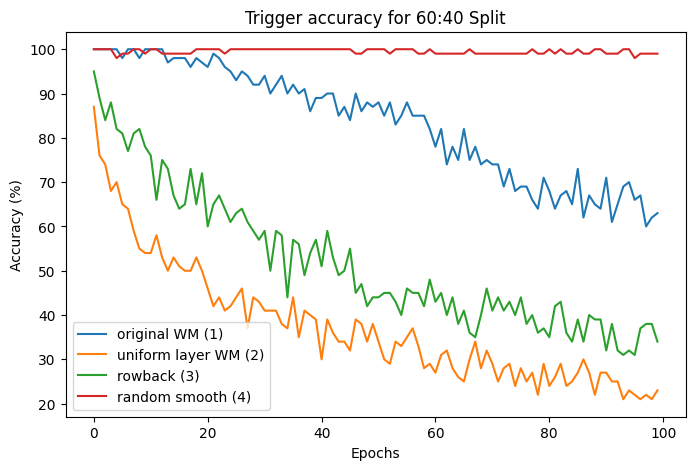

In [57]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metrics14['trigger_acc'])), metrics14['trigger_acc'], label='original WM (1)')
plt.plot(range(len(metrics15['trigger_acc'])), metrics15['trigger_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics16['trigger_acc'])), metrics16['trigger_acc'], label='rowback (3)')

plt.plot(range(len(metrics13['trigger_acc'])), metrics13['trigger_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Trigger accuracy for 60:40 Split')
plt.legend()
plt.savefig('incre_trigger_acc_6040.png')

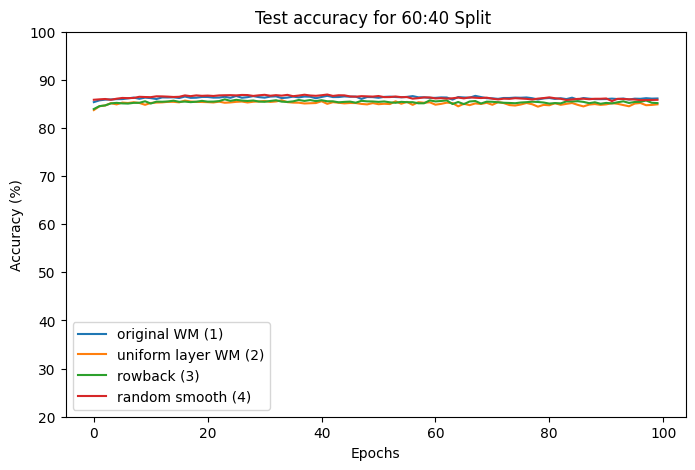

In [58]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(metrics14['val_acc'])), metrics14['val_acc'], label='original WM (1)')
plt.plot(range(len(metrics15['val_acc'])), metrics15['val_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics16['val_acc'])), metrics16['val_acc'], label='rowback (3)')

plt.plot(range(len(metrics13['val_acc'])), metrics13['val_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim([20, 100])

plt.title('Test accuracy for 60:40 Split ')
plt.legend()
plt.savefig('incre_test_acc_6040.png')

50:50 Split

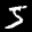

torch.Size([3, 32, 32])


In [59]:
batch_size_train = 256
batch_size_test = 256
batch_size_wm = 64

trainset = datasets.ImageFolder('./data/CIFAR10_5050/with_trigger/train/', transform=transform_train)
incset = datasets.ImageFolder('./data/CIFAR10_5050/with_trigger/train_incre/', transform=transform_train)
testset = datasets.ImageFolder('./data/CIFAR10_5050/test', transform=transform_test)
# valset = datasets.ImageFolder('./data/CIFAR10_5050/with_trigger/val/', transform=transform_test)
watermarkset = datasets.ImageFolder('./data/CIFAR10_5050/with_trigger/trigger_random/', transform=transform_test)
advwatermarkset = datasets.ImageFolder('./data/CIFAR10_5050/with_trigger/trigger_adv/', transform=transform_test)

unrelatedset = watermark_unrelated(count=100)
train_watermark_mixset = torch.utils.data.ConcatDataset((trainset,unrelatedset))


# testset = torchvision.datasets.CIFAR10(
#     root='./data', train=False, download=True, transform=transform_test)

unrelatedloader = torch.utils.data.DataLoader(
    unrelatedset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=8)

# valloader = torch.utils.data.DataLoader(
    # valset, batch_size=batch_size_test, shuffle=False, num_workers=8)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

incloader = torch.utils.data.DataLoader(
    incset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

wmloader = torch.utils.data.DataLoader(
    watermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
advwmloader = torch.utils.data.DataLoader(
    advwatermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
train_watermark_loader = torch.utils.data.DataLoader(
    train_watermark_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

In [60]:
## Sanity Check
print(f"Length of trainset {len(trainset)}")
print(f"Length of incset {len(incset)}")
print(f"Length of testset {len(testset)}")
# print(f"Length of # valset {len(# valset)}")
print(f"Length of watermarkset {len(watermarkset)}")
print(f"Length of advwatermarkset {len(advwatermarkset)}")

Length of trainset 24950
Length of incset 24950
Length of testset 10000
Length of watermarkset 100
Length of advwatermarkset 100


In [61]:
net17 = ResNet18()
net17.load_state_dict(torch.load('./models/wm_cifar10_certify_random_5050.pth')['model_state_dict'])
net18 = ResNet18()
net18.load_state_dict(torch.load('./checkpoints/resnet18_wm_5050.ckpt'))
net19 = ResNet18()
net19.load_state_dict(torch.load('./checkpoints/resnet18_wm_frozen_5050.ckpt'))
net20 = ResNet18()
net20.load_state_dict(torch.load('./checkpoints/resnet18_wm_rowback_5050.ckpt'))

<All keys matched successfully>

In [62]:
evaluator = Evaluator(net17, torch.nn.CrossEntropyLoss())
print(evaluator.eval(testloader))
print(evaluator.eval(unrelatedloader))

{'loss': 0.6293113184452057, 'accuracy': 83.73}
{'loss': 0.004691037032753229, 'accuracy': 100.0}


In [63]:
evaluator = Evaluator(net18, torch.nn.CrossEntropyLoss())
print("Original watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

Original watermarking scheme
Test accuracy {'loss': 0.5299516744375229, 'accuracy': 84.08}
Watermark accuracy {'loss': 0.00041156554711051284, 'accuracy': 100.0}


In [64]:
evaluator = Evaluator(net19, torch.nn.CrossEntropyLoss())
print("Frozen watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

Frozen watermarking scheme
Test accuracy {'loss': 0.6006855473995208, 'accuracy': 82.45}
Watermark accuracy {'loss': 0.0015887392638251185, 'accuracy': 100.0}


In [65]:
evaluator = Evaluator(net20, torch.nn.CrossEntropyLoss())
print("ROWBack watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(advwmloader)}")

ROWBack watermarking scheme
Test accuracy {'loss': 0.59068175740242, 'accuracy': 82.67999999999999}
Watermark accuracy {'loss': 0.001447119927033782, 'accuracy': 100.0}


In [66]:
logcmt = f"incre_train_certified_5050"

optimizer17 = torch.optim.SGD(lr=0.001, params=net17.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer17 = Trainer(net17, criterion, optimizer17, incloader)
evaluator17 = Evaluator(net17, criterion)

metrics17 = train(trainer17, evaluator17, testloader, savename='inccheckpoints/incre_train_cert_5050', logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.74it/s]


Epoch 0 | Time 57s| Train Loss 0.5906 | Train Acc 84.40| Val Loss 0.601 | Val Acc 85.14| Trigger Loss 0.002 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.59it/s]


Epoch 1 | Time 69s| Train Loss 0.5019 | Train Acc 85.48| Val Loss 0.543 | Val Acc 85.41| Trigger Loss 0.023 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.51it/s]


Epoch 2 | Time 80s| Train Loss 0.4635 | Train Acc 85.90| Val Loss 0.509 | Val Acc 85.78| Trigger Loss 0.036 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.46it/s]


Epoch 3 | Time 90s| Train Loss 0.4301 | Train Acc 86.25| Val Loss 0.495 | Val Acc 85.76| Trigger Loss 0.042 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.34it/s]


Epoch 4 | Time 101s| Train Loss 0.4122 | Train Acc 86.58| Val Loss 0.478 | Val Acc 85.85| Trigger Loss 0.049 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.39it/s]


Epoch 5 | Time 112s| Train Loss 0.4032 | Train Acc 86.57| Val Loss 0.464 | Val Acc 85.75| Trigger Loss 0.081 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.38it/s]


Epoch 6 | Time 122s| Train Loss 0.3894 | Train Acc 86.87| Val Loss 0.458 | Val Acc 85.79| Trigger Loss 0.072 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.35it/s]


Epoch 7 | Time 133s| Train Loss 0.3807 | Train Acc 87.09| Val Loss 0.452 | Val Acc 85.99| Trigger Loss 0.086 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.36it/s]


Epoch 8 | Time 144s| Train Loss 0.3720 | Train Acc 87.30| Val Loss 0.445 | Val Acc 86.26| Trigger Loss 0.116 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.36it/s]


Epoch 9 | Time 154s| Train Loss 0.3655 | Train Acc 87.60| Val Loss 0.441 | Val Acc 86.07| Trigger Loss 0.150 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.35it/s]


Epoch 10 | Time 164s| Train Loss 0.3544 | Train Acc 87.80| Val Loss 0.442 | Val Acc 85.90| Trigger Loss 0.125 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.30it/s]


Epoch 11 | Time 175s| Train Loss 0.3482 | Train Acc 88.10| Val Loss 0.437 | Val Acc 86.26| Trigger Loss 0.128 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.35it/s]


Epoch 12 | Time 185s| Train Loss 0.3460 | Train Acc 88.07| Val Loss 0.438 | Val Acc 86.41| Trigger Loss 0.156 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.35it/s]


Epoch 13 | Time 196s| Train Loss 0.3449 | Train Acc 88.10| Val Loss 0.432 | Val Acc 86.17| Trigger Loss 0.275 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.33it/s]


Epoch 14 | Time 206s| Train Loss 0.3330 | Train Acc 88.88| Val Loss 0.435 | Val Acc 86.17| Trigger Loss 0.162 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.36it/s]


Epoch 15 | Time 217s| Train Loss 0.3337 | Train Acc 88.36| Val Loss 0.433 | Val Acc 86.32| Trigger Loss 0.204 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.28it/s]


Epoch 16 | Time 227s| Train Loss 0.3240 | Train Acc 88.97| Val Loss 0.429 | Val Acc 86.36| Trigger Loss 0.188 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.34it/s]


Epoch 17 | Time 237s| Train Loss 0.3221 | Train Acc 89.01| Val Loss 0.431 | Val Acc 86.29| Trigger Loss 0.116 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.34it/s]


Epoch 18 | Time 248s| Train Loss 0.3190 | Train Acc 89.07| Val Loss 0.427 | Val Acc 86.36| Trigger Loss 0.076 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.32it/s]


Epoch 19 | Time 258s| Train Loss 0.3188 | Train Acc 89.07| Val Loss 0.429 | Val Acc 86.37| Trigger Loss 0.113 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.35it/s]


Epoch 20 | Time 269s| Train Loss 0.3103 | Train Acc 89.07| Val Loss 0.430 | Val Acc 86.34| Trigger Loss 0.118 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.35it/s]


Epoch 21 | Time 279s| Train Loss 0.3080 | Train Acc 89.38| Val Loss 0.428 | Val Acc 86.41| Trigger Loss 0.147 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.36it/s]


Epoch 22 | Time 290s| Train Loss 0.3044 | Train Acc 89.46| Val Loss 0.431 | Val Acc 86.27| Trigger Loss 0.154 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.34it/s]


Epoch 23 | Time 300s| Train Loss 0.2944 | Train Acc 89.91| Val Loss 0.432 | Val Acc 86.50| Trigger Loss 0.180 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.33it/s]


Epoch 24 | Time 311s| Train Loss 0.2903 | Train Acc 90.08| Val Loss 0.434 | Val Acc 86.43| Trigger Loss 0.156 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.35it/s]


Epoch 25 | Time 321s| Train Loss 0.2873 | Train Acc 89.98| Val Loss 0.433 | Val Acc 86.45| Trigger Loss 0.162 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.36it/s]


Epoch 26 | Time 331s| Train Loss 0.2851 | Train Acc 90.01| Val Loss 0.435 | Val Acc 86.56| Trigger Loss 0.160 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.36it/s]


Epoch 27 | Time 342s| Train Loss 0.2836 | Train Acc 90.37| Val Loss 0.434 | Val Acc 86.30| Trigger Loss 0.198 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.36it/s]


Epoch 28 | Time 352s| Train Loss 0.2777 | Train Acc 90.67| Val Loss 0.437 | Val Acc 86.54| Trigger Loss 0.165 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.36it/s]


Epoch 29 | Time 363s| Train Loss 0.2733 | Train Acc 90.52| Val Loss 0.433 | Val Acc 86.35| Trigger Loss 0.256 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.37it/s]


Epoch 30 | Time 373s| Train Loss 0.2738 | Train Acc 90.63| Val Loss 0.438 | Val Acc 86.45| Trigger Loss 0.259 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.36it/s]


Epoch 31 | Time 383s| Train Loss 0.2644 | Train Acc 90.81| Val Loss 0.438 | Val Acc 86.41| Trigger Loss 0.319 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.36it/s]


Epoch 32 | Time 394s| Train Loss 0.2666 | Train Acc 90.96| Val Loss 0.438 | Val Acc 86.43| Trigger Loss 0.306 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.37it/s]


Epoch 33 | Time 404s| Train Loss 0.2609 | Train Acc 91.00| Val Loss 0.441 | Val Acc 86.48| Trigger Loss 0.272 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.35it/s]


Epoch 34 | Time 415s| Train Loss 0.2567 | Train Acc 91.19| Val Loss 0.444 | Val Acc 86.32| Trigger Loss 0.335 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.38it/s]


Epoch 35 | Time 425s| Train Loss 0.2535 | Train Acc 91.24| Val Loss 0.439 | Val Acc 86.60| Trigger Loss 0.196 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.36it/s]


Epoch 36 | Time 435s| Train Loss 0.2465 | Train Acc 91.53| Val Loss 0.440 | Val Acc 86.35| Trigger Loss 0.195 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.35it/s]


Epoch 37 | Time 446s| Train Loss 0.2469 | Train Acc 91.54| Val Loss 0.441 | Val Acc 86.47| Trigger Loss 0.222 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.36it/s]


Epoch 38 | Time 456s| Train Loss 0.2408 | Train Acc 91.72| Val Loss 0.444 | Val Acc 86.39| Trigger Loss 0.265 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.33it/s]


Epoch 39 | Time 467s| Train Loss 0.2374 | Train Acc 91.74| Val Loss 0.444 | Val Acc 86.37| Trigger Loss 0.246 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.37it/s]


Epoch 40 | Time 477s| Train Loss 0.2353 | Train Acc 91.84| Val Loss 0.447 | Val Acc 86.43| Trigger Loss 0.254 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.33it/s]


Epoch 41 | Time 488s| Train Loss 0.2318 | Train Acc 92.01| Val Loss 0.452 | Val Acc 86.18| Trigger Loss 0.371 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.35it/s]


Epoch 42 | Time 498s| Train Loss 0.2304 | Train Acc 92.13| Val Loss 0.449 | Val Acc 86.47| Trigger Loss 0.405 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.38it/s]


Epoch 43 | Time 508s| Train Loss 0.2260 | Train Acc 92.30| Val Loss 0.456 | Val Acc 86.30| Trigger Loss 0.298 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.37it/s]


Epoch 44 | Time 519s| Train Loss 0.2174 | Train Acc 92.47| Val Loss 0.455 | Val Acc 86.48| Trigger Loss 0.378 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.36it/s]


Epoch 45 | Time 529s| Train Loss 0.2204 | Train Acc 92.51| Val Loss 0.456 | Val Acc 86.40| Trigger Loss 0.272 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.38it/s]


Epoch 46 | Time 540s| Train Loss 0.2180 | Train Acc 92.48| Val Loss 0.462 | Val Acc 86.26| Trigger Loss 0.353 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.37it/s]


Epoch 47 | Time 550s| Train Loss 0.2134 | Train Acc 92.74| Val Loss 0.460 | Val Acc 86.18| Trigger Loss 0.402 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.38it/s]


Epoch 48 | Time 560s| Train Loss 0.2075 | Train Acc 92.96| Val Loss 0.466 | Val Acc 86.27| Trigger Loss 0.408 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.36it/s]


Epoch 49 | Time 571s| Train Loss 0.2048 | Train Acc 92.95| Val Loss 0.465 | Val Acc 86.03| Trigger Loss 0.391 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.37it/s]


Epoch 50 | Time 581s| Train Loss 0.2046 | Train Acc 93.00| Val Loss 0.468 | Val Acc 86.34| Trigger Loss 0.359 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.40it/s]


Epoch 51 | Time 592s| Train Loss 0.2026 | Train Acc 93.13| Val Loss 0.469 | Val Acc 86.49| Trigger Loss 0.437 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.38it/s]


Epoch 52 | Time 602s| Train Loss 0.1997 | Train Acc 93.11| Val Loss 0.475 | Val Acc 86.33| Trigger Loss 0.413 | Trigger Acc 88.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.38it/s]


Epoch 53 | Time 612s| Train Loss 0.1902 | Train Acc 93.37| Val Loss 0.469 | Val Acc 86.41| Trigger Loss 0.515 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.36it/s]


Epoch 54 | Time 623s| Train Loss 0.1932 | Train Acc 93.22| Val Loss 0.474 | Val Acc 86.27| Trigger Loss 0.355 | Trigger Acc 92.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.10it/s]


Epoch 55 | Time 634s| Train Loss 0.1875 | Train Acc 93.72| Val Loss 0.476 | Val Acc 85.96| Trigger Loss 0.561 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.36it/s]


Epoch 56 | Time 644s| Train Loss 0.1856 | Train Acc 93.69| Val Loss 0.477 | Val Acc 86.43| Trigger Loss 0.449 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 11.34it/s]


Epoch 57 | Time 654s| Train Loss 0.1802 | Train Acc 93.76| Val Loss 0.475 | Val Acc 86.28| Trigger Loss 0.588 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.44it/s]


Epoch 58 | Time 668s| Train Loss 0.1775 | Train Acc 93.92| Val Loss 0.483 | Val Acc 86.34| Trigger Loss 0.673 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.33it/s]


Epoch 59 | Time 688s| Train Loss 0.1731 | Train Acc 94.13| Val Loss 0.485 | Val Acc 86.22| Trigger Loss 0.953 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.30it/s]


Epoch 60 | Time 700s| Train Loss 0.1715 | Train Acc 94.29| Val Loss 0.492 | Val Acc 86.12| Trigger Loss 1.057 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.26it/s]


Epoch 61 | Time 712s| Train Loss 0.1686 | Train Acc 94.32| Val Loss 0.491 | Val Acc 86.31| Trigger Loss 0.585 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.94it/s]


Epoch 62 | Time 732s| Train Loss 0.1655 | Train Acc 94.38| Val Loss 0.489 | Val Acc 86.54| Trigger Loss 0.689 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.05it/s]


Epoch 63 | Time 748s| Train Loss 0.1624 | Train Acc 94.45| Val Loss 0.499 | Val Acc 86.07| Trigger Loss 0.566 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.27it/s]


Epoch 64 | Time 760s| Train Loss 0.1586 | Train Acc 94.64| Val Loss 0.500 | Val Acc 86.05| Trigger Loss 0.619 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.42it/s]


Epoch 65 | Time 773s| Train Loss 0.1548 | Train Acc 94.73| Val Loss 0.505 | Val Acc 85.91| Trigger Loss 0.481 | Trigger Acc 83.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.30it/s]


Epoch 66 | Time 794s| Train Loss 0.1536 | Train Acc 94.79| Val Loss 0.502 | Val Acc 86.24| Trigger Loss 0.675 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00,  9.88it/s]


Epoch 67 | Time 807s| Train Loss 0.1511 | Train Acc 94.78| Val Loss 0.501 | Val Acc 86.17| Trigger Loss 0.672 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.33it/s]


Epoch 68 | Time 818s| Train Loss 0.1480 | Train Acc 94.82| Val Loss 0.512 | Val Acc 86.03| Trigger Loss 0.931 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.18it/s]


Epoch 69 | Time 835s| Train Loss 0.1496 | Train Acc 94.73| Val Loss 0.515 | Val Acc 86.22| Trigger Loss 0.809 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.84it/s]


Epoch 70 | Time 854s| Train Loss 0.1434 | Train Acc 95.15| Val Loss 0.515 | Val Acc 86.20| Trigger Loss 1.012 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.40it/s]


Epoch 71 | Time 866s| Train Loss 0.1375 | Train Acc 95.52| Val Loss 0.513 | Val Acc 85.98| Trigger Loss 1.083 | Trigger Acc 57.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.50it/s]


Epoch 72 | Time 878s| Train Loss 0.1367 | Train Acc 95.34| Val Loss 0.515 | Val Acc 86.16| Trigger Loss 1.010 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.70it/s]


Epoch 73 | Time 898s| Train Loss 0.1335 | Train Acc 95.57| Val Loss 0.522 | Val Acc 85.96| Trigger Loss 1.617 | Trigger Acc 49.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.44it/s]


Epoch 74 | Time 913s| Train Loss 0.1310 | Train Acc 95.53| Val Loss 0.526 | Val Acc 86.15| Trigger Loss 0.860 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.34it/s]


Epoch 75 | Time 925s| Train Loss 0.1290 | Train Acc 95.58| Val Loss 0.528 | Val Acc 85.94| Trigger Loss 1.950 | Trigger Acc 42.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.34it/s]


Epoch 76 | Time 939s| Train Loss 0.1255 | Train Acc 95.84| Val Loss 0.521 | Val Acc 86.35| Trigger Loss 1.271 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.30it/s]


Epoch 77 | Time 961s| Train Loss 0.1265 | Train Acc 95.82| Val Loss 0.531 | Val Acc 85.94| Trigger Loss 0.770 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.43it/s]


Epoch 78 | Time 973s| Train Loss 0.1242 | Train Acc 95.81| Val Loss 0.534 | Val Acc 86.08| Trigger Loss 1.503 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.39it/s]


Epoch 79 | Time 984s| Train Loss 0.1216 | Train Acc 95.80| Val Loss 0.529 | Val Acc 86.21| Trigger Loss 1.457 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.75it/s]


Epoch 80 | Time 1002s| Train Loss 0.1181 | Train Acc 96.05| Val Loss 0.545 | Val Acc 85.83| Trigger Loss 1.102 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.15it/s]


Epoch 81 | Time 1020s| Train Loss 0.1141 | Train Acc 96.25| Val Loss 0.539 | Val Acc 86.17| Trigger Loss 0.880 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.40it/s]


Epoch 82 | Time 1032s| Train Loss 0.1143 | Train Acc 96.26| Val Loss 0.542 | Val Acc 85.96| Trigger Loss 1.235 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.39it/s]


Epoch 83 | Time 1044s| Train Loss 0.1145 | Train Acc 96.19| Val Loss 0.544 | Val Acc 86.07| Trigger Loss 1.404 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 84 | Time 1065s| Train Loss 0.1100 | Train Acc 96.32| Val Loss 0.546 | Val Acc 86.08| Trigger Loss 0.927 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:11<00:00,  8.33it/s]


Epoch 85 | Time 1079s| Train Loss 0.1060 | Train Acc 96.46| Val Loss 0.568 | Val Acc 85.74| Trigger Loss 1.536 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.28it/s]


Epoch 86 | Time 1091s| Train Loss 0.1022 | Train Acc 96.63| Val Loss 0.543 | Val Acc 86.17| Trigger Loss 1.414 | Trigger Acc 52.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:11<00:00,  8.40it/s]


Epoch 87 | Time 1106s| Train Loss 0.1047 | Train Acc 96.52| Val Loss 0.554 | Val Acc 85.98| Trigger Loss 1.319 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.28it/s]


Epoch 88 | Time 1126s| Train Loss 0.0991 | Train Acc 96.72| Val Loss 0.551 | Val Acc 85.85| Trigger Loss 1.617 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.25it/s]


Epoch 89 | Time 1138s| Train Loss 0.0985 | Train Acc 96.74| Val Loss 0.573 | Val Acc 85.90| Trigger Loss 1.582 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.35it/s]


Epoch 90 | Time 1150s| Train Loss 0.0948 | Train Acc 96.87| Val Loss 0.569 | Val Acc 85.87| Trigger Loss 1.271 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.13it/s]


Epoch 91 | Time 1169s| Train Loss 0.0967 | Train Acc 96.76| Val Loss 0.574 | Val Acc 85.77| Trigger Loss 0.900 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.84it/s]


Epoch 92 | Time 1186s| Train Loss 0.0936 | Train Acc 96.88| Val Loss 0.570 | Val Acc 85.99| Trigger Loss 0.997 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.30it/s]


Epoch 93 | Time 1197s| Train Loss 0.0909 | Train Acc 97.05| Val Loss 0.585 | Val Acc 85.89| Trigger Loss 1.372 | Trigger Acc 52.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.01it/s]


Epoch 94 | Time 1210s| Train Loss 0.0917 | Train Acc 96.86| Val Loss 0.578 | Val Acc 86.04| Trigger Loss 1.283 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.30it/s]


Epoch 95 | Time 1231s| Train Loss 0.0871 | Train Acc 97.07| Val Loss 0.585 | Val Acc 86.10| Trigger Loss 1.363 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.32it/s]


Epoch 96 | Time 1244s| Train Loss 0.0883 | Train Acc 97.11| Val Loss 0.585 | Val Acc 85.74| Trigger Loss 1.212 | Trigger Acc 57.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.35it/s]


Epoch 97 | Time 1256s| Train Loss 0.0816 | Train Acc 97.41| Val Loss 0.592 | Val Acc 85.68| Trigger Loss 1.430 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:12<00:00,  7.90it/s]


Epoch 98 | Time 1271s| Train Loss 0.0826 | Train Acc 97.31| Val Loss 0.596 | Val Acc 86.04| Trigger Loss 1.546 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 99 | Time 1292s| Train Loss 0.0825 | Train Acc 97.25| Val Loss 0.589 | Val Acc 86.09| Trigger Loss 2.193 | Trigger Acc 37.00


In [67]:
logcmt = f"incre_train_baseline_5050"

optimizer18 = torch.optim.SGD(lr=0.001, params=net18.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer18 = Trainer(net18, criterion, optimizer18, incloader)
evaluator18 = Evaluator(net18, criterion)

metrics18 = train(trainer18, evaluator18, testloader, savename='inccheckpoints/incre_train_baseline_5050', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.52it/s]


Epoch 0 | Time 20s| Train Loss 0.5050 | Train Acc 84.12| Val Loss 0.515 | Val Acc 83.99| Trigger Loss 0.007 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.53it/s]


Epoch 1 | Time 43s| Train Loss 0.4580 | Train Acc 84.90| Val Loss 0.487 | Val Acc 84.56| Trigger Loss 0.013 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.52it/s]


Epoch 2 | Time 64s| Train Loss 0.4320 | Train Acc 85.45| Val Loss 0.472 | Val Acc 84.45| Trigger Loss 0.030 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 3 | Time 85s| Train Loss 0.4181 | Train Acc 85.64| Val Loss 0.457 | Val Acc 84.86| Trigger Loss 0.030 | Trigger Acc 100.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 4 | Time 106s| Train Loss 0.4031 | Train Acc 86.00| Val Loss 0.452 | Val Acc 84.78| Trigger Loss 0.065 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.60it/s]


Epoch 5 | Time 126s| Train Loss 0.3958 | Train Acc 86.38| Val Loss 0.444 | Val Acc 85.18| Trigger Loss 0.053 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.61it/s]


Epoch 6 | Time 147s| Train Loss 0.3863 | Train Acc 86.65| Val Loss 0.440 | Val Acc 85.32| Trigger Loss 0.054 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.51it/s]


Epoch 7 | Time 168s| Train Loss 0.3751 | Train Acc 86.91| Val Loss 0.436 | Val Acc 85.50| Trigger Loss 0.094 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.73it/s]


Epoch 8 | Time 185s| Train Loss 0.3692 | Train Acc 87.11| Val Loss 0.443 | Val Acc 85.27| Trigger Loss 0.092 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.34it/s]


Epoch 9 | Time 196s| Train Loss 0.3651 | Train Acc 87.28| Val Loss 0.437 | Val Acc 85.37| Trigger Loss 0.102 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.10it/s]


Epoch 10 | Time 209s| Train Loss 0.3584 | Train Acc 87.64| Val Loss 0.430 | Val Acc 85.61| Trigger Loss 0.075 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 11 | Time 229s| Train Loss 0.3526 | Train Acc 87.91| Val Loss 0.431 | Val Acc 85.75| Trigger Loss 0.112 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 12 | Time 250s| Train Loss 0.3456 | Train Acc 87.89| Val Loss 0.432 | Val Acc 85.68| Trigger Loss 0.103 | Trigger Acc 99.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 13 | Time 271s| Train Loss 0.3434 | Train Acc 88.24| Val Loss 0.435 | Val Acc 85.67| Trigger Loss 0.145 | Trigger Acc 97.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 14 | Time 291s| Train Loss 0.3457 | Train Acc 87.95| Val Loss 0.432 | Val Acc 85.75| Trigger Loss 0.122 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.53it/s]


Epoch 15 | Time 312s| Train Loss 0.3363 | Train Acc 88.27| Val Loss 0.431 | Val Acc 85.75| Trigger Loss 0.090 | Trigger Acc 98.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.56it/s]


Epoch 16 | Time 332s| Train Loss 0.3311 | Train Acc 88.48| Val Loss 0.432 | Val Acc 85.54| Trigger Loss 0.148 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 17 | Time 353s| Train Loss 0.3288 | Train Acc 88.72| Val Loss 0.432 | Val Acc 85.51| Trigger Loss 0.154 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.60it/s]


Epoch 18 | Time 373s| Train Loss 0.3183 | Train Acc 88.99| Val Loss 0.434 | Val Acc 85.73| Trigger Loss 0.177 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 19 | Time 394s| Train Loss 0.3154 | Train Acc 89.03| Val Loss 0.435 | Val Acc 85.78| Trigger Loss 0.170 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.29it/s]


Epoch 20 | Time 415s| Train Loss 0.3127 | Train Acc 89.29| Val Loss 0.437 | Val Acc 85.67| Trigger Loss 0.206 | Trigger Acc 96.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.79it/s]


Epoch 21 | Time 427s| Train Loss 0.3083 | Train Acc 89.39| Val Loss 0.434 | Val Acc 85.75| Trigger Loss 0.203 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.40it/s]


Epoch 22 | Time 439s| Train Loss 0.3046 | Train Acc 89.37| Val Loss 0.437 | Val Acc 85.63| Trigger Loss 0.195 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:12<00:00,  7.62it/s]


Epoch 23 | Time 455s| Train Loss 0.3013 | Train Acc 89.64| Val Loss 0.436 | Val Acc 85.73| Trigger Loss 0.239 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 24 | Time 476s| Train Loss 0.2958 | Train Acc 89.84| Val Loss 0.439 | Val Acc 85.71| Trigger Loss 0.242 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 25 | Time 496s| Train Loss 0.2893 | Train Acc 90.26| Val Loss 0.442 | Val Acc 85.56| Trigger Loss 0.236 | Trigger Acc 94.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.52it/s]


Epoch 26 | Time 517s| Train Loss 0.2868 | Train Acc 90.21| Val Loss 0.440 | Val Acc 85.54| Trigger Loss 0.231 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.56it/s]


Epoch 27 | Time 538s| Train Loss 0.2864 | Train Acc 90.32| Val Loss 0.440 | Val Acc 85.84| Trigger Loss 0.229 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 28 | Time 558s| Train Loss 0.2794 | Train Acc 90.38| Val Loss 0.451 | Val Acc 85.32| Trigger Loss 0.214 | Trigger Acc 93.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 29 | Time 579s| Train Loss 0.2734 | Train Acc 90.65| Val Loss 0.439 | Val Acc 85.79| Trigger Loss 0.225 | Trigger Acc 95.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 30 | Time 599s| Train Loss 0.2694 | Train Acc 90.71| Val Loss 0.445 | Val Acc 85.67| Trigger Loss 0.306 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 31 | Time 620s| Train Loss 0.2686 | Train Acc 90.75| Val Loss 0.450 | Val Acc 85.66| Trigger Loss 0.294 | Trigger Acc 91.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.57it/s]


Epoch 32 | Time 640s| Train Loss 0.2600 | Train Acc 90.92| Val Loss 0.454 | Val Acc 85.54| Trigger Loss 0.306 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.90it/s]


Epoch 33 | Time 659s| Train Loss 0.2597 | Train Acc 91.25| Val Loss 0.448 | Val Acc 85.87| Trigger Loss 0.347 | Trigger Acc 90.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.27it/s]


Epoch 34 | Time 671s| Train Loss 0.2543 | Train Acc 91.37| Val Loss 0.451 | Val Acc 85.77| Trigger Loss 0.333 | Trigger Acc 89.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.45it/s]


Epoch 35 | Time 683s| Train Loss 0.2515 | Train Acc 91.40| Val Loss 0.454 | Val Acc 85.69| Trigger Loss 0.367 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.83it/s]


Epoch 36 | Time 703s| Train Loss 0.2518 | Train Acc 91.37| Val Loss 0.454 | Val Acc 85.54| Trigger Loss 0.355 | Trigger Acc 87.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 37 | Time 723s| Train Loss 0.2431 | Train Acc 91.51| Val Loss 0.455 | Val Acc 85.74| Trigger Loss 0.419 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 38 | Time 744s| Train Loss 0.2415 | Train Acc 91.66| Val Loss 0.454 | Val Acc 85.60| Trigger Loss 0.432 | Trigger Acc 85.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 39 | Time 765s| Train Loss 0.2354 | Train Acc 91.96| Val Loss 0.457 | Val Acc 85.78| Trigger Loss 0.459 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.53it/s]


Epoch 40 | Time 785s| Train Loss 0.2331 | Train Acc 91.98| Val Loss 0.463 | Val Acc 85.43| Trigger Loss 0.483 | Trigger Acc 81.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.56it/s]


Epoch 41 | Time 806s| Train Loss 0.2324 | Train Acc 91.96| Val Loss 0.467 | Val Acc 85.64| Trigger Loss 0.470 | Trigger Acc 78.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 42 | Time 826s| Train Loss 0.2240 | Train Acc 92.27| Val Loss 0.466 | Val Acc 85.69| Trigger Loss 0.515 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 43 | Time 847s| Train Loss 0.2229 | Train Acc 92.34| Val Loss 0.458 | Val Acc 85.96| Trigger Loss 0.518 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 44 | Time 867s| Train Loss 0.2194 | Train Acc 92.43| Val Loss 0.478 | Val Acc 85.40| Trigger Loss 0.599 | Trigger Acc 75.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.42it/s]


Epoch 45 | Time 888s| Train Loss 0.2193 | Train Acc 92.51| Val Loss 0.470 | Val Acc 85.60| Trigger Loss 0.548 | Trigger Acc 77.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:12<00:00,  8.05it/s]


Epoch 46 | Time 903s| Train Loss 0.2146 | Train Acc 92.65| Val Loss 0.469 | Val Acc 85.94| Trigger Loss 0.731 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.36it/s]


Epoch 47 | Time 915s| Train Loss 0.2099 | Train Acc 92.83| Val Loss 0.475 | Val Acc 85.84| Trigger Loss 0.691 | Trigger Acc 74.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.01it/s]


Epoch 48 | Time 928s| Train Loss 0.2044 | Train Acc 92.92| Val Loss 0.478 | Val Acc 85.72| Trigger Loss 0.793 | Trigger Acc 73.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.57it/s]


Epoch 49 | Time 949s| Train Loss 0.2007 | Train Acc 93.09| Val Loss 0.485 | Val Acc 85.52| Trigger Loss 0.764 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.53it/s]


Epoch 50 | Time 970s| Train Loss 0.2026 | Train Acc 93.00| Val Loss 0.481 | Val Acc 85.49| Trigger Loss 0.815 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.53it/s]


Epoch 51 | Time 990s| Train Loss 0.1959 | Train Acc 93.24| Val Loss 0.486 | Val Acc 85.74| Trigger Loss 0.814 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.53it/s]


Epoch 52 | Time 1011s| Train Loss 0.1939 | Train Acc 93.27| Val Loss 0.491 | Val Acc 85.55| Trigger Loss 0.790 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.52it/s]


Epoch 53 | Time 1032s| Train Loss 0.1894 | Train Acc 93.61| Val Loss 0.494 | Val Acc 85.60| Trigger Loss 0.827 | Trigger Acc 70.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 54 | Time 1052s| Train Loss 0.1860 | Train Acc 93.60| Val Loss 0.488 | Val Acc 85.47| Trigger Loss 0.787 | Trigger Acc 69.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 55 | Time 1073s| Train Loss 0.1836 | Train Acc 93.70| Val Loss 0.497 | Val Acc 85.64| Trigger Loss 0.908 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 56 | Time 1093s| Train Loss 0.1774 | Train Acc 94.00| Val Loss 0.493 | Val Acc 85.59| Trigger Loss 1.035 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.64it/s]


Epoch 57 | Time 1114s| Train Loss 0.1789 | Train Acc 93.72| Val Loss 0.499 | Val Acc 85.54| Trigger Loss 0.849 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.32it/s]


Epoch 58 | Time 1134s| Train Loss 0.1763 | Train Acc 93.82| Val Loss 0.506 | Val Acc 85.53| Trigger Loss 1.035 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.35it/s]


Epoch 59 | Time 1146s| Train Loss 0.1674 | Train Acc 94.44| Val Loss 0.507 | Val Acc 85.39| Trigger Loss 1.063 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.49it/s]


Epoch 60 | Time 1158s| Train Loss 0.1708 | Train Acc 94.20| Val Loss 0.524 | Val Acc 85.42| Trigger Loss 1.186 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


Epoch 61 | Time 1176s| Train Loss 0.1672 | Train Acc 94.35| Val Loss 0.507 | Val Acc 85.38| Trigger Loss 0.993 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.56it/s]


Epoch 62 | Time 1197s| Train Loss 0.1626 | Train Acc 94.37| Val Loss 0.512 | Val Acc 85.47| Trigger Loss 1.133 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 63 | Time 1217s| Train Loss 0.1589 | Train Acc 94.55| Val Loss 0.515 | Val Acc 85.48| Trigger Loss 1.165 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 64 | Time 1238s| Train Loss 0.1569 | Train Acc 94.57| Val Loss 0.528 | Val Acc 85.59| Trigger Loss 1.095 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 65 | Time 1259s| Train Loss 0.1502 | Train Acc 94.96| Val Loss 0.525 | Val Acc 85.55| Trigger Loss 1.297 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 66 | Time 1279s| Train Loss 0.1489 | Train Acc 94.98| Val Loss 0.519 | Val Acc 85.64| Trigger Loss 1.278 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.60it/s]


Epoch 67 | Time 1300s| Train Loss 0.1456 | Train Acc 95.04| Val Loss 0.522 | Val Acc 85.44| Trigger Loss 1.261 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.60it/s]


Epoch 68 | Time 1320s| Train Loss 0.1460 | Train Acc 95.04| Val Loss 0.532 | Val Acc 85.67| Trigger Loss 1.200 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 69 | Time 1341s| Train Loss 0.1432 | Train Acc 95.12| Val Loss 0.540 | Val Acc 85.16| Trigger Loss 1.520 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.47it/s]


Epoch 70 | Time 1362s| Train Loss 0.1350 | Train Acc 95.37| Val Loss 0.539 | Val Acc 85.36| Trigger Loss 1.278 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.96it/s]


Epoch 71 | Time 1378s| Train Loss 0.1341 | Train Acc 95.47| Val Loss 0.540 | Val Acc 85.35| Trigger Loss 1.539 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.42it/s]


Epoch 72 | Time 1390s| Train Loss 0.1367 | Train Acc 95.40| Val Loss 0.556 | Val Acc 85.13| Trigger Loss 1.453 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.33it/s]


Epoch 73 | Time 1403s| Train Loss 0.1308 | Train Acc 95.47| Val Loss 0.570 | Val Acc 85.19| Trigger Loss 1.523 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.56it/s]


Epoch 74 | Time 1423s| Train Loss 0.1295 | Train Acc 95.50| Val Loss 0.560 | Val Acc 85.19| Trigger Loss 1.689 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 75 | Time 1444s| Train Loss 0.1213 | Train Acc 95.73| Val Loss 0.559 | Val Acc 85.17| Trigger Loss 1.653 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 76 | Time 1465s| Train Loss 0.1231 | Train Acc 95.75| Val Loss 0.559 | Val Acc 85.59| Trigger Loss 1.639 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 77 | Time 1485s| Train Loss 0.1216 | Train Acc 95.88| Val Loss 0.557 | Val Acc 85.47| Trigger Loss 1.628 | Trigger Acc 54.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 78 | Time 1506s| Train Loss 0.1220 | Train Acc 95.85| Val Loss 0.582 | Val Acc 85.24| Trigger Loss 2.013 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 79 | Time 1527s| Train Loss 0.1169 | Train Acc 95.98| Val Loss 0.568 | Val Acc 85.14| Trigger Loss 1.878 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 80 | Time 1547s| Train Loss 0.1109 | Train Acc 96.27| Val Loss 0.604 | Val Acc 84.70| Trigger Loss 1.937 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 81 | Time 1568s| Train Loss 0.1114 | Train Acc 96.22| Val Loss 0.571 | Val Acc 85.18| Trigger Loss 1.893 | Trigger Acc 49.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.61it/s]


Epoch 82 | Time 1588s| Train Loss 0.1070 | Train Acc 96.38| Val Loss 0.593 | Val Acc 85.05| Trigger Loss 2.009 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.30it/s]


Epoch 83 | Time 1610s| Train Loss 0.1057 | Train Acc 96.29| Val Loss 0.579 | Val Acc 85.44| Trigger Loss 1.847 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.40it/s]


Epoch 84 | Time 1621s| Train Loss 0.1029 | Train Acc 96.55| Val Loss 0.584 | Val Acc 85.38| Trigger Loss 2.157 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.43it/s]


Epoch 85 | Time 1633s| Train Loss 0.1048 | Train Acc 96.39| Val Loss 0.596 | Val Acc 85.42| Trigger Loss 2.007 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.17it/s]


Epoch 86 | Time 1650s| Train Loss 0.1033 | Train Acc 96.41| Val Loss 0.590 | Val Acc 85.41| Trigger Loss 2.010 | Trigger Acc 51.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 87 | Time 1670s| Train Loss 0.0992 | Train Acc 96.59| Val Loss 0.607 | Val Acc 85.16| Trigger Loss 2.414 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.53it/s]


Epoch 88 | Time 1691s| Train Loss 0.0995 | Train Acc 96.56| Val Loss 0.593 | Val Acc 85.36| Trigger Loss 2.263 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.52it/s]


Epoch 89 | Time 1712s| Train Loss 0.0945 | Train Acc 96.90| Val Loss 0.595 | Val Acc 85.18| Trigger Loss 2.239 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.53it/s]


Epoch 90 | Time 1732s| Train Loss 0.0874 | Train Acc 97.13| Val Loss 0.614 | Val Acc 85.24| Trigger Loss 2.366 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 91 | Time 1753s| Train Loss 0.0879 | Train Acc 96.87| Val Loss 0.600 | Val Acc 85.60| Trigger Loss 2.391 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 92 | Time 1774s| Train Loss 0.0893 | Train Acc 96.93| Val Loss 0.633 | Val Acc 84.80| Trigger Loss 2.532 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 93 | Time 1794s| Train Loss 0.0862 | Train Acc 97.11| Val Loss 0.622 | Val Acc 85.03| Trigger Loss 2.523 | Trigger Acc 49.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.60it/s]


Epoch 94 | Time 1814s| Train Loss 0.0863 | Train Acc 97.06| Val Loss 0.628 | Val Acc 85.02| Trigger Loss 2.527 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 95 | Time 1835s| Train Loss 0.0822 | Train Acc 97.17| Val Loss 0.625 | Val Acc 84.97| Trigger Loss 2.504 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.33it/s]


Epoch 96 | Time 1853s| Train Loss 0.0820 | Train Acc 97.21| Val Loss 0.629 | Val Acc 85.04| Trigger Loss 2.497 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.35it/s]


Epoch 97 | Time 1865s| Train Loss 0.0812 | Train Acc 97.25| Val Loss 0.633 | Val Acc 85.46| Trigger Loss 2.640 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.33it/s]


Epoch 98 | Time 1877s| Train Loss 0.0804 | Train Acc 97.21| Val Loss 0.620 | Val Acc 85.52| Trigger Loss 2.627 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.81it/s]


Epoch 99 | Time 1897s| Train Loss 0.0748 | Train Acc 97.44| Val Loss 0.628 | Val Acc 85.42| Trigger Loss 2.514 | Trigger Acc 43.00


In [68]:
logcmt = f"incre_train_baseline_frozen_5050"

optimizer19 = torch.optim.SGD(lr=0.001, params=net19.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer19 = Trainer(net19, criterion, optimizer19, incloader)
evaluator19 = Evaluator(net19, criterion)

metrics19 = train(trainer19, evaluator19, testloader, savename='inccheckpoints/incre_train_baseline_frozen_5050', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.56it/s]


Epoch 0 | Time 20s| Train Loss 0.5561 | Train Acc 82.31| Val Loss 0.570 | Val Acc 82.53| Trigger Loss 0.770 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 1 | Time 43s| Train Loss 0.5027 | Train Acc 83.09| Val Loss 0.544 | Val Acc 82.53| Trigger Loss 1.040 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.56it/s]


Epoch 2 | Time 64s| Train Loss 0.4784 | Train Acc 83.74| Val Loss 0.524 | Val Acc 83.01| Trigger Loss 1.133 | Trigger Acc 68.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 3 | Time 85s| Train Loss 0.4590 | Train Acc 84.27| Val Loss 0.514 | Val Acc 83.30| Trigger Loss 1.031 | Trigger Acc 64.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 4 | Time 105s| Train Loss 0.4440 | Train Acc 84.85| Val Loss 0.505 | Val Acc 83.48| Trigger Loss 1.516 | Trigger Acc 56.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 5 | Time 126s| Train Loss 0.4394 | Train Acc 84.58| Val Loss 0.497 | Val Acc 83.74| Trigger Loss 1.395 | Trigger Acc 55.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 6 | Time 146s| Train Loss 0.4201 | Train Acc 85.48| Val Loss 0.492 | Val Acc 83.74| Trigger Loss 1.522 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 7 | Time 166s| Train Loss 0.4128 | Train Acc 85.60| Val Loss 0.502 | Val Acc 83.45| Trigger Loss 1.649 | Trigger Acc 52.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.30it/s]


Epoch 8 | Time 188s| Train Loss 0.3993 | Train Acc 86.18| Val Loss 0.494 | Val Acc 83.79| Trigger Loss 1.658 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.41it/s]


Epoch 9 | Time 200s| Train Loss 0.3989 | Train Acc 86.11| Val Loss 0.499 | Val Acc 83.39| Trigger Loss 1.679 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.39it/s]


Epoch 10 | Time 212s| Train Loss 0.3963 | Train Acc 86.19| Val Loss 0.488 | Val Acc 83.82| Trigger Loss 1.719 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.29it/s]


Epoch 11 | Time 228s| Train Loss 0.3844 | Train Acc 86.64| Val Loss 0.491 | Val Acc 83.77| Trigger Loss 1.905 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.57it/s]


Epoch 12 | Time 249s| Train Loss 0.3795 | Train Acc 87.03| Val Loss 0.488 | Val Acc 83.84| Trigger Loss 1.953 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 13 | Time 269s| Train Loss 0.3735 | Train Acc 86.98| Val Loss 0.489 | Val Acc 83.98| Trigger Loss 1.981 | Trigger Acc 42.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.53it/s]


Epoch 14 | Time 290s| Train Loss 0.3669 | Train Acc 87.42| Val Loss 0.489 | Val Acc 83.84| Trigger Loss 2.155 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 15 | Time 311s| Train Loss 0.3605 | Train Acc 87.33| Val Loss 0.488 | Val Acc 84.19| Trigger Loss 1.972 | Trigger Acc 44.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 16 | Time 331s| Train Loss 0.3564 | Train Acc 87.63| Val Loss 0.494 | Val Acc 84.04| Trigger Loss 2.209 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 17 | Time 352s| Train Loss 0.3539 | Train Acc 87.86| Val Loss 0.498 | Val Acc 83.80| Trigger Loss 2.304 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 18 | Time 372s| Train Loss 0.3518 | Train Acc 87.80| Val Loss 0.493 | Val Acc 83.90| Trigger Loss 2.212 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.60it/s]


Epoch 19 | Time 393s| Train Loss 0.3406 | Train Acc 88.24| Val Loss 0.482 | Val Acc 84.25| Trigger Loss 2.133 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.56it/s]


Epoch 20 | Time 413s| Train Loss 0.3371 | Train Acc 88.28| Val Loss 0.485 | Val Acc 84.08| Trigger Loss 2.292 | Trigger Acc 36.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.18it/s]


Epoch 21 | Time 431s| Train Loss 0.3324 | Train Acc 88.50| Val Loss 0.491 | Val Acc 83.87| Trigger Loss 2.423 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.31it/s]


Epoch 22 | Time 443s| Train Loss 0.3244 | Train Acc 88.62| Val Loss 0.493 | Val Acc 84.01| Trigger Loss 2.518 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.40it/s]


Epoch 23 | Time 456s| Train Loss 0.3223 | Train Acc 88.83| Val Loss 0.490 | Val Acc 84.12| Trigger Loss 2.705 | Trigger Acc 30.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.87it/s]


Epoch 24 | Time 475s| Train Loss 0.3159 | Train Acc 88.99| Val Loss 0.498 | Val Acc 83.91| Trigger Loss 2.613 | Trigger Acc 36.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 25 | Time 496s| Train Loss 0.3148 | Train Acc 89.15| Val Loss 0.501 | Val Acc 84.04| Trigger Loss 2.675 | Trigger Acc 30.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 26 | Time 517s| Train Loss 0.3051 | Train Acc 89.39| Val Loss 0.500 | Val Acc 84.47| Trigger Loss 2.813 | Trigger Acc 30.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 27 | Time 537s| Train Loss 0.3031 | Train Acc 89.54| Val Loss 0.504 | Val Acc 84.01| Trigger Loss 3.135 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.53it/s]


Epoch 28 | Time 558s| Train Loss 0.2993 | Train Acc 89.52| Val Loss 0.499 | Val Acc 84.39| Trigger Loss 2.988 | Trigger Acc 31.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.56it/s]


Epoch 29 | Time 578s| Train Loss 0.2917 | Train Acc 89.96| Val Loss 0.498 | Val Acc 84.13| Trigger Loss 2.938 | Trigger Acc 33.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 30 | Time 599s| Train Loss 0.2886 | Train Acc 90.01| Val Loss 0.513 | Val Acc 83.70| Trigger Loss 3.271 | Trigger Acc 28.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 31 | Time 619s| Train Loss 0.2869 | Train Acc 90.20| Val Loss 0.497 | Val Acc 84.59| Trigger Loss 3.252 | Trigger Acc 31.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.61it/s]


Epoch 32 | Time 640s| Train Loss 0.2771 | Train Acc 90.30| Val Loss 0.500 | Val Acc 84.59| Trigger Loss 3.157 | Trigger Acc 29.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.32it/s]


Epoch 33 | Time 661s| Train Loss 0.2740 | Train Acc 90.49| Val Loss 0.520 | Val Acc 83.96| Trigger Loss 3.198 | Trigger Acc 28.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  8.99it/s]


Epoch 34 | Time 675s| Train Loss 0.2703 | Train Acc 90.66| Val Loss 0.511 | Val Acc 84.31| Trigger Loss 3.449 | Trigger Acc 26.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.36it/s]


Epoch 35 | Time 686s| Train Loss 0.2688 | Train Acc 90.75| Val Loss 0.513 | Val Acc 84.23| Trigger Loss 3.384 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:12<00:00,  7.84it/s]


Epoch 36 | Time 702s| Train Loss 0.2649 | Train Acc 90.73| Val Loss 0.518 | Val Acc 84.12| Trigger Loss 3.272 | Trigger Acc 28.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 37 | Time 723s| Train Loss 0.2596 | Train Acc 91.00| Val Loss 0.509 | Val Acc 84.15| Trigger Loss 3.442 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 38 | Time 743s| Train Loss 0.2524 | Train Acc 91.19| Val Loss 0.511 | Val Acc 84.21| Trigger Loss 3.510 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 39 | Time 764s| Train Loss 0.2490 | Train Acc 91.28| Val Loss 0.518 | Val Acc 84.27| Trigger Loss 3.623 | Trigger Acc 29.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.53it/s]


Epoch 40 | Time 785s| Train Loss 0.2442 | Train Acc 91.57| Val Loss 0.512 | Val Acc 84.49| Trigger Loss 3.482 | Trigger Acc 26.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 41 | Time 805s| Train Loss 0.2420 | Train Acc 91.60| Val Loss 0.522 | Val Acc 84.19| Trigger Loss 3.784 | Trigger Acc 32.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 42 | Time 826s| Train Loss 0.2403 | Train Acc 91.74| Val Loss 0.523 | Val Acc 84.37| Trigger Loss 3.662 | Trigger Acc 26.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 43 | Time 846s| Train Loss 0.2369 | Train Acc 91.78| Val Loss 0.520 | Val Acc 84.45| Trigger Loss 3.772 | Trigger Acc 26.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 44 | Time 867s| Train Loss 0.2313 | Train Acc 91.96| Val Loss 0.516 | Val Acc 84.23| Trigger Loss 3.829 | Trigger Acc 26.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.60it/s]


Epoch 45 | Time 887s| Train Loss 0.2296 | Train Acc 92.03| Val Loss 0.515 | Val Acc 84.68| Trigger Loss 4.241 | Trigger Acc 23.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.75it/s]


Epoch 46 | Time 907s| Train Loss 0.2187 | Train Acc 92.31| Val Loss 0.521 | Val Acc 84.40| Trigger Loss 4.098 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.42it/s]


Epoch 47 | Time 918s| Train Loss 0.2168 | Train Acc 92.54| Val Loss 0.527 | Val Acc 84.72| Trigger Loss 4.044 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.31it/s]


Epoch 48 | Time 930s| Train Loss 0.2144 | Train Acc 92.59| Val Loss 0.537 | Val Acc 84.14| Trigger Loss 3.961 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.83it/s]


Epoch 49 | Time 950s| Train Loss 0.2160 | Train Acc 92.50| Val Loss 0.532 | Val Acc 84.14| Trigger Loss 4.449 | Trigger Acc 23.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 50 | Time 971s| Train Loss 0.2113 | Train Acc 92.80| Val Loss 0.553 | Val Acc 84.10| Trigger Loss 4.298 | Trigger Acc 24.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.53it/s]


Epoch 51 | Time 991s| Train Loss 0.2045 | Train Acc 92.89| Val Loss 0.541 | Val Acc 84.17| Trigger Loss 4.480 | Trigger Acc 20.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 52 | Time 1012s| Train Loss 0.1963 | Train Acc 93.11| Val Loss 0.538 | Val Acc 84.49| Trigger Loss 4.596 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 53 | Time 1033s| Train Loss 0.1991 | Train Acc 93.12| Val Loss 0.559 | Val Acc 84.09| Trigger Loss 4.645 | Trigger Acc 24.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.56it/s]


Epoch 54 | Time 1053s| Train Loss 0.1943 | Train Acc 93.20| Val Loss 0.554 | Val Acc 84.14| Trigger Loss 4.803 | Trigger Acc 19.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 55 | Time 1074s| Train Loss 0.1874 | Train Acc 93.58| Val Loss 0.544 | Val Acc 84.31| Trigger Loss 4.615 | Trigger Acc 20.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 56 | Time 1094s| Train Loss 0.1835 | Train Acc 93.75| Val Loss 0.557 | Val Acc 84.50| Trigger Loss 4.813 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.60it/s]


Epoch 57 | Time 1115s| Train Loss 0.1791 | Train Acc 93.88| Val Loss 0.554 | Val Acc 84.20| Trigger Loss 4.856 | Trigger Acc 21.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.38it/s]


Epoch 58 | Time 1136s| Train Loss 0.1769 | Train Acc 93.95| Val Loss 0.547 | Val Acc 84.39| Trigger Loss 5.084 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:11<00:00,  8.44it/s]


Epoch 59 | Time 1150s| Train Loss 0.1728 | Train Acc 94.05| Val Loss 0.551 | Val Acc 84.35| Trigger Loss 4.859 | Trigger Acc 20.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.42it/s]


Epoch 60 | Time 1162s| Train Loss 0.1683 | Train Acc 94.23| Val Loss 0.566 | Val Acc 84.20| Trigger Loss 5.211 | Trigger Acc 16.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:11<00:00,  8.49it/s]


Epoch 61 | Time 1176s| Train Loss 0.1649 | Train Acc 94.08| Val Loss 0.555 | Val Acc 84.56| Trigger Loss 5.110 | Trigger Acc 17.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 62 | Time 1197s| Train Loss 0.1633 | Train Acc 94.45| Val Loss 0.583 | Val Acc 83.82| Trigger Loss 5.194 | Trigger Acc 24.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 63 | Time 1217s| Train Loss 0.1635 | Train Acc 94.19| Val Loss 0.568 | Val Acc 84.72| Trigger Loss 4.981 | Trigger Acc 18.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 64 | Time 1238s| Train Loss 0.1597 | Train Acc 94.42| Val Loss 0.585 | Val Acc 84.00| Trigger Loss 5.052 | Trigger Acc 20.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 65 | Time 1259s| Train Loss 0.1585 | Train Acc 94.45| Val Loss 0.576 | Val Acc 84.34| Trigger Loss 5.462 | Trigger Acc 19.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 66 | Time 1279s| Train Loss 0.1554 | Train Acc 94.58| Val Loss 0.571 | Val Acc 84.42| Trigger Loss 5.258 | Trigger Acc 17.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 67 | Time 1300s| Train Loss 0.1497 | Train Acc 94.61| Val Loss 0.584 | Val Acc 84.57| Trigger Loss 5.603 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.57it/s]


Epoch 68 | Time 1320s| Train Loss 0.1480 | Train Acc 94.77| Val Loss 0.600 | Val Acc 83.89| Trigger Loss 5.732 | Trigger Acc 19.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 69 | Time 1341s| Train Loss 0.1480 | Train Acc 94.79| Val Loss 0.623 | Val Acc 83.84| Trigger Loss 6.124 | Trigger Acc 18.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.61it/s]


Epoch 70 | Time 1361s| Train Loss 0.1413 | Train Acc 95.20| Val Loss 0.601 | Val Acc 84.07| Trigger Loss 5.758 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.43it/s]


Epoch 71 | Time 1382s| Train Loss 0.1374 | Train Acc 95.28| Val Loss 0.595 | Val Acc 84.50| Trigger Loss 6.049 | Trigger Acc 17.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.43it/s]


Epoch 72 | Time 1393s| Train Loss 0.1339 | Train Acc 95.47| Val Loss 0.608 | Val Acc 84.02| Trigger Loss 6.207 | Trigger Acc 17.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.41it/s]


Epoch 73 | Time 1405s| Train Loss 0.1324 | Train Acc 95.28| Val Loss 0.612 | Val Acc 84.19| Trigger Loss 5.895 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.29it/s]


Epoch 74 | Time 1424s| Train Loss 0.1284 | Train Acc 95.46| Val Loss 0.611 | Val Acc 84.22| Trigger Loss 6.022 | Trigger Acc 20.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.57it/s]


Epoch 75 | Time 1444s| Train Loss 0.1270 | Train Acc 95.74| Val Loss 0.603 | Val Acc 84.21| Trigger Loss 6.273 | Trigger Acc 17.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 76 | Time 1465s| Train Loss 0.1248 | Train Acc 95.69| Val Loss 0.633 | Val Acc 84.36| Trigger Loss 6.416 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.53it/s]


Epoch 77 | Time 1486s| Train Loss 0.1257 | Train Acc 95.70| Val Loss 0.625 | Val Acc 84.16| Trigger Loss 6.277 | Trigger Acc 17.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 78 | Time 1506s| Train Loss 0.1189 | Train Acc 96.05| Val Loss 0.630 | Val Acc 84.03| Trigger Loss 6.332 | Trigger Acc 16.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 79 | Time 1527s| Train Loss 0.1182 | Train Acc 95.93| Val Loss 0.629 | Val Acc 84.35| Trigger Loss 6.477 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 80 | Time 1548s| Train Loss 0.1161 | Train Acc 96.01| Val Loss 0.615 | Val Acc 84.55| Trigger Loss 6.714 | Trigger Acc 10.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 81 | Time 1568s| Train Loss 0.1112 | Train Acc 96.11| Val Loss 0.655 | Val Acc 84.00| Trigger Loss 6.617 | Trigger Acc 16.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.60it/s]


Epoch 82 | Time 1589s| Train Loss 0.1095 | Train Acc 96.31| Val Loss 0.623 | Val Acc 84.48| Trigger Loss 6.880 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.44it/s]


Epoch 83 | Time 1610s| Train Loss 0.1036 | Train Acc 96.39| Val Loss 0.666 | Val Acc 83.68| Trigger Loss 6.327 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.34it/s]


Epoch 84 | Time 1625s| Train Loss 0.1060 | Train Acc 96.44| Val Loss 0.639 | Val Acc 84.54| Trigger Loss 6.921 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.45it/s]


Epoch 85 | Time 1637s| Train Loss 0.0996 | Train Acc 96.57| Val Loss 0.654 | Val Acc 83.91| Trigger Loss 7.027 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.31it/s]


Epoch 86 | Time 1650s| Train Loss 0.0981 | Train Acc 96.67| Val Loss 0.657 | Val Acc 84.19| Trigger Loss 7.042 | Trigger Acc 17.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.57it/s]


Epoch 87 | Time 1671s| Train Loss 0.0953 | Train Acc 96.68| Val Loss 0.657 | Val Acc 84.24| Trigger Loss 6.933 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.56it/s]


Epoch 88 | Time 1692s| Train Loss 0.0941 | Train Acc 96.76| Val Loss 0.662 | Val Acc 84.13| Trigger Loss 6.921 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 89 | Time 1712s| Train Loss 0.0920 | Train Acc 96.86| Val Loss 0.650 | Val Acc 84.16| Trigger Loss 6.937 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 90 | Time 1733s| Train Loss 0.0938 | Train Acc 96.78| Val Loss 0.656 | Val Acc 84.38| Trigger Loss 6.945 | Trigger Acc 18.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.56it/s]


Epoch 91 | Time 1753s| Train Loss 0.0905 | Train Acc 96.82| Val Loss 0.666 | Val Acc 84.06| Trigger Loss 7.306 | Trigger Acc 14.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 92 | Time 1774s| Train Loss 0.0857 | Train Acc 97.05| Val Loss 0.680 | Val Acc 84.61| Trigger Loss 7.411 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 93 | Time 1794s| Train Loss 0.0837 | Train Acc 97.24| Val Loss 0.654 | Val Acc 84.73| Trigger Loss 7.463 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 94 | Time 1815s| Train Loss 0.0832 | Train Acc 97.13| Val Loss 0.658 | Val Acc 84.58| Trigger Loss 7.242 | Trigger Acc 13.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.65it/s]


Epoch 95 | Time 1835s| Train Loss 0.0843 | Train Acc 97.09| Val Loss 0.681 | Val Acc 84.50| Trigger Loss 7.601 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.32it/s]


Epoch 96 | Time 1857s| Train Loss 0.0801 | Train Acc 97.27| Val Loss 0.673 | Val Acc 84.35| Trigger Loss 7.495 | Trigger Acc 12.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.35it/s]


Epoch 97 | Time 1869s| Train Loss 0.0775 | Train Acc 97.42| Val Loss 0.688 | Val Acc 84.16| Trigger Loss 7.706 | Trigger Acc 15.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.43it/s]


Epoch 98 | Time 1881s| Train Loss 0.0821 | Train Acc 97.22| Val Loss 0.735 | Val Acc 83.35| Trigger Loss 7.795 | Trigger Acc 11.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.91it/s]


Epoch 99 | Time 1898s| Train Loss 0.0782 | Train Acc 97.35| Val Loss 0.687 | Val Acc 84.16| Trigger Loss 7.736 | Trigger Acc 13.00


In [69]:
logcmt = f"incre_train_baseline_rowback_5050"

optimizer20 = torch.optim.SGD(lr=0.001, params=net20.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer20 = Trainer(net20, criterion, optimizer20, incloader)
evaluator20 = Evaluator(net20, criterion)

metrics20 = train(trainer20, evaluator20, testloader, savename='inccheckpoints/incre_train_baseline_rowback_5050', logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader, epochs=100)

Start Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 0 | Time 20s| Train Loss 0.5475 | Train Acc 82.63| Val Loss 0.579 | Val Acc 82.11| Trigger Loss 0.469 | Trigger Acc 86.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 1 | Time 43s| Train Loss 0.5003 | Train Acc 83.39| Val Loss 0.547 | Val Acc 82.47| Trigger Loss 0.611 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 2 | Time 64s| Train Loss 0.4698 | Train Acc 84.20| Val Loss 0.520 | Val Acc 82.84| Trigger Loss 0.518 | Trigger Acc 82.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.53it/s]


Epoch 3 | Time 85s| Train Loss 0.4565 | Train Acc 84.34| Val Loss 0.509 | Val Acc 83.28| Trigger Loss 0.764 | Trigger Acc 80.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.57it/s]


Epoch 4 | Time 105s| Train Loss 0.4457 | Train Acc 84.61| Val Loss 0.495 | Val Acc 83.78| Trigger Loss 0.777 | Trigger Acc 76.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 5 | Time 126s| Train Loss 0.4374 | Train Acc 85.11| Val Loss 0.496 | Val Acc 83.55| Trigger Loss 0.956 | Trigger Acc 71.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 6 | Time 146s| Train Loss 0.4209 | Train Acc 85.19| Val Loss 0.487 | Val Acc 83.77| Trigger Loss 0.990 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.60it/s]


Epoch 7 | Time 167s| Train Loss 0.4151 | Train Acc 85.73| Val Loss 0.482 | Val Acc 83.95| Trigger Loss 0.900 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.45it/s]


Epoch 8 | Time 188s| Train Loss 0.4111 | Train Acc 85.83| Val Loss 0.474 | Val Acc 84.12| Trigger Loss 1.074 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.32it/s]


Epoch 9 | Time 203s| Train Loss 0.4018 | Train Acc 86.10| Val Loss 0.477 | Val Acc 84.19| Trigger Loss 1.106 | Trigger Acc 67.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.40it/s]


Epoch 10 | Time 215s| Train Loss 0.3956 | Train Acc 86.55| Val Loss 0.472 | Val Acc 84.33| Trigger Loss 1.096 | Trigger Acc 66.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.34it/s]


Epoch 11 | Time 229s| Train Loss 0.3864 | Train Acc 86.58| Val Loss 0.477 | Val Acc 84.10| Trigger Loss 1.099 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 12 | Time 249s| Train Loss 0.3846 | Train Acc 86.63| Val Loss 0.480 | Val Acc 84.08| Trigger Loss 1.110 | Trigger Acc 62.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.56it/s]


Epoch 13 | Time 270s| Train Loss 0.3754 | Train Acc 86.87| Val Loss 0.474 | Val Acc 84.35| Trigger Loss 1.234 | Trigger Acc 61.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 14 | Time 290s| Train Loss 0.3683 | Train Acc 87.23| Val Loss 0.470 | Val Acc 84.54| Trigger Loss 1.185 | Trigger Acc 65.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 15 | Time 311s| Train Loss 0.3639 | Train Acc 87.41| Val Loss 0.473 | Val Acc 84.20| Trigger Loss 1.198 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 16 | Time 332s| Train Loss 0.3581 | Train Acc 87.54| Val Loss 0.472 | Val Acc 84.43| Trigger Loss 1.379 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.57it/s]


Epoch 17 | Time 352s| Train Loss 0.3571 | Train Acc 87.66| Val Loss 0.477 | Val Acc 84.24| Trigger Loss 1.383 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 18 | Time 373s| Train Loss 0.3524 | Train Acc 87.74| Val Loss 0.475 | Val Acc 84.28| Trigger Loss 1.293 | Trigger Acc 63.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 19 | Time 393s| Train Loss 0.3406 | Train Acc 88.23| Val Loss 0.480 | Val Acc 84.45| Trigger Loss 1.326 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.68it/s]


Epoch 20 | Time 414s| Train Loss 0.3377 | Train Acc 88.29| Val Loss 0.479 | Val Acc 83.98| Trigger Loss 1.511 | Trigger Acc 53.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.30it/s]


Epoch 21 | Time 435s| Train Loss 0.3345 | Train Acc 88.32| Val Loss 0.480 | Val Acc 84.07| Trigger Loss 1.399 | Trigger Acc 59.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.39it/s]


Epoch 22 | Time 447s| Train Loss 0.3266 | Train Acc 88.88| Val Loss 0.479 | Val Acc 84.46| Trigger Loss 1.549 | Trigger Acc 58.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.38it/s]


Epoch 23 | Time 459s| Train Loss 0.3196 | Train Acc 88.92| Val Loss 0.484 | Val Acc 84.18| Trigger Loss 1.710 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.67it/s]


Epoch 24 | Time 476s| Train Loss 0.3217 | Train Acc 88.83| Val Loss 0.485 | Val Acc 84.05| Trigger Loss 1.548 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.56it/s]


Epoch 25 | Time 497s| Train Loss 0.3139 | Train Acc 89.12| Val Loss 0.484 | Val Acc 84.18| Trigger Loss 1.590 | Trigger Acc 52.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.56it/s]


Epoch 26 | Time 518s| Train Loss 0.3048 | Train Acc 89.44| Val Loss 0.487 | Val Acc 84.18| Trigger Loss 1.807 | Trigger Acc 49.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 27 | Time 538s| Train Loss 0.3035 | Train Acc 89.57| Val Loss 0.484 | Val Acc 84.40| Trigger Loss 1.980 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 28 | Time 559s| Train Loss 0.3026 | Train Acc 89.62| Val Loss 0.489 | Val Acc 84.38| Trigger Loss 2.161 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 29 | Time 580s| Train Loss 0.2995 | Train Acc 89.81| Val Loss 0.497 | Val Acc 84.14| Trigger Loss 2.250 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 30 | Time 600s| Train Loss 0.2896 | Train Acc 90.04| Val Loss 0.489 | Val Acc 84.46| Trigger Loss 2.096 | Trigger Acc 48.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 31 | Time 621s| Train Loss 0.2850 | Train Acc 90.30| Val Loss 0.484 | Val Acc 84.43| Trigger Loss 2.010 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 32 | Time 641s| Train Loss 0.2824 | Train Acc 90.25| Val Loss 0.483 | Val Acc 84.54| Trigger Loss 1.975 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.50it/s]


Epoch 33 | Time 662s| Train Loss 0.2776 | Train Acc 90.46| Val Loss 0.492 | Val Acc 84.68| Trigger Loss 2.248 | Trigger Acc 46.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.81it/s]


Epoch 34 | Time 679s| Train Loss 0.2720 | Train Acc 90.61| Val Loss 0.501 | Val Acc 84.33| Trigger Loss 2.049 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.42it/s]


Epoch 35 | Time 690s| Train Loss 0.2690 | Train Acc 90.67| Val Loss 0.490 | Val Acc 84.66| Trigger Loss 2.064 | Trigger Acc 50.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00,  9.83it/s]


Epoch 36 | Time 702s| Train Loss 0.2653 | Train Acc 90.82| Val Loss 0.495 | Val Acc 84.55| Trigger Loss 2.060 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 37 | Time 723s| Train Loss 0.2611 | Train Acc 91.13| Val Loss 0.500 | Val Acc 84.48| Trigger Loss 2.144 | Trigger Acc 47.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 38 | Time 744s| Train Loss 0.2588 | Train Acc 90.96| Val Loss 0.504 | Val Acc 84.50| Trigger Loss 2.347 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.53it/s]


Epoch 39 | Time 764s| Train Loss 0.2534 | Train Acc 91.37| Val Loss 0.500 | Val Acc 84.53| Trigger Loss 2.449 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 40 | Time 785s| Train Loss 0.2446 | Train Acc 91.61| Val Loss 0.505 | Val Acc 84.39| Trigger Loss 2.405 | Trigger Acc 42.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 41 | Time 806s| Train Loss 0.2379 | Train Acc 91.66| Val Loss 0.508 | Val Acc 84.15| Trigger Loss 2.293 | Trigger Acc 45.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 42 | Time 826s| Train Loss 0.2356 | Train Acc 91.80| Val Loss 0.512 | Val Acc 84.42| Trigger Loss 2.246 | Trigger Acc 43.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.60it/s]


Epoch 43 | Time 847s| Train Loss 0.2358 | Train Acc 91.82| Val Loss 0.508 | Val Acc 84.65| Trigger Loss 2.551 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.60it/s]


Epoch 44 | Time 867s| Train Loss 0.2289 | Train Acc 92.26| Val Loss 0.518 | Val Acc 84.40| Trigger Loss 2.680 | Trigger Acc 37.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.61it/s]


Epoch 45 | Time 887s| Train Loss 0.2250 | Train Acc 92.25| Val Loss 0.521 | Val Acc 84.25| Trigger Loss 2.403 | Trigger Acc 40.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.30it/s]


Epoch 46 | Time 909s| Train Loss 0.2220 | Train Acc 92.30| Val Loss 0.520 | Val Acc 84.92| Trigger Loss 2.674 | Trigger Acc 39.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.35it/s]


Epoch 47 | Time 921s| Train Loss 0.2213 | Train Acc 92.42| Val Loss 0.519 | Val Acc 84.32| Trigger Loss 2.736 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.25it/s]


Epoch 48 | Time 933s| Train Loss 0.2166 | Train Acc 92.65| Val Loss 0.537 | Val Acc 84.40| Trigger Loss 2.970 | Trigger Acc 36.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.12it/s]


Epoch 49 | Time 950s| Train Loss 0.2113 | Train Acc 92.79| Val Loss 0.522 | Val Acc 84.57| Trigger Loss 3.135 | Trigger Acc 30.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.57it/s]


Epoch 50 | Time 970s| Train Loss 0.2081 | Train Acc 92.86| Val Loss 0.522 | Val Acc 84.51| Trigger Loss 2.715 | Trigger Acc 34.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 51 | Time 991s| Train Loss 0.2053 | Train Acc 93.04| Val Loss 0.521 | Val Acc 84.40| Trigger Loss 2.863 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 52 | Time 1011s| Train Loss 0.2045 | Train Acc 92.91| Val Loss 0.533 | Val Acc 84.02| Trigger Loss 2.971 | Trigger Acc 38.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 53 | Time 1032s| Train Loss 0.1942 | Train Acc 93.33| Val Loss 0.527 | Val Acc 84.61| Trigger Loss 3.119 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.56it/s]


Epoch 54 | Time 1053s| Train Loss 0.1963 | Train Acc 93.15| Val Loss 0.578 | Val Acc 83.68| Trigger Loss 3.283 | Trigger Acc 33.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 55 | Time 1073s| Train Loss 0.1839 | Train Acc 93.59| Val Loss 0.536 | Val Acc 84.63| Trigger Loss 3.364 | Trigger Acc 30.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 56 | Time 1094s| Train Loss 0.1887 | Train Acc 93.47| Val Loss 0.537 | Val Acc 84.83| Trigger Loss 3.361 | Trigger Acc 36.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.61it/s]


Epoch 57 | Time 1114s| Train Loss 0.1831 | Train Acc 93.74| Val Loss 0.536 | Val Acc 84.93| Trigger Loss 3.393 | Trigger Acc 32.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.57it/s]


Epoch 58 | Time 1135s| Train Loss 0.1782 | Train Acc 93.94| Val Loss 0.548 | Val Acc 84.53| Trigger Loss 3.209 | Trigger Acc 34.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.31it/s]


Epoch 59 | Time 1153s| Train Loss 0.1756 | Train Acc 94.01| Val Loss 0.552 | Val Acc 84.50| Trigger Loss 3.403 | Trigger Acc 30.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.40it/s]


Epoch 60 | Time 1164s| Train Loss 0.1735 | Train Acc 93.93| Val Loss 0.554 | Val Acc 84.49| Trigger Loss 3.489 | Trigger Acc 34.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.38it/s]


Epoch 61 | Time 1176s| Train Loss 0.1691 | Train Acc 94.30| Val Loss 0.555 | Val Acc 84.32| Trigger Loss 3.382 | Trigger Acc 32.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.86it/s]


Epoch 62 | Time 1196s| Train Loss 0.1664 | Train Acc 94.21| Val Loss 0.564 | Val Acc 84.50| Trigger Loss 3.382 | Trigger Acc 35.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.57it/s]


Epoch 63 | Time 1217s| Train Loss 0.1661 | Train Acc 94.34| Val Loss 0.564 | Val Acc 84.44| Trigger Loss 3.580 | Trigger Acc 33.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 64 | Time 1237s| Train Loss 0.1579 | Train Acc 94.65| Val Loss 0.571 | Val Acc 84.28| Trigger Loss 3.648 | Trigger Acc 31.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.53it/s]


Epoch 65 | Time 1258s| Train Loss 0.1498 | Train Acc 94.85| Val Loss 0.576 | Val Acc 84.46| Trigger Loss 3.917 | Trigger Acc 30.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 66 | Time 1278s| Train Loss 0.1566 | Train Acc 94.47| Val Loss 0.584 | Val Acc 84.44| Trigger Loss 3.860 | Trigger Acc 30.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 67 | Time 1299s| Train Loss 0.1487 | Train Acc 94.91| Val Loss 0.592 | Val Acc 84.26| Trigger Loss 3.845 | Trigger Acc 29.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 68 | Time 1319s| Train Loss 0.1491 | Train Acc 94.99| Val Loss 0.579 | Val Acc 84.45| Trigger Loss 3.959 | Trigger Acc 31.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.60it/s]


Epoch 69 | Time 1340s| Train Loss 0.1435 | Train Acc 95.15| Val Loss 0.607 | Val Acc 83.94| Trigger Loss 4.547 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.60it/s]


Epoch 70 | Time 1360s| Train Loss 0.1361 | Train Acc 95.39| Val Loss 0.613 | Val Acc 83.86| Trigger Loss 3.946 | Trigger Acc 30.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.40it/s]


Epoch 71 | Time 1382s| Train Loss 0.1375 | Train Acc 95.19| Val Loss 0.620 | Val Acc 83.54| Trigger Loss 4.474 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:11<00:00,  8.70it/s]


Epoch 72 | Time 1395s| Train Loss 0.1339 | Train Acc 95.47| Val Loss 0.605 | Val Acc 84.33| Trigger Loss 3.990 | Trigger Acc 32.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.34it/s]


Epoch 73 | Time 1407s| Train Loss 0.1315 | Train Acc 95.49| Val Loss 0.604 | Val Acc 84.28| Trigger Loss 4.198 | Trigger Acc 29.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:11<00:00,  8.25it/s]


Epoch 74 | Time 1422s| Train Loss 0.1262 | Train Acc 95.80| Val Loss 0.612 | Val Acc 84.60| Trigger Loss 4.296 | Trigger Acc 29.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.56it/s]


Epoch 75 | Time 1442s| Train Loss 0.1267 | Train Acc 95.60| Val Loss 0.610 | Val Acc 84.61| Trigger Loss 4.247 | Trigger Acc 26.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 76 | Time 1463s| Train Loss 0.1235 | Train Acc 95.73| Val Loss 0.650 | Val Acc 83.75| Trigger Loss 4.385 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 77 | Time 1484s| Train Loss 0.1215 | Train Acc 95.81| Val Loss 0.618 | Val Acc 84.11| Trigger Loss 4.106 | Trigger Acc 29.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 78 | Time 1504s| Train Loss 0.1190 | Train Acc 95.89| Val Loss 0.666 | Val Acc 83.75| Trigger Loss 4.251 | Trigger Acc 27.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 79 | Time 1525s| Train Loss 0.1176 | Train Acc 95.99| Val Loss 0.624 | Val Acc 84.30| Trigger Loss 4.759 | Trigger Acc 23.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 80 | Time 1545s| Train Loss 0.1138 | Train Acc 96.20| Val Loss 0.633 | Val Acc 84.33| Trigger Loss 4.765 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.60it/s]


Epoch 81 | Time 1566s| Train Loss 0.1096 | Train Acc 96.38| Val Loss 0.642 | Val Acc 84.02| Trigger Loss 4.851 | Trigger Acc 24.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.61it/s]


Epoch 82 | Time 1586s| Train Loss 0.1100 | Train Acc 96.14| Val Loss 0.662 | Val Acc 83.64| Trigger Loss 4.560 | Trigger Acc 28.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.60it/s]


Epoch 83 | Time 1607s| Train Loss 0.1063 | Train Acc 96.45| Val Loss 0.639 | Val Acc 84.34| Trigger Loss 4.457 | Trigger Acc 30.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 84 | Time 1627s| Train Loss 0.1073 | Train Acc 96.13| Val Loss 0.661 | Val Acc 83.99| Trigger Loss 4.670 | Trigger Acc 29.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.41it/s]


Epoch 85 | Time 1638s| Train Loss 0.1009 | Train Acc 96.69| Val Loss 0.650 | Val Acc 84.24| Trigger Loss 4.529 | Trigger Acc 26.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.42it/s]


Epoch 86 | Time 1650s| Train Loss 0.1000 | Train Acc 96.47| Val Loss 0.651 | Val Acc 84.54| Trigger Loss 4.966 | Trigger Acc 21.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  6.10it/s]


Epoch 87 | Time 1669s| Train Loss 0.0968 | Train Acc 96.85| Val Loss 0.649 | Val Acc 84.85| Trigger Loss 4.991 | Trigger Acc 23.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.56it/s]


Epoch 88 | Time 1690s| Train Loss 0.0984 | Train Acc 96.59| Val Loss 0.672 | Val Acc 83.93| Trigger Loss 4.673 | Trigger Acc 25.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 89 | Time 1710s| Train Loss 0.0914 | Train Acc 96.95| Val Loss 0.668 | Val Acc 84.28| Trigger Loss 5.022 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch 90 | Time 1731s| Train Loss 0.0879 | Train Acc 97.05| Val Loss 0.678 | Val Acc 84.33| Trigger Loss 5.211 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch 91 | Time 1752s| Train Loss 0.0877 | Train Acc 97.09| Val Loss 0.667 | Val Acc 84.45| Trigger Loss 5.099 | Trigger Acc 20.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.57it/s]


Epoch 92 | Time 1772s| Train Loss 0.0859 | Train Acc 97.18| Val Loss 0.735 | Val Acc 83.53| Trigger Loss 5.618 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 93 | Time 1793s| Train Loss 0.0924 | Train Acc 96.91| Val Loss 0.691 | Val Acc 84.65| Trigger Loss 5.238 | Trigger Acc 22.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.58it/s]


Epoch 94 | Time 1813s| Train Loss 0.0868 | Train Acc 97.03| Val Loss 0.674 | Val Acc 84.47| Trigger Loss 5.399 | Trigger Acc 21.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.59it/s]


Epoch 95 | Time 1834s| Train Loss 0.0803 | Train Acc 97.36| Val Loss 0.684 | Val Acc 84.77| Trigger Loss 5.246 | Trigger Acc 19.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.44it/s]


Epoch 96 | Time 1855s| Train Loss 0.0781 | Train Acc 97.41| Val Loss 0.696 | Val Acc 84.38| Trigger Loss 5.184 | Trigger Acc 24.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.52it/s]


Epoch 97 | Time 1870s| Train Loss 0.0795 | Train Acc 97.18| Val Loss 0.692 | Val Acc 84.40| Trigger Loss 5.839 | Trigger Acc 19.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.36it/s]


Epoch 98 | Time 1882s| Train Loss 0.0756 | Train Acc 97.55| Val Loss 0.684 | Val Acc 84.75| Trigger Loss 5.770 | Trigger Acc 20.00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.50it/s]


Epoch 99 | Time 1895s| Train Loss 0.0740 | Train Acc 97.54| Val Loss 0.701 | Val Acc 84.52| Trigger Loss 5.562 | Trigger Acc 19.00


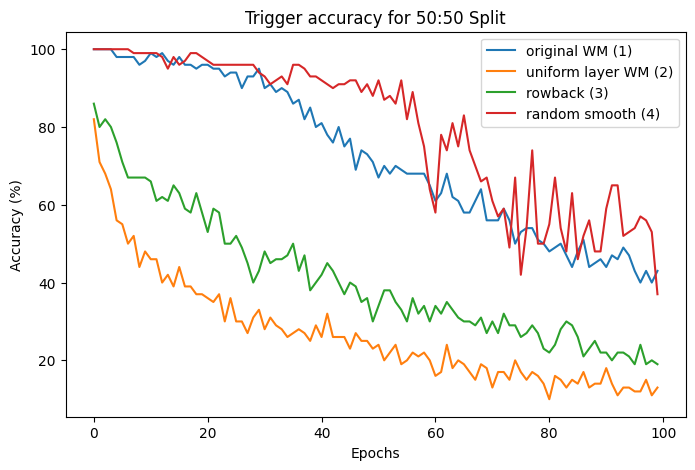

In [70]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metrics18['trigger_acc'])), metrics18['trigger_acc'], label='original WM (1)')
plt.plot(range(len(metrics19['trigger_acc'])), metrics19['trigger_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics20['trigger_acc'])), metrics20['trigger_acc'], label='rowback (3)')

plt.plot(range(len(metrics17['trigger_acc'])), metrics17['trigger_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Trigger accuracy for 50:50 Split')
plt.legend()
plt.savefig('incre_trigger_acc_5050.png')

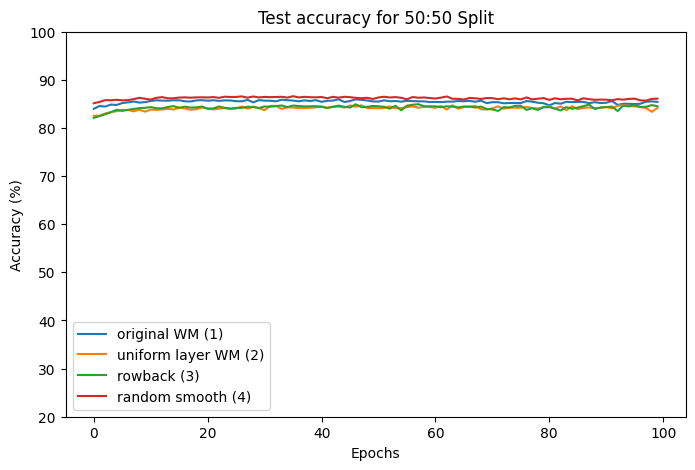

In [71]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(metrics18['val_acc'])), metrics18['val_acc'], label='original WM (1)')
plt.plot(range(len(metrics19['val_acc'])), metrics19['val_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics20['val_acc'])), metrics20['val_acc'], label='rowback (3)')

plt.plot(range(len(metrics17['val_acc'])), metrics17['val_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test accuracy for 50:50 Split')
plt.ylim([20, 100])
plt.legend()
plt.savefig('incre_test_acc_5050.png')

In [72]:
stp[]

SyntaxError: invalid syntax (2820510209.py, line 1)

75:25 Split

In [ ]:
batch_size_train = 256
batch_size_test = 256
batch_size_wm = 64

trainset = datasets.ImageFolder('./data/CIFAR10_7525/with_trigger/train/', transform=transform_train)
incset = datasets.ImageFolder('./data/CIFAR10_7525/with_trigger/train_incre/', transform=transform_train)
testset = datasets.ImageFolder('./data/CIFAR10_7525/test', transform=transform_test)
# valset = datasets.ImageFolder('./data/CIFAR10_7525/with_trigger/val/', transform=transform_test)
watermarkset = datasets.ImageFolder('./data/CIFAR10_7525/with_trigger/trigger_random/', transform=transform_test)
advwatermarkset = datasets.ImageFolder('./data/CIFAR10_7525/with_trigger/trigger_adv/', transform=transform_test)

unrelatedset = watermark_unrelated(count=100)
train_watermark_mixset = torch.utils.data.ConcatDataset((trainset,unrelatedset))


# testset = torchvision.datasets.CIFAR10(
#     root='./data', train=False, download=True, transform=transform_test)

unrelatedloader = torch.utils.data.DataLoader(
    unrelatedset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=8)

# valloader = torch.utils.data.DataLoader(
    # valset, batch_size=batch_size_test, shuffle=False, num_workers=8)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

incloader = torch.utils.data.DataLoader(
    incset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

wmloader = torch.utils.data.DataLoader(
    watermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
advwmloader = torch.utils.data.DataLoader(
    advwatermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
train_watermark_loader = torch.utils.data.DataLoader(
    train_watermark_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

In [ ]:
## Sanity Check
print(f"Length of trainset {len(trainset)}")
print(f"Length of incset {len(incset)}")
print(f"Length of testset {len(testset)}")
# print(f"Length of # valset {len(# valset)}")
print(f"Length of watermarkset {len(watermarkset)}")
print(f"Length of advwatermarkset {len(advwatermarkset)}")

In [ ]:
net21 = ResNet18()
net21.load_state_dict(torch.load('./models/wm_cifar10_certify_random_7525.pth')['model_state_dict'])
net22 = ResNet18()
net22.load_state_dict(torch.load('./checkpoints/resnet18_wm_7525.ckpt'))
net23 = ResNet18()
net23.load_state_dict(torch.load('./checkpoints/resnet18_wm_frozen_7525.ckpt'))
net24 = ResNet18()
net24.load_state_dict(torch.load('./checkpoints/resnet18_wm_rowback_7525.ckpt'))

In [ ]:
evaluator = Evaluator(net21, torch.nn.CrossEntropyLoss())
print(evaluator.eval(testloader))
print(evaluator.eval(unrelatedloader))

In [ ]:
evaluator = Evaluator(net22, torch.nn.CrossEntropyLoss())
print("Original watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

In [ ]:
evaluator = Evaluator(net23, torch.nn.CrossEntropyLoss())
print("Frozen watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(wmloader)}")

In [ ]:
evaluator = Evaluator(net24, torch.nn.CrossEntropyLoss())
print("ROWBack watermarking scheme")
print(f"Test accuracy {evaluator.eval(testloader)}")
print(f"Watermark accuracy {evaluator.eval(advwmloader)}")

In [ ]:
logcmt = f"incre_train_certified_7525"

optimizer21 = torch.optim.SGD(lr=0.001, params=net21.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer21 = Trainer(net21, criterion, optimizer21, incloader)
evaluator21 = Evaluator(net21, criterion)

metrics21 = train(trainer21, evaluator21, testloader, savename='inccheckpoints/incre_train_cert_7525', logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader, epochs=100)

In [ ]:
logcmt = f"incre_train_baseline_7525"

optimizer22 = torch.optim.SGD(lr=0.001, params=net22.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer22 = Trainer(net22, criterion, optimizer22, incloader)
evaluator22 = Evaluator(net22, criterion)

metrics22 = train(trainer22, evaluator22, testloader, savename='inccheckpoints/incre_train_baseline_7525', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

In [ ]:
logcmt = f"incre_train_baseline_frozen_7525"

optimizer23 = torch.optim.SGD(lr=0.001, params=net23.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer23 = Trainer(net23, criterion, optimizer23, incloader)
evaluator23 = Evaluator(net23, criterion)

metrics23 = train(trainer23, evaluator23, testloader, savename='inccheckpoints/incre_train_baseline_frozen_7525', logdir='./runs', logcmt=logcmt, trigger_loader=wmloader, epochs=100)

In [ ]:
logcmt = f"incre_train_baseline_rowback_7525"

optimizer24 = torch.optim.SGD(lr=0.001, params=net24.parameters(), momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer24 = Trainer(net24, criterion, optimizer24, incloader)
evaluator24 = Evaluator(net24, criterion)

metrics24 = train(trainer24, evaluator24, testloader, savename='inccheckpoints/incre_train_baseline_rowback_7525', logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader, epochs=100)

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(range(len(metrics22['trigger_acc'])), metrics22['trigger_acc'], label='original WM (1)')
plt.plot(range(len(metrics23['trigger_acc'])), metrics23['trigger_acc'], label='uniform layer WM (2)')
plt.plot(range(len(metrics24['trigger_acc'])), metrics24['trigger_acc'], label='rowback (3)')

plt.plot(range(len(metrics21['trigger_acc'])), metrics21['trigger_acc'], label='random smooth (4)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Trigger accuracy for 75:25 Split')
plt.legend()
plt.savefig('incre_trigger_acc_7525.png')

In [ ]:
# plt.figure(figsize=(8, 5))

# plt.plot(range(len(metrics2['val_acc'])), metrics2['val_acc'], label='usual training (1)')
# plt.plot(range(len(metrics3['val_acc'])), metrics3['val_acc'], label='uniform layer WM (2)')
# plt.plot(range(len(metrics1['val_acc'])), metrics1['val_acc'], label='random smooth (3)')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy (%)')
# plt.title('Test accuracy')
# plt.ylim([20, 100])
# plt.legend()
# plt.savefig('incre_test_acc.png')